# Build and Train Models

In [1]:
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn

from matplotlib import pyplot as plt

print(f'pandas: {pd.__version__}')
print(f'numpy: {np.__version__}')
print(f'matplotlib: {matplotlib.__version__}')
print(f'seaborn: {sns.__version__}')
print(f'sklearn: {sklearn.__version__}')

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', str)

pandas: 2.1.1
numpy: 1.26.0
matplotlib: 3.8.0
seaborn: 0.13.0
sklearn: 1.3.1


# Load Data

Load data from each category and keep track of loaded columns

In [2]:
from modules.utils import load_saved_data

zoopla_columns = ['zoo_property_type','zoo_start_date','zoo_end_date','zoo_price_first','zoo_price_last','zoo_price_min','zoo_price_max','zoo_price_increase','zoo_num_bed_min','zoo_num_bed_max','zoo_num_floors_min','zoo_num_floors_max','zoo_num_bath_min','zoo_num_bath_max','zoo_num_reception_min','zoo_num_reception_max','zoo_address','zoo_street_name','zoo_property_num','zoo_post_town','zoo_country','zoo_county','zoo_category','zoo_branch_id','zoo_agent_name','zoo_agent_address','zoo_agent_postcode','zoo_duration', 'zoo_auction','zoo_ground_or_top_floor','zoo_garage','zoo_shared_ownership','zoo_started_not_ended']

df = load_saved_data('1_ppd_epc_data')
ppd_cols = df.columns.drop(['EPC_UPRN']).to_list()

df = df.merge(load_saved_data('2_ppd_zoo_data')[zoopla_columns], how='left', left_index=True, right_index=True)
zoo_cols = list(set(df.columns) - set(ppd_cols))

df = df.merge(load_saved_data('3_ppd_transport_data'), how='left', left_index=True, right_index=True)
transport_cols = list(set(df.columns) - set(ppd_cols + zoo_cols))

df = df.merge(load_saved_data('4_ppd_school_data'), how='left', left_index=True, right_index=True)
school_cols = list(set(df.columns) - set(ppd_cols + zoo_cols + transport_cols))

df = df.merge(load_saved_data('5_ppd_green_space_data'), how='left', left_index=True, right_index=True)
space_cols = list(set(df.columns) - set(ppd_cols + zoo_cols + transport_cols + school_cols))

df = df.merge(load_saved_data('6_ppd_imd_data'), how='left', left_index=True, right_index=True)
imd_cols = list(set(df.columns) - set(ppd_cols + zoo_cols + transport_cols + school_cols + space_cols))

df = df[(df['UPRN_LATITUDE'].notna()) & (df['EPC_CURRENT_ENERGY_RATING'] != 'INVALID!')]

Loading saved data from ./data/saved/1_ppd_epc_data.parquet...
Loading saved data from ./data/saved/2_ppd_zoo_data.parquet...
Loading saved data from ./data/saved/3_ppd_transport_data.parquet...
Loading saved data from ./data/saved/4_ppd_school_data.parquet...
Loading saved data from ./data/saved/5_ppd_green_space_data.parquet...
Loading saved data from ./data/saved/6_ppd_imd_data.parquet...


A few utility functions

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score, KFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils.validation import check_is_fitted
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from modules.transformers import *

import modules.utils as utils
import pandas as pd
import numpy as np

seed = 42
NA = '__NA__'

def save_divide(df, feature_name, numerator, denominator):
    valid_numerator = df[numerator].notna()
    valid_denominator = (df[denominator] != 0) & (df[denominator].notna())
    df[feature_name] = np.where(valid_numerator & valid_denominator, df[numerator] / df[denominator], df[numerator])

def add_custom_features(df):
    df = df.copy()
    save_divide(df, 'ENG_BedroomRatio', 'zoo_num_bed_min', 'EPC_NUMBER_HABITABLE_ROOMS')
    save_divide(df, 'ENG_BathroomRatio', 'zoo_num_bath_min', 'EPC_NUMBER_HABITABLE_ROOMS')
    return df

def sorted_corr(df, col):
    corr_matrix = df.corr(numeric_only=True)
    sorted_index = abs(corr_matrix[col]).sort_values(ascending=False).index
    return corr_matrix.reindex(index=sorted_index, columns=sorted_index)

def plot_learning_curve(model_name, model, X_train, y_train, sample_size=1.0):
    X_train_sample = X_train.copy()
    y_train_sample = y_train.copy()

    if sample_size < 1.0:
        X_train_sample, _, y_train_sample, _ = train_test_split(X_train, y_train, train_size=sample_size, random_state=seed)

    train_sizes, train_scores, test_scores = learning_curve(model, X_train_sample, y_train_sample, train_sizes=np.linspace(0.01, 1.0, 20), cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
    
    # Calculate mean and standard deviation for training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    # Calculate mean and standard deviation for validation set scores
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)  
    
    plt.figure(figsize=(10, 6))
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="#3498db")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="#e74c3c")
    plt.plot(train_sizes, train_mean, 'o-', color="#3498db", label="Training score")
    plt.plot(train_sizes, test_mean, 'o-', color="#e74c3c", label="Cross-validation score")

    plt.xlabel("Training Set Size")
    plt.ylabel("Mean Absolute Error")
    plt.title(f'Learning Curve for {model_name}')
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

# Baseline model

Start with only `PPD_Price` and `EPC_TOTAL_FLOOR_AREA` columns.

In [4]:
selected_df = df[['PPD_Price', 'EPC_TOTAL_FLOOR_AREA']]
selected_df.describe()

PPD_Price  EPC_TOTAL_FLOOR_AREA
count          388450.0              388450.0
mean  647531.8174900245     89.54160101660445
std   1174854.710530962     53.09946162353392
min                 1.0                   0.0
25%            350000.0                  60.0
50%            470000.0                  78.0
75%            670000.0                 104.0
max         210000000.0                4823.0

The simplest model

In [5]:
# Selected columns
numeric_cols = selected_df.select_dtypes(include=['int64', 'float64']).columns.drop('PPD_Price')

X = selected_df.drop('PPD_Price', axis=1)
y = selected_df['PPD_Price']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

main_transformers = make_column_transformer(
    ('passthrough', numeric_cols)
)

pipeline = make_pipeline(
    main_transformers,
)

# Creating pipelines, set n_jobs=-1 to use all cores
lr_pipeline = make_pipeline(pipeline, LinearRegression(n_jobs=-1))
rf_pipeline = make_pipeline(pipeline, RandomForestRegressor(n_jobs=-1, random_state=seed))

models = {
    'linear': lr_pipeline,
    'randomForest': rf_pipeline,
}

# Fit models
for model in models.values():
    model.fit(X_train, y_train)

# Evaluate models
for name, model in models.items():
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"{name} (r2: {r2:.6f}, mae: {mae:.2f}, rmse: {rmse:.2f})") 

linear (r2: 0.231180, mae: 295621.35, rmse: 973929.98)
randomForest (r2: 0.103840, mae: 258781.39, rmse: 1051496.99)


# Log-normalise target column

Visualise heavy left-skewed target column

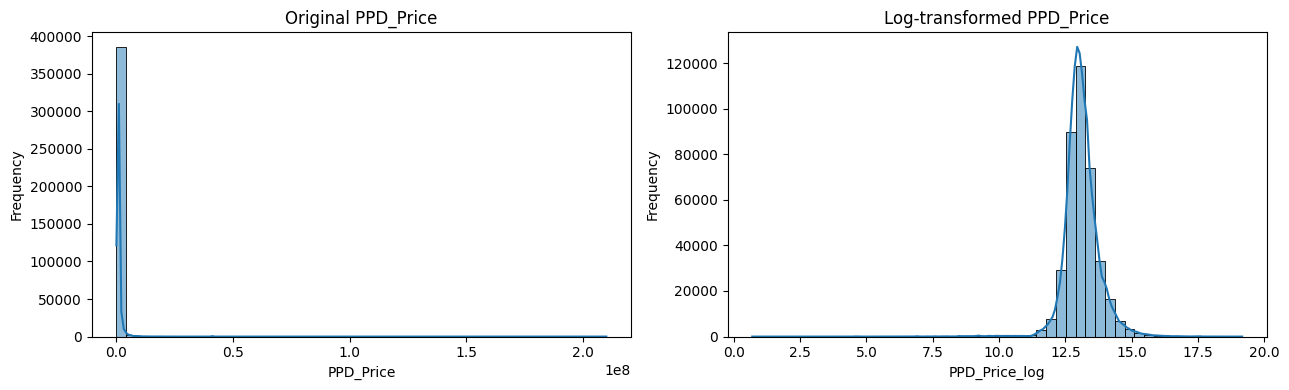

In [6]:
# Log-normalize target
chart_df = df[['PPD_Price', 'EPC_TOTAL_FLOOR_AREA']].copy()
chart_df['PPD_Price_Log'] = np.log1p(chart_df['PPD_Price'])

plt.figure(figsize=(13, 4))

# Original PPD_Price
plt.subplot(1, 2, 1)
sns.histplot(chart_df['PPD_Price'], kde=True, bins=50)
plt.title('Original PPD_Price')
plt.xlabel('PPD_Price')
plt.ylabel('Frequency')

# Log-transformed PPD_Price
plt.subplot(1, 2, 2)
sns.histplot(chart_df['PPD_Price_Log'], kde=True, bins=50)
plt.title('Log-transformed PPD_Price')
plt.xlabel('PPD_Price_log')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Text(0, 0.5, 'PPD_Price_Log')

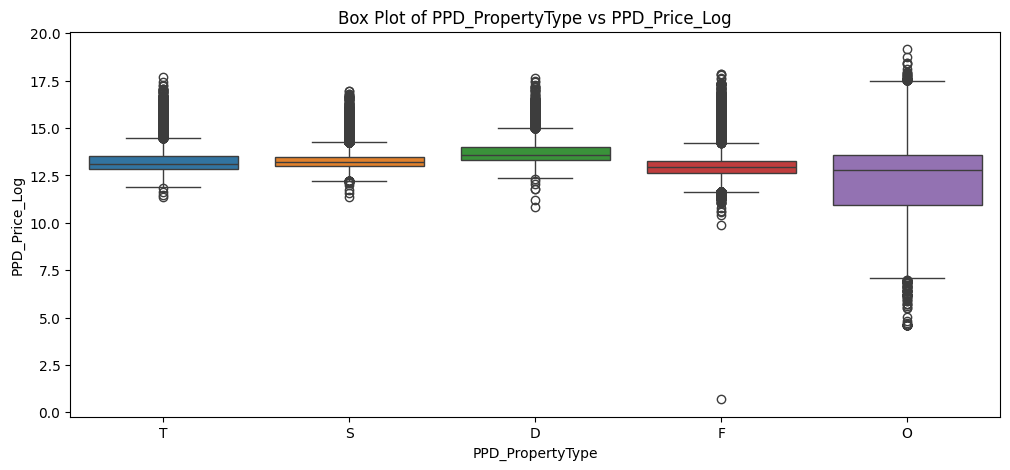

In [7]:
# Selecting property type and price
chart_df = df[['PPD_Price', 'PPD_PropertyType']].copy()
chart_df['PPD_Price_Log'] = np.log1p(chart_df['PPD_Price'])

# Boxplot of PPD_Price by PPD_PropertyType
plt.figure(figsize=(12, 5))
sns.boxplot(x='PPD_PropertyType', y='PPD_Price_Log', hue='PPD_PropertyType', data=chart_df, palette='tab10')
plt.title(f'Box Plot of PPD_PropertyType vs PPD_Price_Log')
plt.xlabel('PPD_PropertyType')
plt.ylabel('PPD_Price_Log')

# Identify and remove outliers 

In [8]:
import scipy.stats

def remove_outliers(df, col, z=3):
    df = df.copy()
    
    # Create a log-transformed Series with NA values filled with median
    transformed_col = np.log1p(df[col].fillna(df[col].median()))

    selected = np.abs(scipy.stats.zscore(transformed_col)) < z
    return df[selected]

def remove_outliers_iqr(df, col):
    df = df.copy()
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    df = df[(df[col] > (q1 - 1.5 * iqr)) & (df[col] < (q3 + 1.5 * iqr))]
    return df

def remove_outliers_by_lambda(df, lambd, z=3):
    df = df.copy()
    df['__lambda__'] = df.apply(lambd, axis=1)
    df = remove_outliers(df, '__lambda__', z)
    df = df.drop('__lambda__', axis=1)
    return df

In [9]:
prepared_df = remove_outliers(selected_df, 'PPD_Price')

print('Removed count:', len(df) - len(prepared_df))
print('Retained ratio:', utils.format_ratio(len(prepared_df), len(df)))

Removed count: 5466
Retained ratio: 98.5929%


Distribution comparison between the original data, log-normalised and regularised data. 

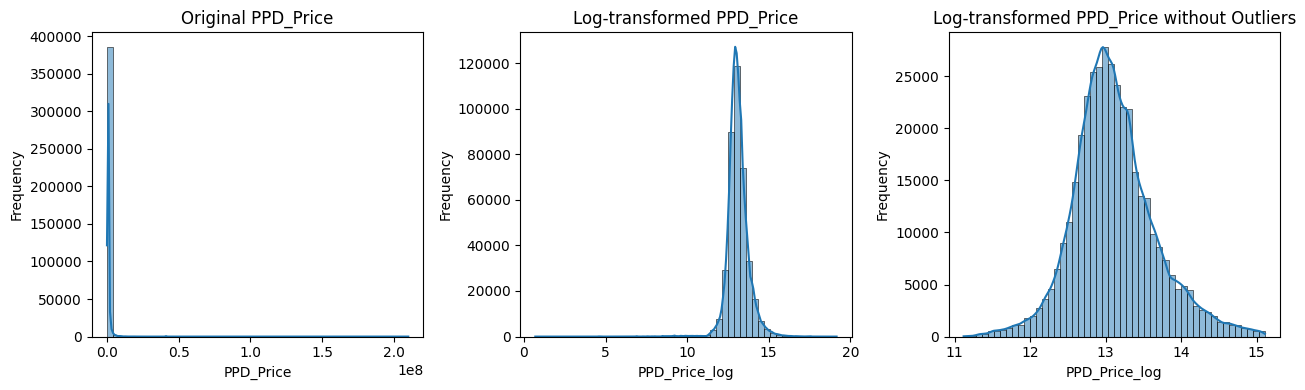

In [10]:
chart_df = selected_df.copy()
chart_df['PPD_Price_Log'] = np.log1p(chart_df['PPD_Price'])

# Plot the original and transformed PPD_Price
plt.figure(figsize=(13, 4))

# Original PPD_Price
plt.subplot(1, 3, 1)
sns.histplot(chart_df['PPD_Price'], kde=True, bins=50)
plt.title('Original PPD_Price')
plt.xlabel('PPD_Price')
plt.ylabel('Frequency')

# Log-transformed PPD_Price
plt.subplot(1, 3, 2)
sns.histplot(chart_df['PPD_Price_Log'], kde=True, bins=50)
plt.title('Log-transformed PPD_Price')
plt.xlabel('PPD_Price_log')
plt.ylabel('Frequency')

# Log-transformed PPD_Price
plt.subplot(1, 3, 3)
sns.histplot(remove_outliers(chart_df, 'PPD_Price')['PPD_Price_Log'], kde=True, bins=50)
plt.title('Log-transformed PPD_Price without Outliers')
plt.xlabel('PPD_Price_log')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Remove outliers and retrain models

In [11]:
# Remove outliers
prepared_df = remove_outliers(selected_df, 'PPD_Price')

# Selected columns
numeric_cols = prepared_df.select_dtypes(include=['int64', 'float64']).columns.drop('PPD_Price')

X = prepared_df.drop('PPD_Price', axis=1)
y = prepared_df['PPD_Price']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

main_transformers = make_column_transformer(
    ('passthrough', numeric_cols)
)

pipeline = make_pipeline(
    main_transformers,
)

# Creating pipelines
lr_pipeline = make_pipeline(pipeline, LinearRegression(n_jobs=-1))
rf_pipeline = make_pipeline(pipeline, RandomForestRegressor(n_jobs=-1, random_state=seed))

models = {
    'linear': lr_pipeline,
    'randomForest': rf_pipeline,
}

# Fit models
for model in models.values():
    model.fit(X_train, y_train)

# Evaluate models
for name, model in models.items():
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"{name} (r2: {r2:.6f}, mae: {mae:.2f}, rmse: {rmse:.2f})") 

linear (r2: 0.389050, mae: 192269.92, rmse: 325766.40)
randomForest (r2: 0.446185, mae: 190521.60, rmse: 310160.24)


In [12]:
prepared_df['EPC_TOTAL_FLOOR_AREA'].describe()

count            382984.0
mean    87.82022456904204
std       45.796544320756
min                   0.0
25%                  60.0
50%                  78.0
75%                 103.0
max                4373.0
Name: EPC_TOTAL_FLOOR_AREA, dtype: float64

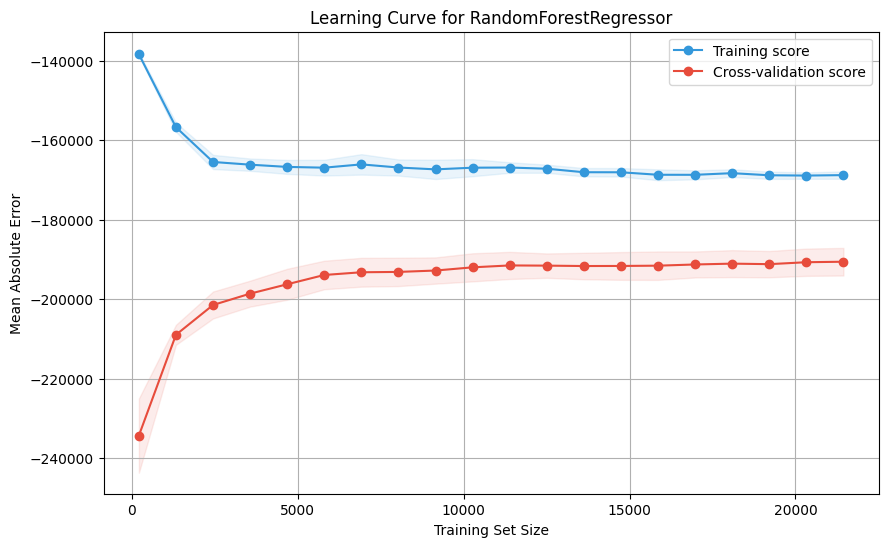

In [13]:
plot_learning_curve('RandomForestRegressor', models['randomForest'], X_train, y_train, sample_size=0.1)

Remove outliers using the derived column "Price Per Area"

In [14]:
prepared_df = selected_df[selected_df['EPC_TOTAL_FLOOR_AREA'] != 0].copy()
prepared_df = remove_outliers_by_lambda(prepared_df, lambda row: row['PPD_Price'] / row['EPC_TOTAL_FLOOR_AREA'])

print('Removed count:', len(df) - len(prepared_df))
print('Retained ratio:', utils.format_ratio(len(prepared_df), len(df)))

Removed count: 4543
Retained ratio: 98.8305%


In [15]:
# Remove outliers
prepared_df = selected_df[selected_df['EPC_TOTAL_FLOOR_AREA'] != 0].copy()
prepared_df = remove_outliers_by_lambda(prepared_df, lambda row: row['PPD_Price'] / row['EPC_TOTAL_FLOOR_AREA'])

# Selected columns
numeric_cols = prepared_df.select_dtypes(include=['int64', 'float64']).columns.drop('PPD_Price')

X = prepared_df.drop('PPD_Price', axis=1)
y = prepared_df['PPD_Price']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

main_transformers = make_column_transformer(
    ('passthrough', numeric_cols)
)

pipeline = make_pipeline(
    main_transformers,
)

# Creating pipelines
lr_pipeline = make_pipeline(pipeline, LinearRegression(n_jobs=-1))
rf_pipeline = make_pipeline(pipeline, RandomForestRegressor(n_jobs=-1, random_state=seed))

models = {
    'linear': lr_pipeline,
    'randomForest': rf_pipeline,
}

# Fit models
for model in models.values():
    model.fit(X_train, y_train)

# Evaluate models
for name, model in models.items():
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"{name} (r2: {r2:.6f}, mae: {mae:.2f}, rmse: {rmse:.2f})") 

linear (r2: 0.512023, mae: 227555.14, rmse: 422321.34)
randomForest (r2: 0.475656, mae: 210406.69, rmse: 437775.84)


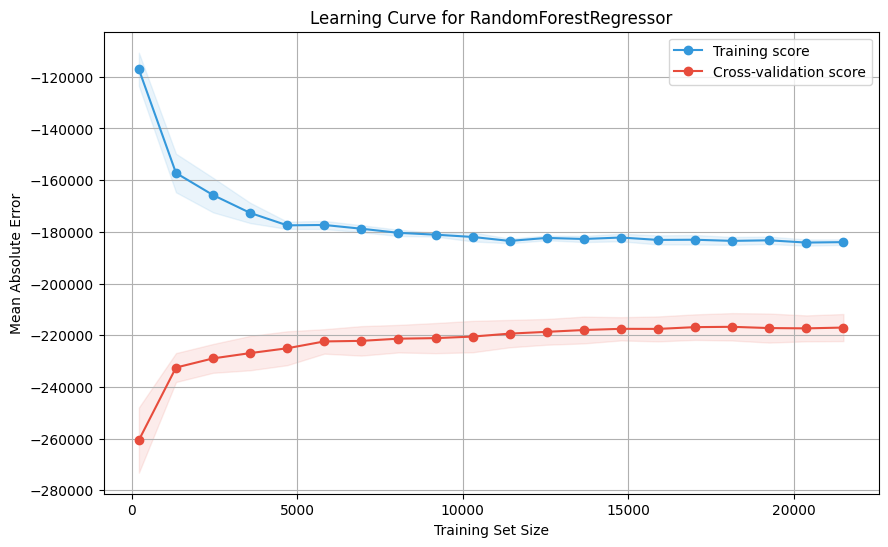

In [16]:
plot_learning_curve('RandomForestRegressor', models['randomForest'], X_train, y_train, sample_size=0.1)

# Feature encoding and correlation matrix

In [17]:
def bucket_floor_levels(value):
    if value in {'basement', 'ground', 'low', 'mid', 'high', 'top', 'unknown'}:
        return value
    
    try:
        num = int(value)
        if num < 0:
            return 'basement'
        elif num == 0:
            return 'ground'
        elif num <= 3:
            return 'low'
        elif num <= 6:
            return 'mid'
        elif num <= 12:
            return 'high'
        else:
            return 'top'
        
    except Exception:
        return 'unknown'
    
def get_single_value_features(df):
    object_cols = df.select_dtypes(include=['object']).columns
    unique_counts = {col: df[col].nunique() for col in object_cols}
    return [col for col, count in unique_counts.items() if count == 1]

def get_high_cardinality_features(df, cardinality_threshold=80):
    object_cols = df.select_dtypes(include=['object']).columns
    unique_counts = {col: df[col].nunique() for col in object_cols}
    return [col for col, count in unique_counts.items() if count > cardinality_threshold]

def preprocess_data(df, missing_drop_threshold=50, cardinality_threshold=80):
    df = df.copy()
    df.replace([None], np.nan, inplace=True)
    
    # Drop columns with more than 50% missing values
    missing_percentage = df.isnull().mean() * 100
    sparse_cols = missing_percentage[missing_percentage > missing_drop_threshold].index.tolist()

    # Drop categories with single unique value or too many unique values
    single_variance_cols = get_single_value_features(df)
    high_cardinality_cols = get_high_cardinality_features(df, cardinality_threshold)
    
    return df.drop(columns=sparse_cols + single_variance_cols + high_cardinality_cols)

def encode_month_to_cyclic(month):
    return -np.cos(0.52359 * month)

def encode_columns(df):
    df = df.copy()
    
    if 'EPC_FLOOR_LEVEL' in df.columns:
        df['EPC_FLOOR_LEVEL'] = df['EPC_FLOOR_LEVEL'].apply(bucket_floor_levels)
    
    epc_rating_cols = ['EPC_CURRENT_ENERGY_RATING'] if 'EPC_CURRENT_ENERGY_RATING' in df.columns else []
    eff_cols = [col for col in df.columns if col.endswith('_EFF')]

    object_cols = df.select_dtypes(include=['object']).columns.difference(epc_rating_cols + eff_cols)
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    boolean_cols = df.select_dtypes(include=['bool']).columns

    # Label encode object columns
    label_encoder = LabelEncoder()
    for col in object_cols:
        df[col] = label_encoder.fit_transform(df[col].astype(str))

    # Ordinal encode rating columns
    if 'EPC_CURRENT_ENERGY_RATING' in df.columns:
        df['EPC_CURRENT_ENERGY_RATING'].fillna(df['EPC_CURRENT_ENERGY_RATING'].mode().iloc[0], inplace=True)
        ordinal_encoder = OrdinalEncoder(categories=[['G', 'F', 'E', 'D', 'C', 'B', 'A']], handle_unknown='use_encoded_value', unknown_value=-1)
        df['EPC_CURRENT_ENERGY_RATING'] = ordinal_encoder.fit_transform(df['EPC_CURRENT_ENERGY_RATING'].values.reshape(-1, 1))

    for col in eff_cols:
        df[col].fillna(df[col].mode().iloc[0], inplace=True)
        ordinal_encoder = OrdinalEncoder(categories=[['Very Poor', 'Poor', 'Average', 'Good', 'Very Good']])
        df[col] = ordinal_encoder.fit_transform(df[col].values.reshape(-1, 1))

    # Handle datetime columns by extracting Year and Month components
    for col in df.select_dtypes(include=['datetime64']).columns:
        df[f'{col}_Year'] = df[col].dt.year
        df[f'{col}_Month'] = encode_month_to_cyclic(df[col].dt.month)
        df.drop(columns=[col], inplace=True)  # Drop the original datetime column

    # Select year and month columns
    datetime_cols = [col for col in df.columns if (col.endswith('_Year') or col.endswith('_Month'))]

    return df[list(numeric_cols) + list(boolean_cols) + list(object_cols) + epc_rating_cols + eff_cols + datetime_cols]

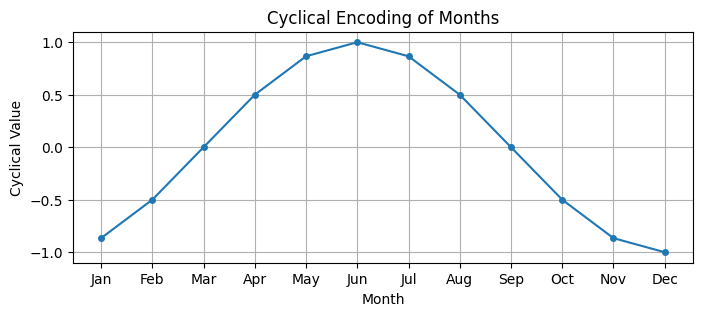

In [18]:
months = list(range(1, 13))
cyclical_values = [encode_month_to_cyclic(month) for month in months]

plt.figure(figsize=(8, 3))
plt.plot(months, cyclical_values, 'o-', markersize=4)
plt.title('Cyclical Encoding of Months')
plt.xlabel('Month')
plt.ylabel('Cyclical Value')
plt.xticks(months, ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.grid(True)
plt.show()

Correlation matrix

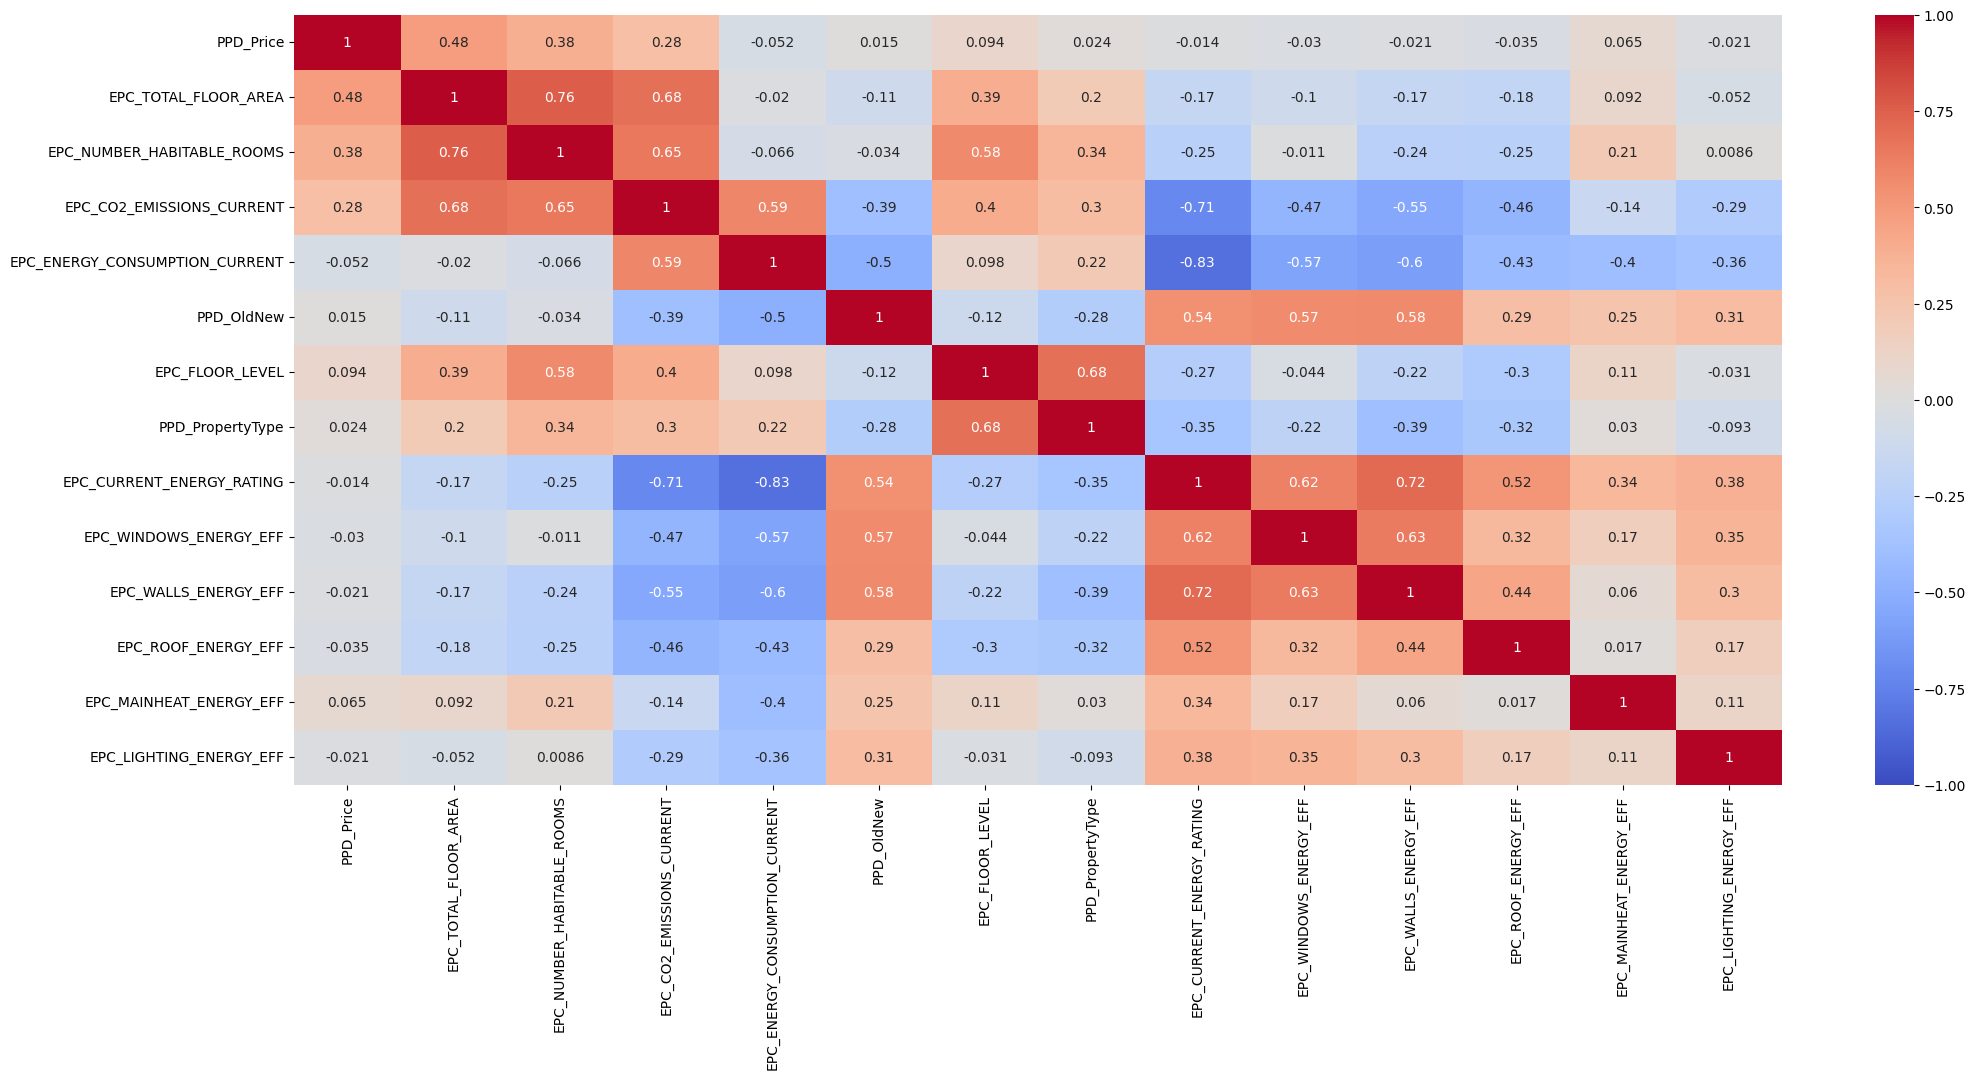

In [19]:
encoded_df = encode_columns(preprocess_data(df[[
  'PPD_Price',
  'PPD_PropertyType',
  'PPD_OldNew',
  
  'EPC_TOTAL_FLOOR_AREA',
  'EPC_NUMBER_HABITABLE_ROOMS',
  'EPC_FLOOR_LEVEL',
  'EPC_CURRENT_ENERGY_RATING',
  'EPC_WINDOWS_ENERGY_EFF',
  'EPC_WALLS_ENERGY_EFF',
  'EPC_ROOF_ENERGY_EFF',
  'EPC_MAINHEAT_ENERGY_EFF',
  'EPC_LIGHTING_ENERGY_EFF',
  'EPC_CO2_EMISSIONS_CURRENT',
  'EPC_ENERGY_CONSUMPTION_CURRENT',
]]))

# Plot
plt.figure(figsize=(24, 10))
sns.heatmap(encoded_df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

In [20]:
selected_df = df[[
  'PPD_Price',
  'PPD_PropertyType',
  'PPD_OldNew',
  
  'EPC_TOTAL_FLOOR_AREA',
  'EPC_NUMBER_HABITABLE_ROOMS',
  'EPC_FLOOR_LEVEL',
  'EPC_CURRENT_ENERGY_RATING',
  'EPC_WINDOWS_ENERGY_EFF',
  'EPC_WALLS_ENERGY_EFF',
  'EPC_ROOF_ENERGY_EFF',
  'EPC_MAINHEAT_ENERGY_EFF',
  'EPC_LIGHTING_ENERGY_EFF',
  'EPC_CO2_EMISSIONS_CURRENT',
  'EPC_ENERGY_CONSUMPTION_CURRENT',
]]

prepared_df = selected_df[selected_df['EPC_TOTAL_FLOOR_AREA'] != 0].copy()
prepared_df = remove_outliers_by_lambda(prepared_df, lambda row: row['PPD_Price'] / row['EPC_TOTAL_FLOOR_AREA'])
prepared_df['EPC_FLOOR_LEVEL'] = prepared_df['EPC_FLOOR_LEVEL'].apply(bucket_floor_levels)

# Selected columns
epc_rating_col = ['EPC_CURRENT_ENERGY_RATING']
eff_cols = [col for col in prepared_df.columns if col.endswith('_EFF')]

object_cols = prepared_df.select_dtypes(include=['object']).columns.drop(epc_rating_col + eff_cols)
numeric_cols = prepared_df.select_dtypes(include=['int64', 'float64']).columns.drop('PPD_Price')
boolean_cols = prepared_df.select_dtypes(include=['bool']).columns

X = prepared_df.drop('PPD_Price', axis=1)
y = prepared_df['PPD_Price']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

main_transformers = make_column_transformer(
    (make_pipeline(SimpleImputer(strategy='median'), StandardScaler()), numeric_cols),
    (make_pipeline(SimpleImputer(strategy='most_frequent'), OrdinalEncoder(categories=[['G', 'F', 'E', 'D', 'C', 'B', 'A']])), epc_rating_col),
    (make_pipeline(SimpleImputer(strategy='most_frequent'), OrdinalEncoder(categories=[['VERY POOR', 'POOR', 'AVERAGE', 'GOOD', 'VERY GOOD']] * len(eff_cols))), eff_cols),
    (make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='infrequent_if_exist')), object_cols),
    (make_pipeline(BooleanToInteger(), SimpleImputer(strategy='most_frequent')), boolean_cols),
)

pipeline = make_pipeline(
    InvalidValueCleaner(),
    StringCleaner(),
    main_transformers,
)

# Creating pipelines
lr_pipeline = make_pipeline(pipeline, LinearRegression(n_jobs=-1))
rf_pipeline = make_pipeline(pipeline, RandomForestRegressor(n_jobs=-1, random_state=seed))

models = {
    'linear': lr_pipeline,
    'randomForest': rf_pipeline,
}

# Fit models
for model in models.values():
    model.fit(X_train, y_train)

# Evaluate models
for name, model in models.items():
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"{name} (r2: {r2:.6f}, mae: {mae:.2f}, rmse: {rmse:.2f})")

linear (r2: 0.573615, mae: 213132.27, rmse: 394770.41)
randomForest (r2: 0.654711, mae: 170285.19, rmse: 355250.47)


A collection of utility classes to use for pipeline

In [21]:
class NumericKNNImputer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, k=5, round=False):
        self.k = k
        self.columns = columns
        self.round = round
        self.encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
        self.imputer = SimpleImputer(strategy='median')
        self.scaler = RobustScaler()

    def preprocess(self, X):
        assert isinstance(X, pd.DataFrame), "Input data must be a DataFrame"

        if self.columns is not None:
            assert all(col in X.columns for col in self.columns), "Some columns are not in the input data"
            return X[self.columns].copy()

        return X.copy()

    def __encode_object_cols(self, X, fit=False):
        copy = X.copy()
        object_columns = copy.select_dtypes('object').columns.tolist()

        # Exclude the first column as it's our target
        if copy.columns[0] in object_columns:
            object_columns.remove(copy.columns[0])
            
        if object_columns:
            for col in object_columns:
                # Select rows without NaN values for the current column
                no_nan_rows = copy[col].dropna().index

                # Encode those values to numeric and assign it back
                if fit:
                    copy.loc[no_nan_rows, col] = self.encoder.fit_transform(copy.loc[no_nan_rows, col].values.reshape(-1, 1)).ravel()
                else:
                    copy.loc[no_nan_rows, col] = self.encoder.transform(copy.loc[no_nan_rows, col].values.reshape(-1, 1)).ravel()
        return copy  

    def fit(self, X, y=None):
        X = self.preprocess(X)
        X = self.__encode_object_cols(X, fit=True)

        # Split known and unknown rows for target_column
        known = X[X.columns[0]].notna()

        X_imputed = self.imputer.fit_transform(X[known])
        X_scaled = self.scaler.fit_transform(X_imputed)

        self.knn = KNeighborsRegressor(n_neighbors=self.k, metric='euclidean')
        self.knn.fit(X_scaled[:, 1:], X.loc[known, X.columns[0]])

        return self

    def transform(self, X):
        check_is_fitted(self, 'knn')

        X = self.preprocess(X)
        X_encoded = self.__encode_object_cols(X)
        unknown = X[X.columns[0]].isna()

        if unknown.sum() > 0:
            X_imputed = self.imputer.transform(X_encoded[unknown])
            X_scaled = self.scaler.transform(X_imputed)

            y_pred = self.knn.predict(X_scaled[:, 1:]).astype('float64') # type: ignore
            X.loc[unknown, X.columns[0]] = np.round(y_pred) if self.round else y_pred

        return X

    def get_feature_names_out(self, input_features=None):
        return self.columns if self.columns is not None else input_features 

class CategoryKNNImputer(NumericKNNImputer):
    def __init__(self, columns=None, k=5):
        super().__init__(columns, k, round=True)
        self.label_encoder = LabelEncoder()
        self.unseen_value = '__unseen__'
    
    def fit(self, X, y=None):
        X = self.preprocess(X)
        known = X[X.columns[0]].notna()

        self.label_encoder.fit(X.loc[known, X.columns[0]])

        # Reset with encoded values
        copy = X.copy() 
        copy.loc[known, copy.columns[0]] = self.label_encoder.transform(copy.loc[known, copy.columns[0]]) # type: ignore
        copy.loc[:, copy.columns[0]] = copy[copy.columns[0]].astype('float')

        # Call the parent fit function
        super().fit(copy, y)

        return self

    def transform(self, X):
        check_is_fitted(self, 'knn')

        X = self.preprocess(X)
        unknown = X[X.columns[0]].isna()

        if unknown.sum() > 0:
            # Apply KNN imputation on the encoded column
            transformed = super().transform(X)

            # Inverse transform the predicted values
            try:
                X.loc[unknown, X.columns[0]] = self.label_encoder.inverse_transform(transformed.loc[unknown, transformed.columns[0]].astype(int))
            except ValueError:
                # Handle unseen categories
                X.loc[unknown, X.columns[0]] = self.unseen_value

        return X

class SequentialImputer(BaseEstimator, TransformerMixin):
    def __init__(self, imputers=None):
        self.imputers = imputers if imputers is not None else []

    def fit(self, X, y=None):
        self.X_columns = X.columns
        for name, imp in self.imputers:
            imp.fit(X[self.X_columns])
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for name, imp in self.imputers:
            X_transformed.loc[:, imp.columns] = imp.transform(X_transformed[imp.columns])
        return X_transformed

    def get_feature_names_out(self, input_features=None):
        return self.X_columns

# Feature selection with correlation matrices

Number of unique values per column

In [22]:
df.select_dtypes(include=['object']).nunique().sort_values(ascending=False)

EPC_LMK_KEY                  373404
EPC_ADDRESS                  365966
EPC_ADDRESS1                 317052
PPD_Postcode                 100169
zoo_address                   79115
zoo_property_num              57600
zoo_street_name               41706
EPC_ADDRESS2                  40085
PPD_Street                    31820
ONSUD_OA                      25807
PPD_PAON                      23480
EPC_ADDRESS3                   5646
ONSUD_LSOA                     4992
PPD_SAON                       4769
IMD_LSOAName                   4656
zoo_agent_address              4226
zoo_agent_name                 4039
zoo_agent_postcode             3387
ONSUD_MSOA                     1002
ONSUD_WARD                      685
PPD_Locality                    262
PPD_TownCity                     79
zoo_post_town                    77
PPD_District                     33
ONSUD_BOROUGH                    33
EPC_FLOOR_LEVEL                  33
EPC_CONSTRUCTION_AGE_BAND        30
zoo_property_type           

Correlation matrix for PPD, EPC data

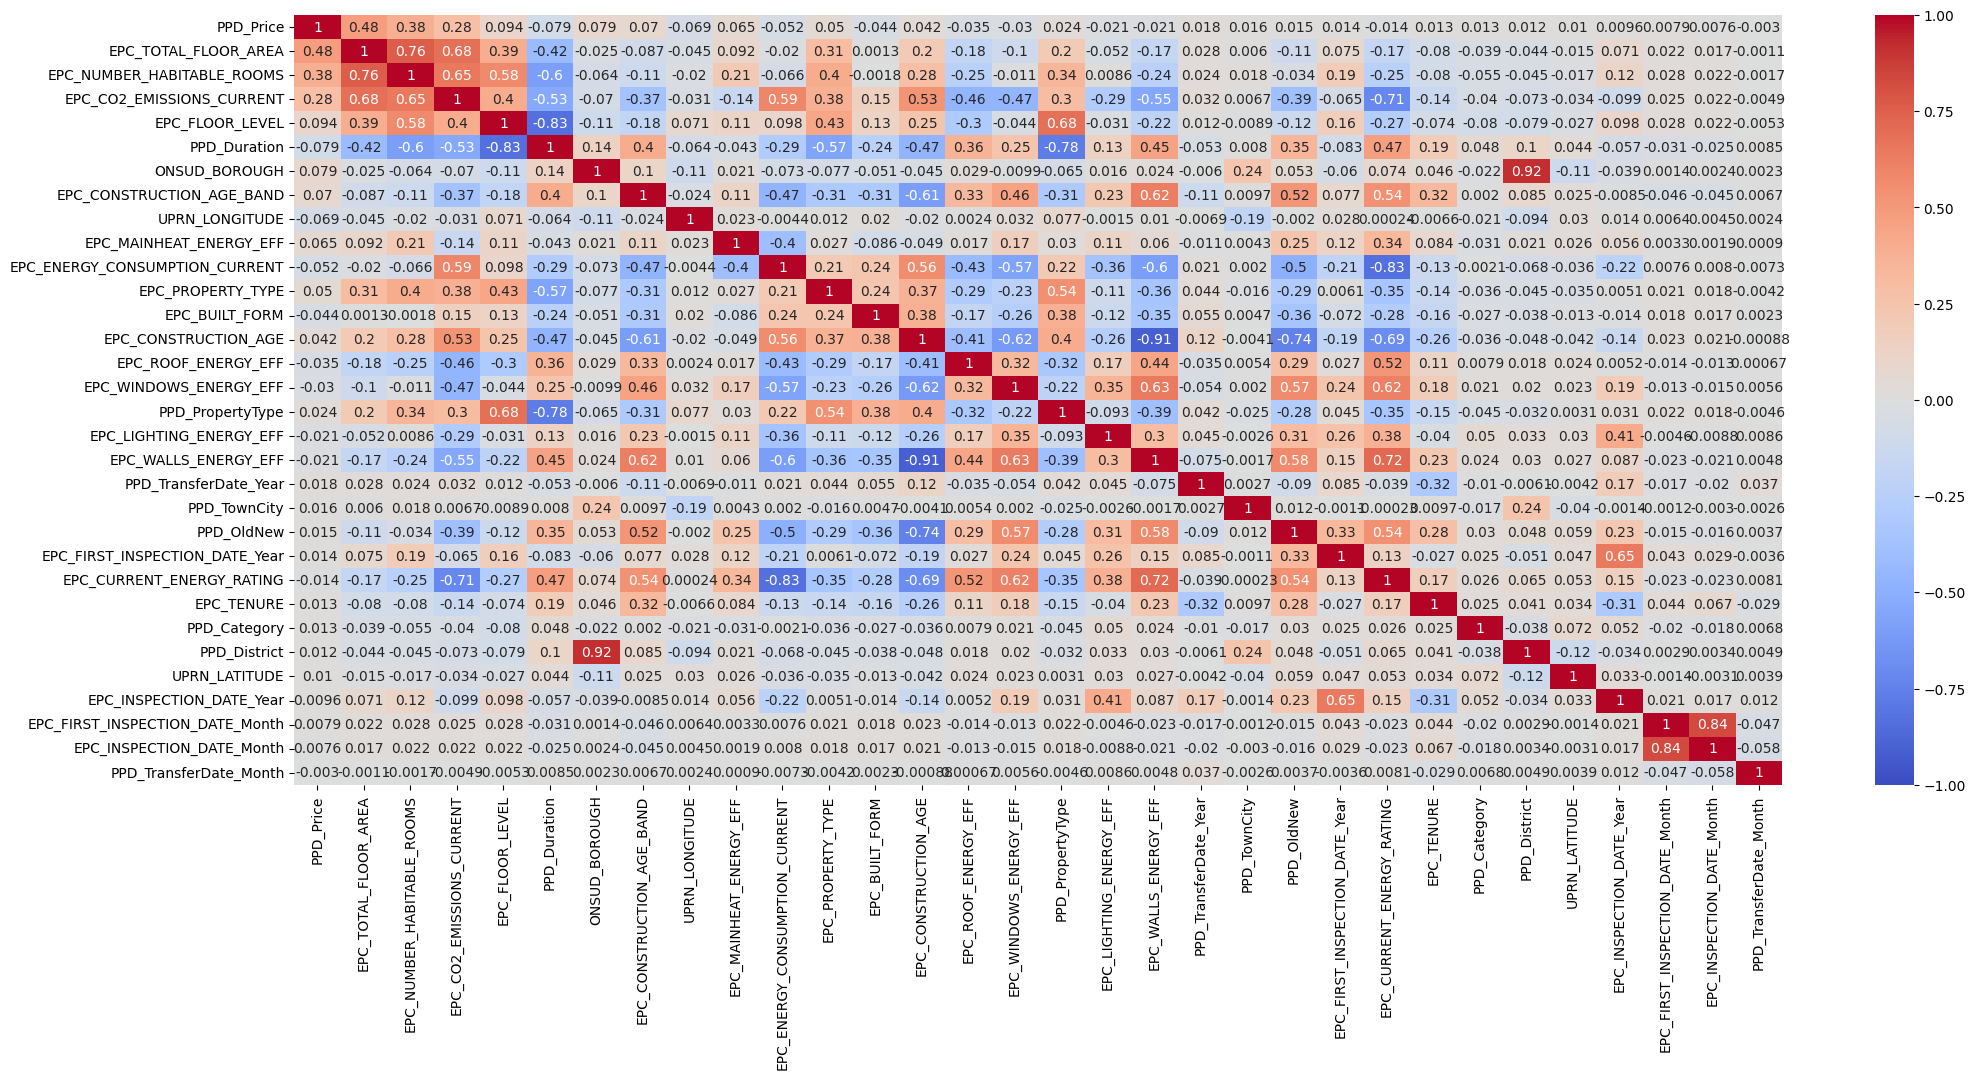

In [23]:
plt.figure(figsize=(24, 10))
epc_matrix = sorted_corr(encode_columns(preprocess_data(df[ppd_cols])), 'PPD_Price')
sns.heatmap(epc_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

Correlation matrix for Zoopla data

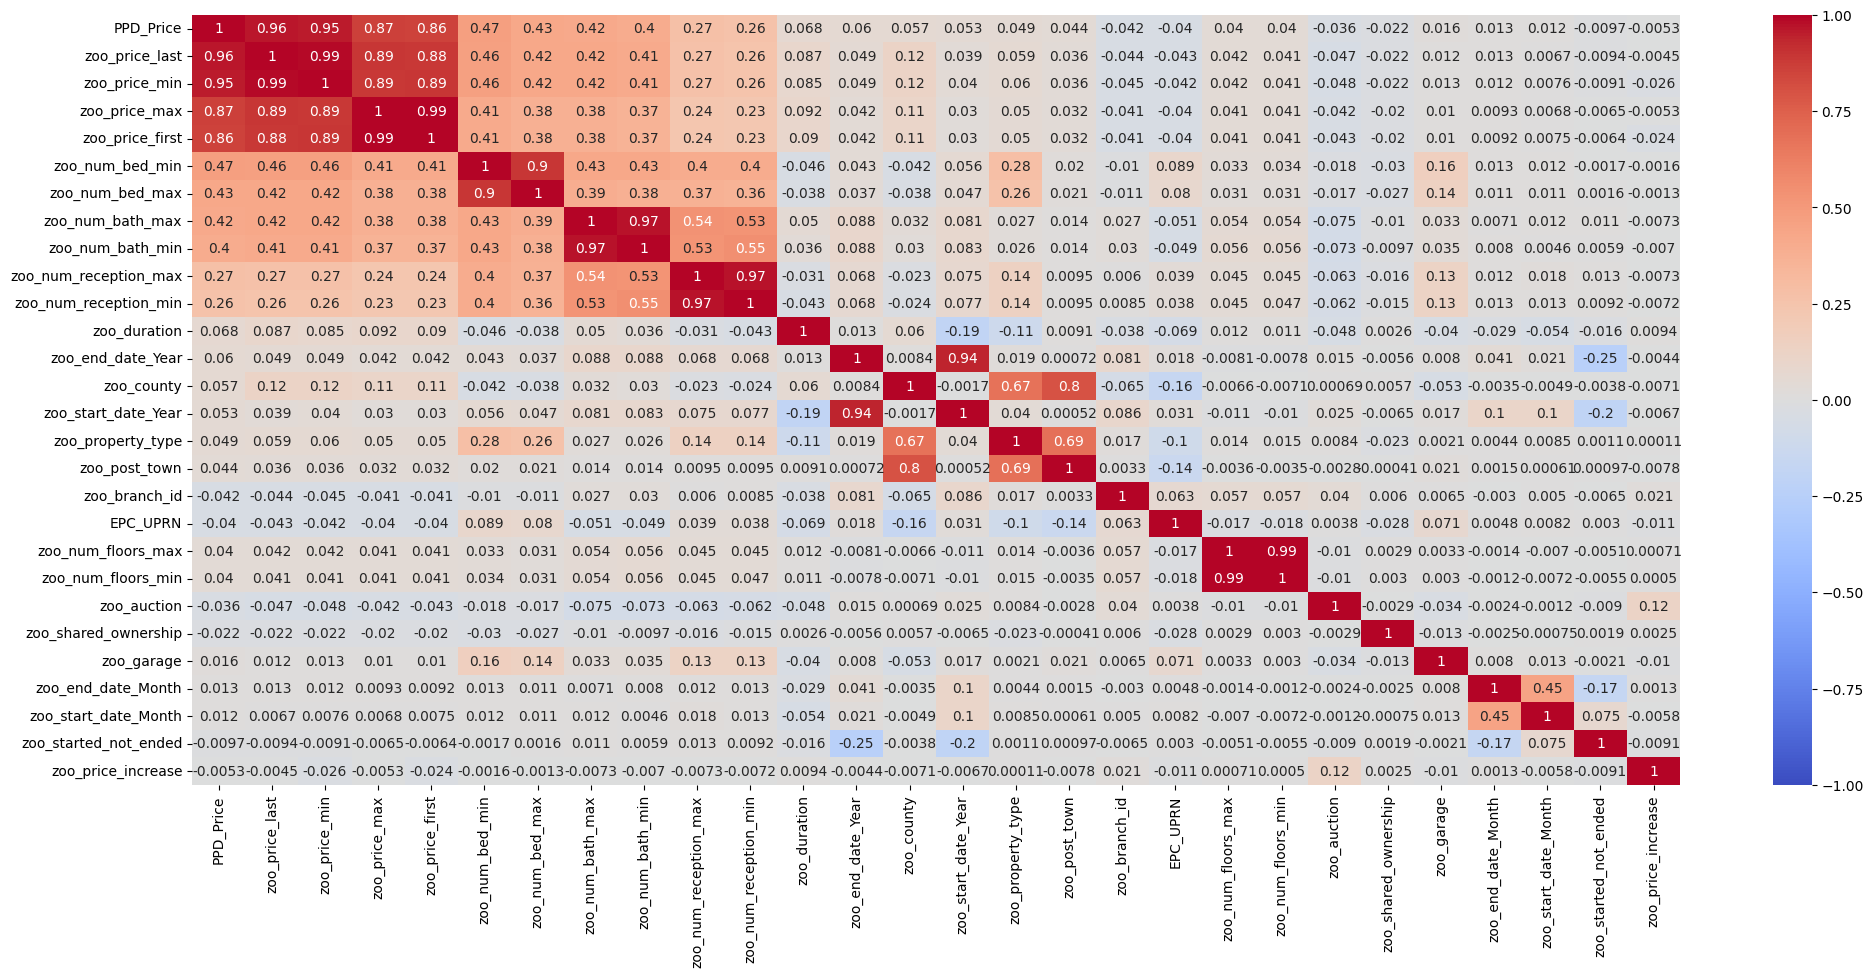

In [24]:
plt.figure(figsize=(24, 10))
zoo_matrix = sorted_corr(encode_columns(preprocess_data(df[zoo_cols + ['PPD_Price']])), 'PPD_Price')
sns.heatmap(zoo_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

Correlation matrix for Public Transport Access data

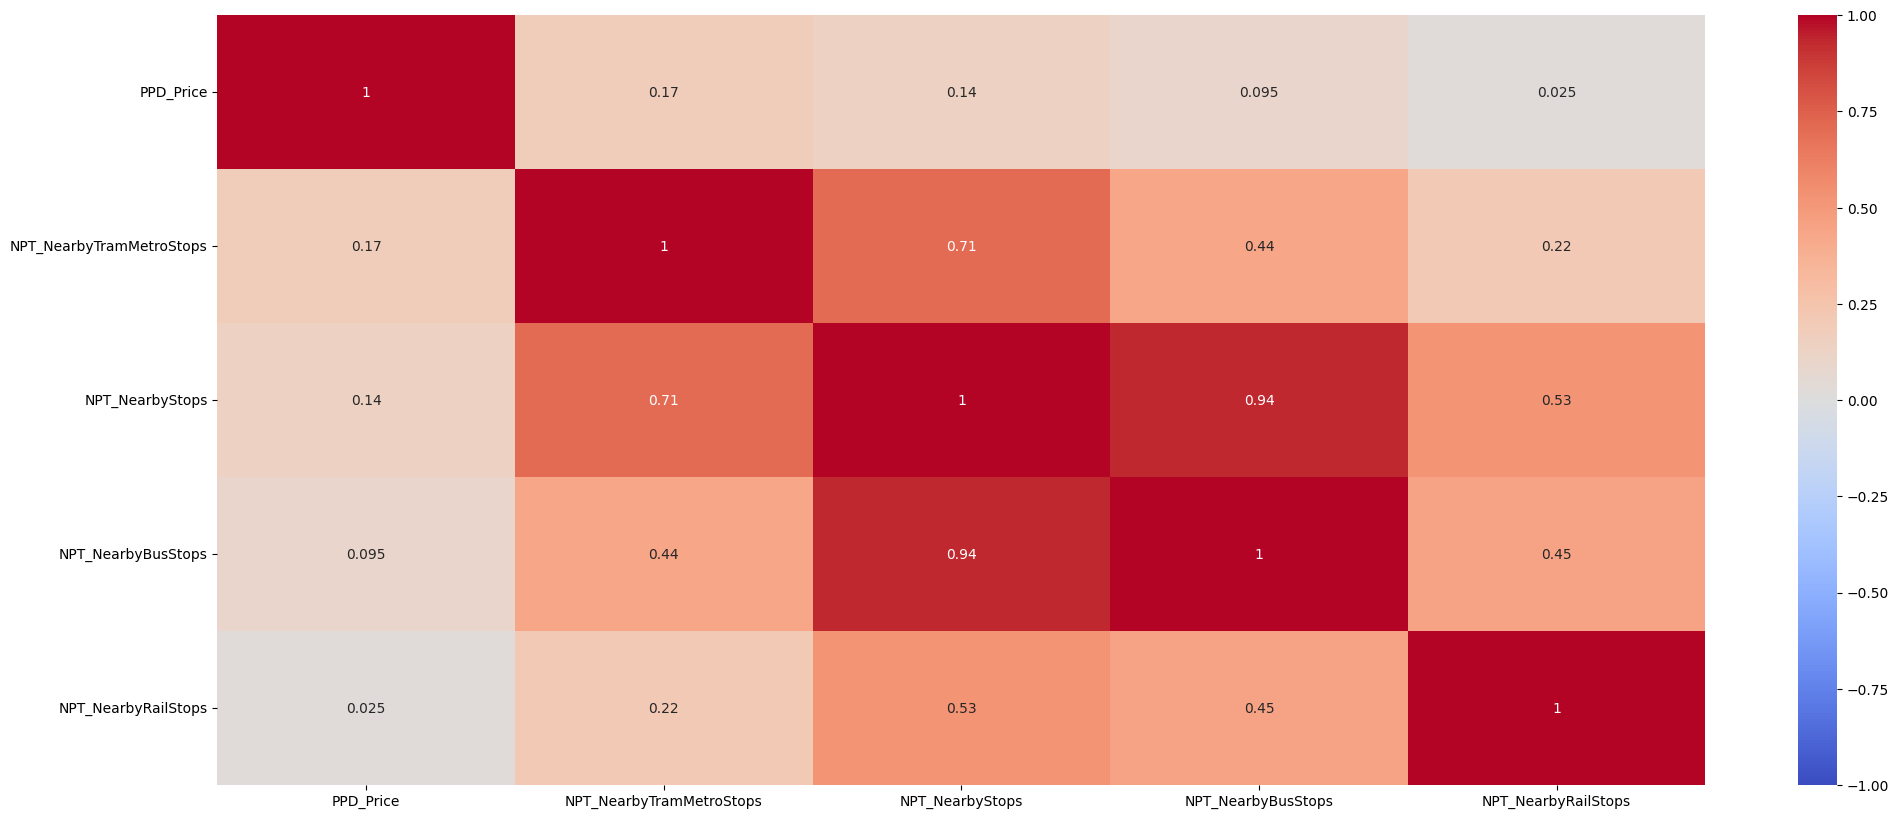

In [25]:
plt.figure(figsize=(24, 10))
transport_matrix = sorted_corr(encode_columns(preprocess_data(df[transport_cols + ['PPD_Price']])), 'PPD_Price')
sns.heatmap(transport_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

Correlation matrix for Public School data

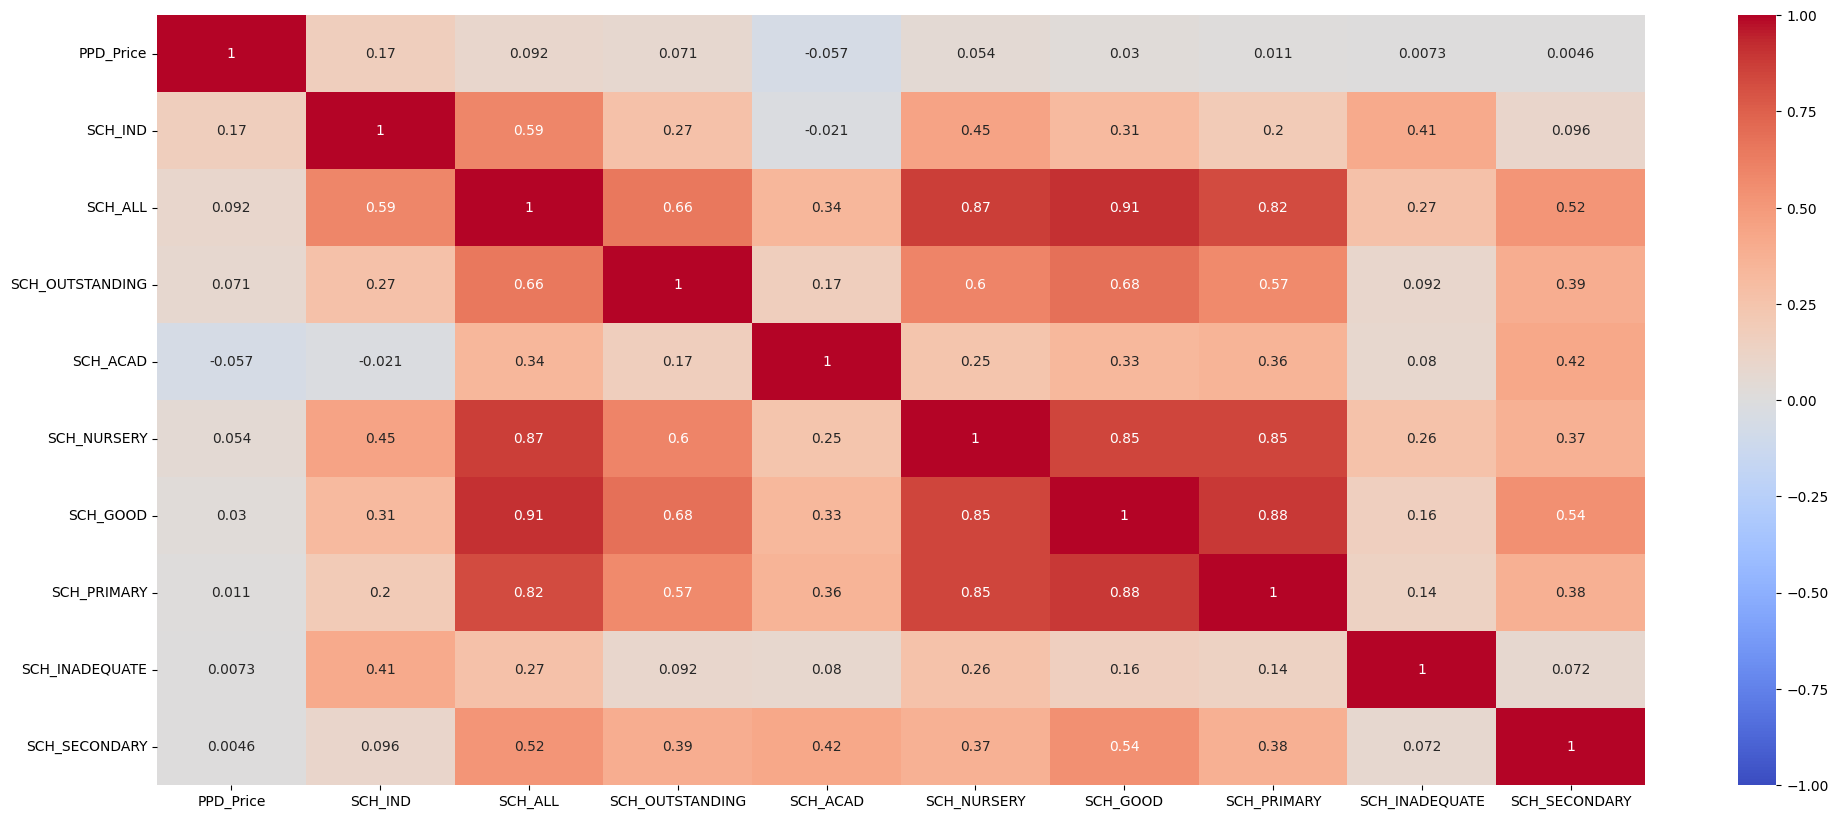

In [26]:
plt.figure(figsize=(24, 10))
school_matrix = sorted_corr(encode_columns(preprocess_data(df[school_cols + ['PPD_Price']])), 'PPD_Price')
sns.heatmap(school_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

Correlation matrix for Green Space Access data

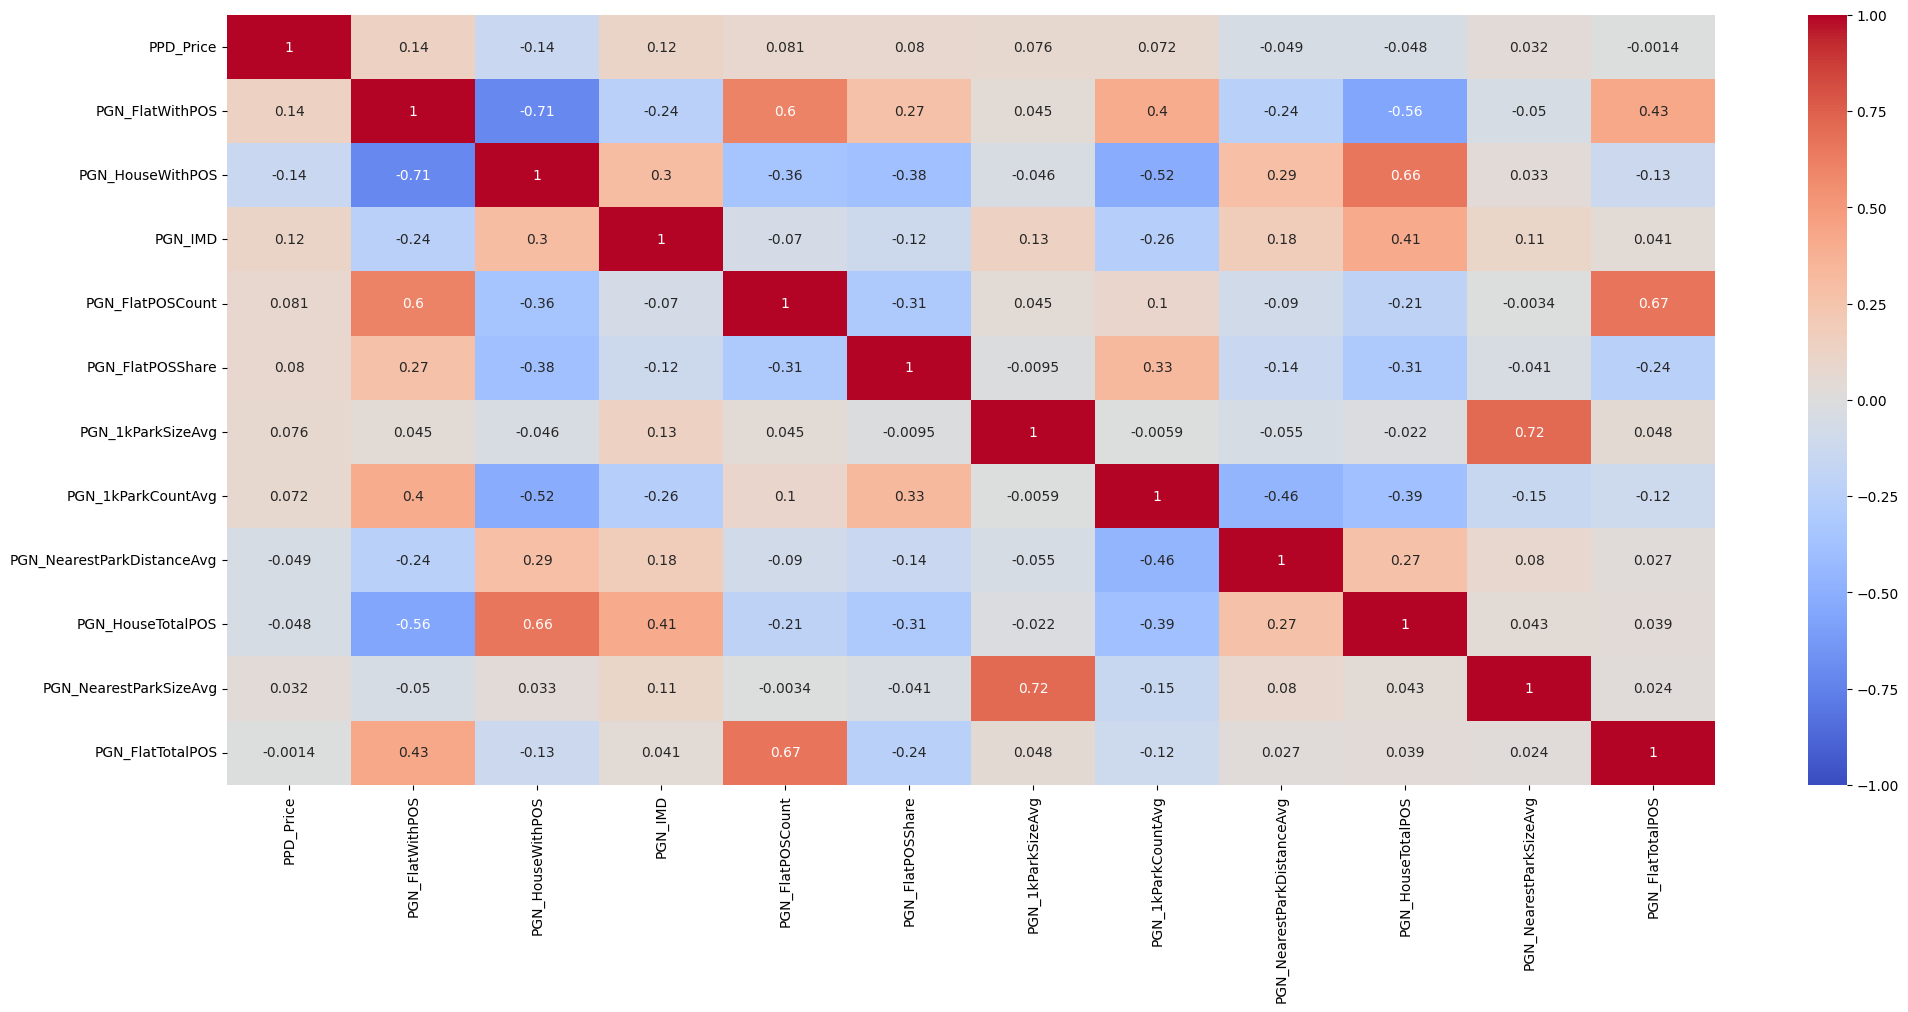

In [27]:
plt.figure(figsize=(24, 10))
space_matrix = sorted_corr(encode_columns(preprocess_data(df[space_cols + ['PPD_Price']])), 'PPD_Price')
sns.heatmap(space_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

Correlation matrix for IMD and Mortgage Rate data

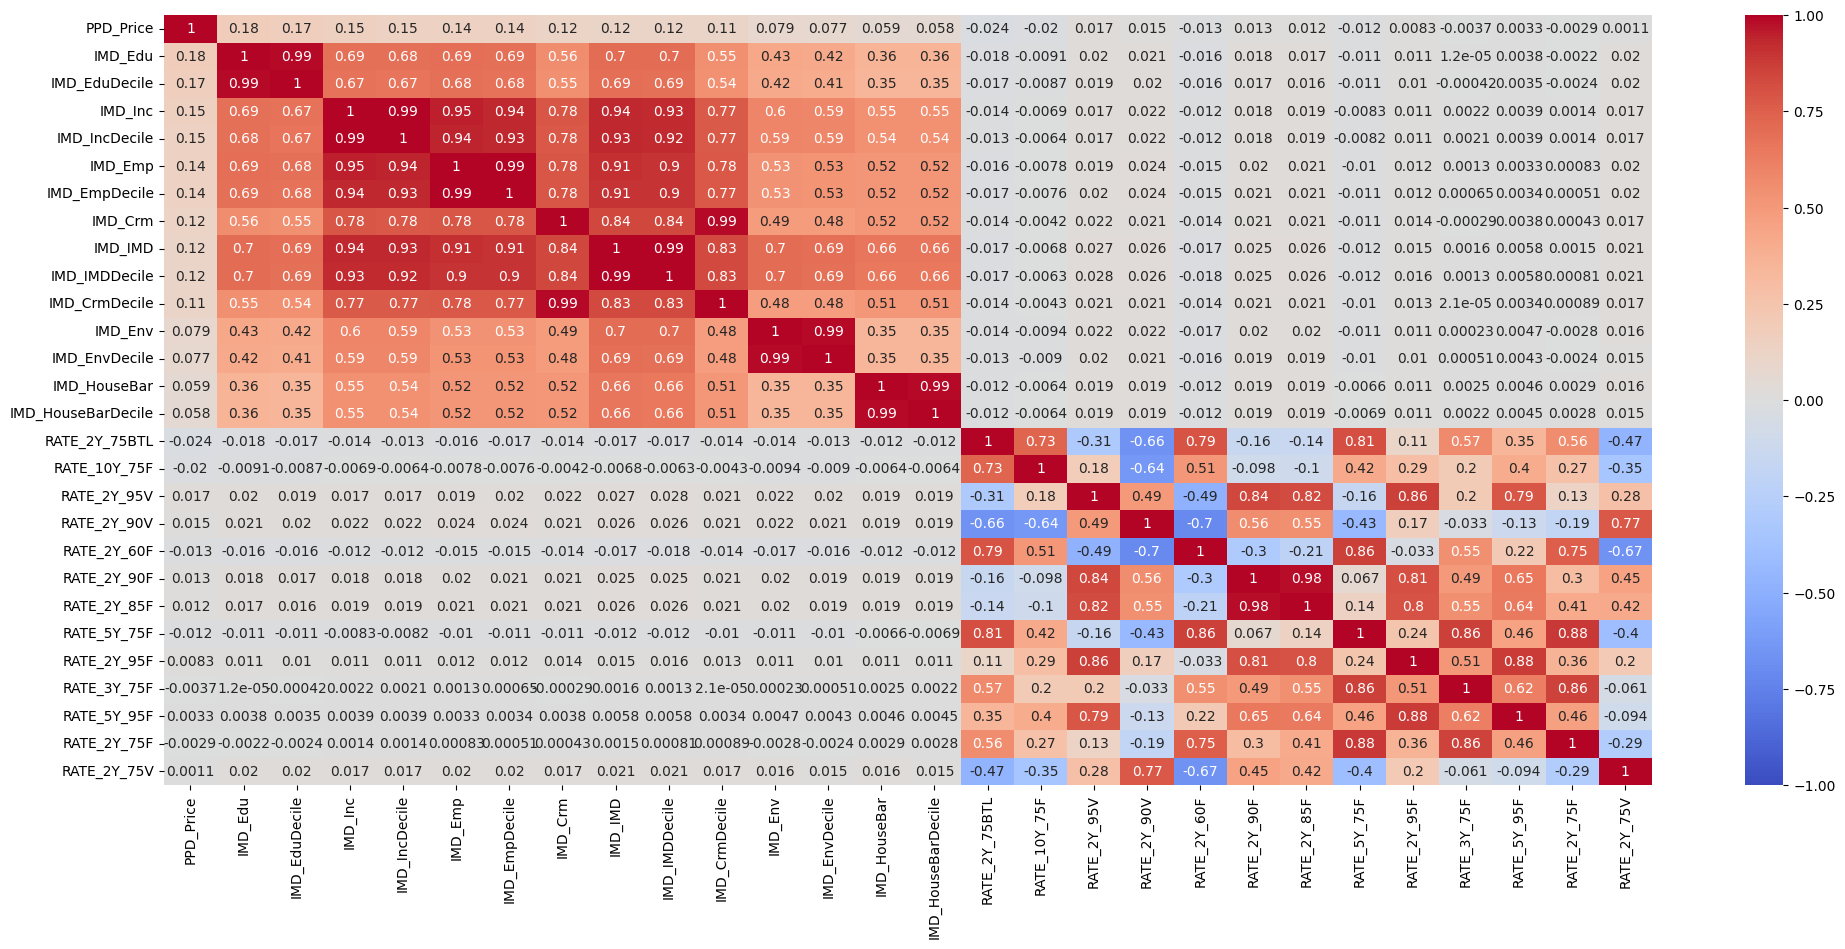

In [28]:
plt.figure(figsize=(24, 10))
imd_matrix = sorted_corr(encode_columns(preprocess_data(df[imd_cols + ['PPD_Price']])), 'PPD_Price')
sns.heatmap(imd_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

Sorted correlations with PPD_Price

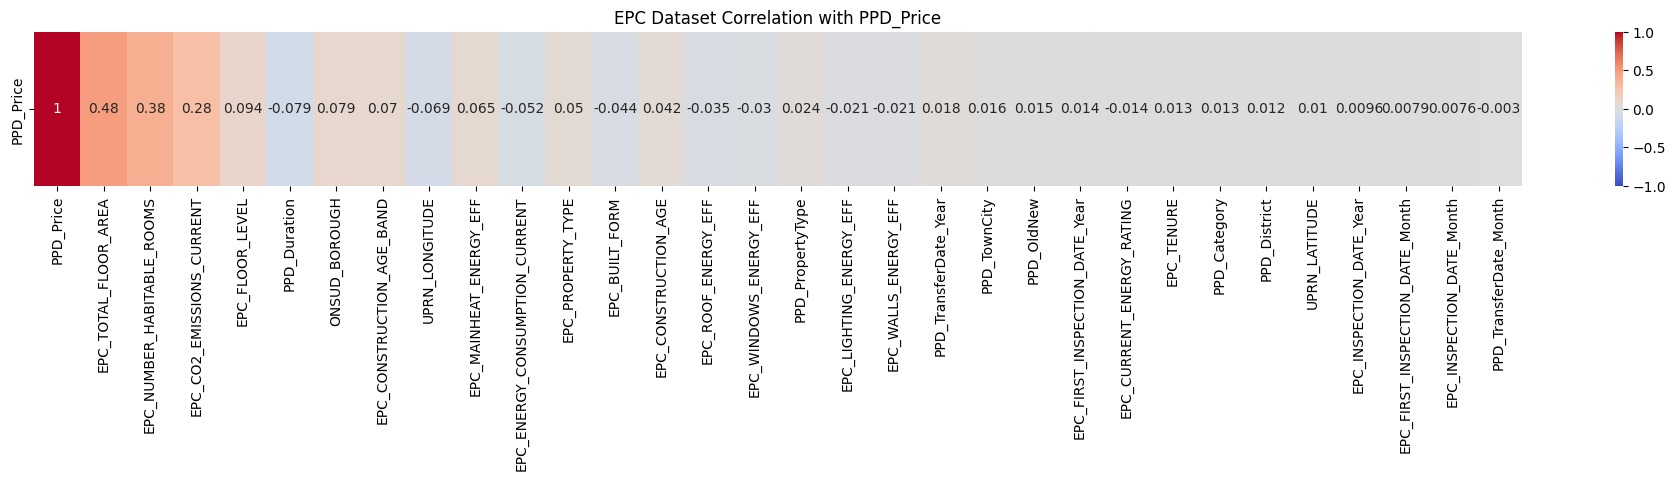

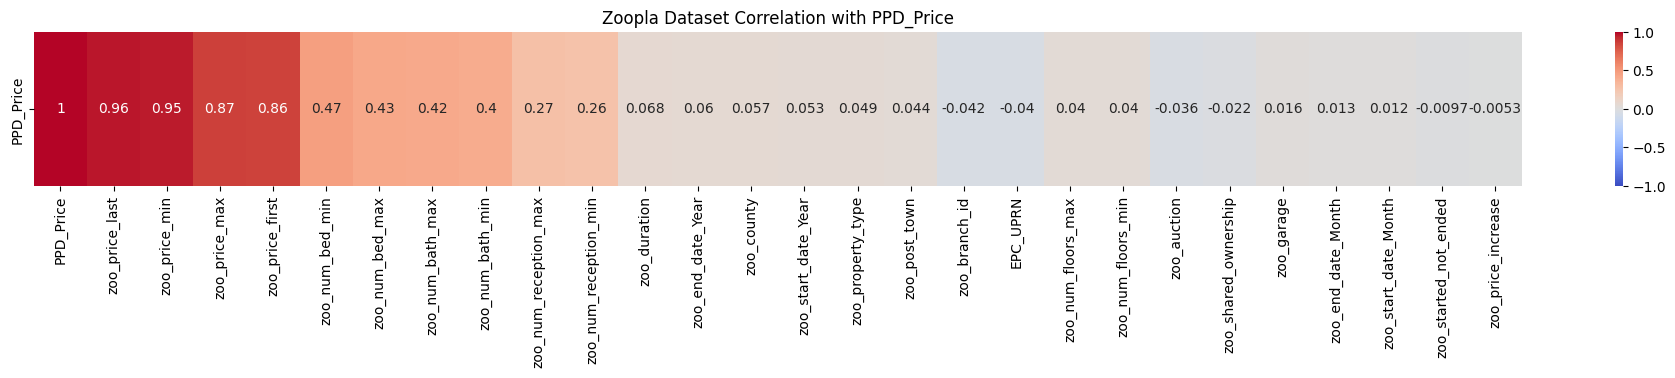

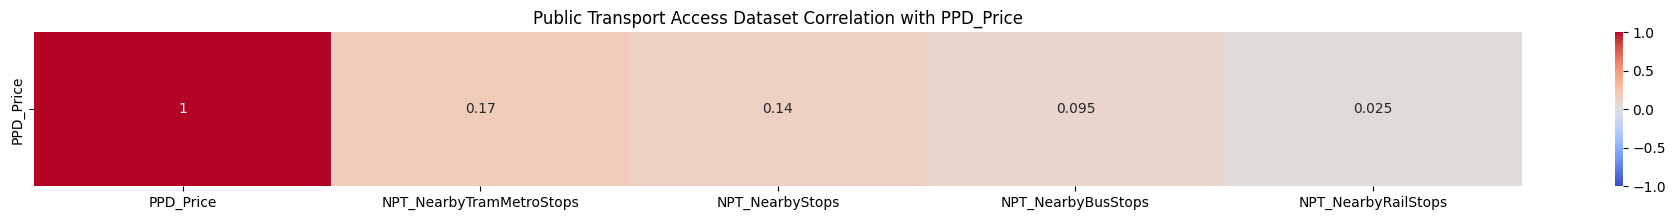

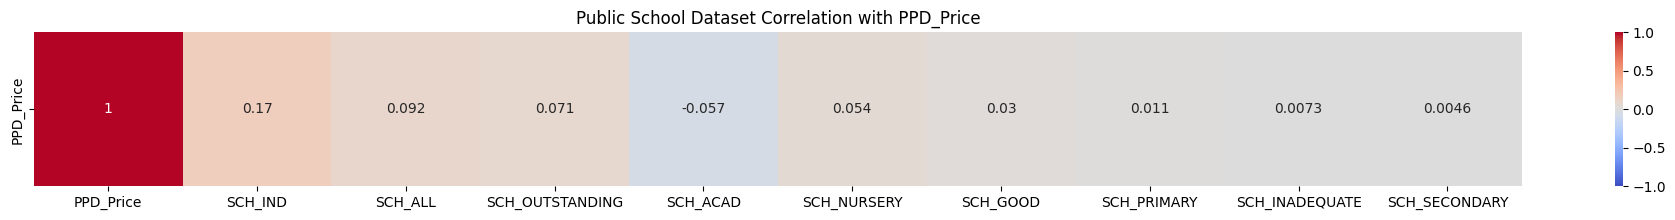

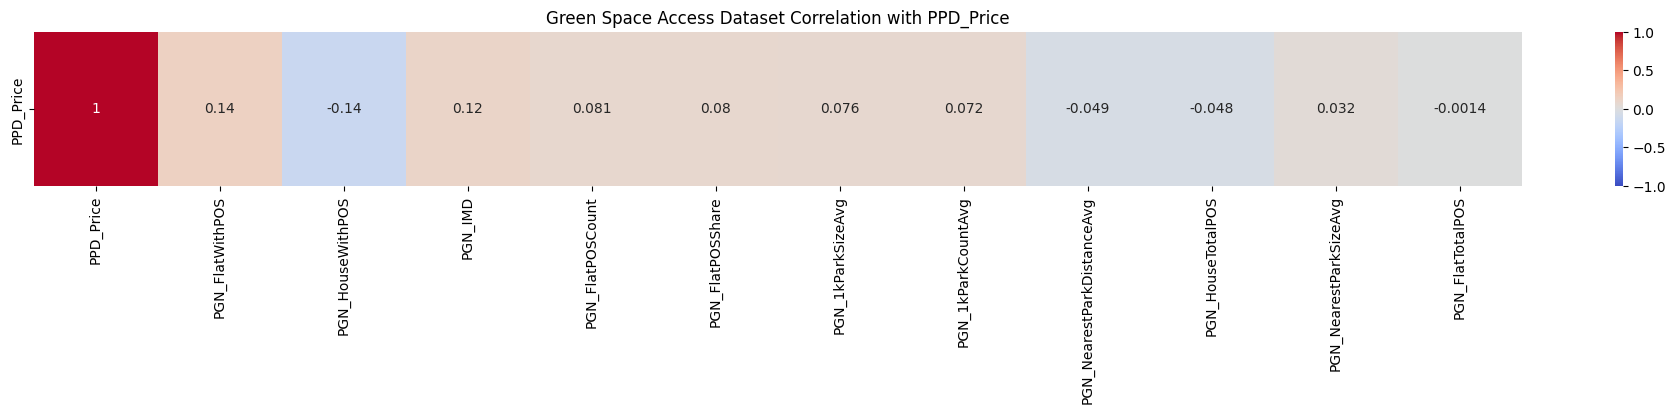

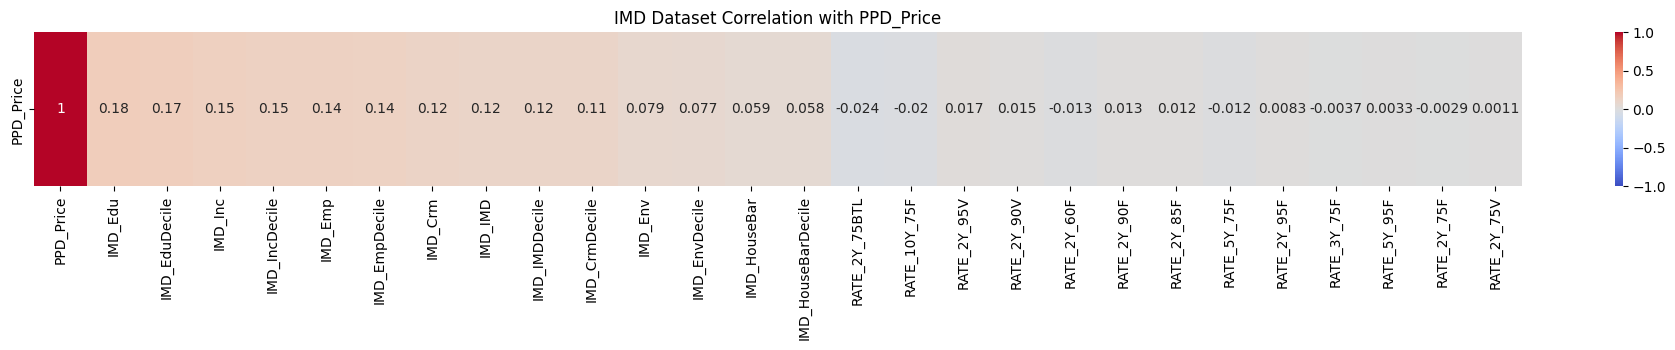

In [29]:
matrices = [epc_matrix, zoo_matrix, transport_matrix, school_matrix, space_matrix, imd_matrix]
titles = ["EPC Dataset", "Zoopla Dataset", "Public Transport Access Dataset", "Public School Dataset", "Green Space Access Dataset", "IMD Dataset"]

for i, (matrix, title) in enumerate(zip(matrices, titles)):
    plt.figure(figsize=(24, 2))
    sns.heatmap(matrix[["PPD_Price"]].T, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f"{title} Correlation with PPD_Price")

Selected features after correlation analysis

In [30]:
selected_df = df[[
  'PPD_Price',
  'PPD_TransferDate',
  'PPD_PropertyType',
  'PPD_OldNew',
  'PPD_Duration',
  'PPD_District',
#   'PPD_TownCity',
  
  'EPC_CURRENT_ENERGY_RATING',
  'EPC_PROPERTY_TYPE',
  'EPC_BUILT_FORM',
  'EPC_ENERGY_CONSUMPTION_CURRENT',
  'EPC_CO2_EMISSIONS_CURRENT',
  'EPC_TOTAL_FLOOR_AREA',
  'EPC_FLOOR_LEVEL',
  'EPC_NUMBER_HABITABLE_ROOMS',
  'EPC_WINDOWS_ENERGY_EFF',
  'EPC_WALLS_ENERGY_EFF',
  'EPC_ROOF_ENERGY_EFF',
  'EPC_MAINHEAT_ENERGY_EFF',
  'EPC_LIGHTING_ENERGY_EFF',
  'EPC_CONSTRUCTION_AGE',
  'EPC_TENURE',

  'zoo_num_bed_min',
  'zoo_num_floors_min',
  'zoo_num_bath_min',
  'zoo_num_reception_min',
  'zoo_duration',
  'zoo_auction',
  'zoo_garage',
  'zoo_shared_ownership',
  'zoo_started_not_ended',

  'NPT_NearbyBusStops',
  'NPT_NearbyTramMetroStops',
  'NPT_NearbyRailStops',
  'NPT_NearbyStops',

  'SCH_ACAD',
  'SCH_IND',
  'SCH_NURSERY',
  'SCH_OUTSTANDING',
  'SCH_GOOD',
  'SCH_ALL',

  'PGN_HouseWithPOS',
  'PGN_HouseTotalPOS',
  'PGN_FlatWithPOS',
  'PGN_FlatTotalPOS',
  'PGN_FlatPOSCount',
  'PGN_FlatPOSShare',
  'PGN_NearestParkDistanceAvg',
  'PGN_NearestParkSizeAvg',
  'PGN_1kParkCountAvg',
  'PGN_1kParkSizeAvg',

  'IMD_IncDecile',
  'IMD_EmpDecile',
  'IMD_EduDecile',
  'IMD_CrmDecile',
  'IMD_HouseBarDecile',
  'IMD_EnvDecile',

  'RATE_2Y_75BTL',

#   'ONSUD_BOROUGH',
#   'ONSUD_WARD',
#   'ONSUD_MSOA',
  'UPRN_LATITUDE',
  'UPRN_LONGITUDE',
]]

prepared_df = selected_df[selected_df['EPC_TOTAL_FLOOR_AREA'] != 0].copy()
prepared_df = remove_outliers_by_lambda(prepared_df, lambda row: row['PPD_Price'] / row['EPC_TOTAL_FLOOR_AREA'])
prepared_df['EPC_FLOOR_LEVEL'] = prepared_df['EPC_FLOOR_LEVEL'].apply(bucket_floor_levels)

# Selected ordinal columns
ppd_duration_col = ['PPD_Duration']
epc_rating_col = ['EPC_CURRENT_ENERGY_RATING']
eff_cols = [col for col in prepared_df.columns if col.endswith('_EFF')]

high_cardinality_cols = get_high_cardinality_features(prepared_df, cardinality_threshold=33)
object_cols = prepared_df.select_dtypes(include=['object']).columns.drop(ppd_duration_col + epc_rating_col + eff_cols + high_cardinality_cols)
numeric_cols = prepared_df.select_dtypes(include=['int64', 'float64']).columns.drop('PPD_Price')
boolean_cols = prepared_df.select_dtypes(include=['bool']).columns
datetime_cols = prepared_df.select_dtypes(include=['datetime64']).columns

X = prepared_df.drop('PPD_Price', axis=1)
y = prepared_df['PPD_Price']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

main_transformers = make_column_transformer(
    (make_pipeline(SimpleImputer(strategy='median'), StandardScaler()), numeric_cols),
    (make_pipeline(SimpleImputer(strategy='most_frequent'), OrdinalEncoder()), ppd_duration_col),
    (make_pipeline(SimpleImputer(strategy='most_frequent'), OrdinalEncoder(categories=[['G', 'F', 'E', 'D', 'C', 'B', 'A']])), epc_rating_col),
    (make_pipeline(SimpleImputer(strategy='most_frequent'), OrdinalEncoder(categories=[['VERY POOR', 'POOR', 'AVERAGE', 'GOOD', 'VERY GOOD']] * len(eff_cols))), eff_cols),
    (make_pipeline(SimpleImputer(strategy='most_frequent'), OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)), high_cardinality_cols),
    (make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='infrequent_if_exist')), object_cols),
    (make_pipeline(BooleanToInteger(), SimpleImputer(strategy='most_frequent')), boolean_cols),
    (DateTimeExtractor(), datetime_cols),
)

pipeline = make_pipeline(
    InvalidValueCleaner(),
    StringCleaner(),
    main_transformers,
)

# Creating pipelines
lr_pipeline = make_pipeline(pipeline, LinearRegression(n_jobs=-1))
rf_pipeline = make_pipeline(pipeline, RandomForestRegressor(n_jobs=-1, random_state=seed))

models = {
    'Linear': lr_pipeline,
    'Random Forest': rf_pipeline,
}

# Fit models
for model in models.values():
    model.fit(X_train, y_train)

# Evaluate models
for name, model in models.items():
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"{name} (r2: {r2:.6f}, mae: {mae:.2f}, rmse: {rmse:.2f})")

Linear (r2: 0.690397, mae: 176379.40, rmse: 336392.11)
Random Forest (r2: 0.875939, mae: 83529.33, rmse: 212941.60)


Linear (r2: 0.657408, mae: 188606.06, rmse: 353860.66)  
Random Forest (r2: 0.868269, mae: 86678.83, rmse: 219425.63)

Linear (r2: 0.648860, mae: 192538.63, rmse: 358247.77)  
Random Forest (r2: 0.865576, mae: 90075.53, rmse: 221657.53)

Linear (r2: 0.633115, mae: 196262.56, rmse: 366191.50)  
Random Forest (r2: 0.807287, mae: 115621.87, rmse: 265398.96)

Linear (r2: 0.615160, mae: 201612.68, rmse: 375045.48)  
Random Forest (r2: 0.763608, mae: 134362.95, rmse: 293940.95)

Linear (r2: 0.581253, mae: 210713.22, rmse: 391218.73)  
Random Forest (r2: 0.685619, mae: 158661.51, rmse: 338978.22)

Linear (r2: 0.579376, mae: 211003.17, rmse: 392094.37)  
Random Forest (r2: 0.680322, mae: 160721.88, rmse: 341821.99)

Improvements in model performance

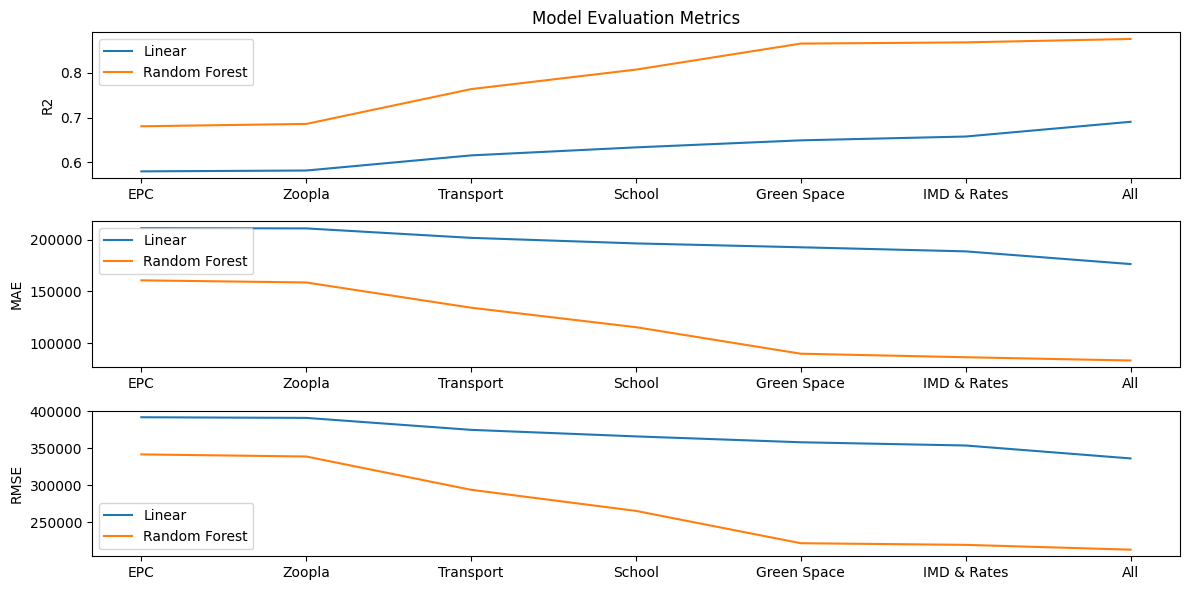

In [31]:
labels = ['EPC', 'Zoopla', 'Transport', 'School', 'Green Space', 'IMD & Rates', 'All']

lr_r2 = [0.579376, 0.581253, 0.615160, 0.633115, 0.648860, 0.657408, 0.690397]
rf_r2 = [0.680322, 0.685619, 0.763608, 0.807287, 0.865576, 0.868269, 0.875939]
lr_mae = [211003.17, 210713.22, 201612.68, 196262.56, 192538.63, 188606.06, 176379.40]
rf_mae = [160721.88, 158661.51, 134362.95, 115621.87, 90075.53, 86678.83, 83529.33]
lr_rmse = [392094.37, 391218.73, 375045.48, 366191.50, 358247.77, 353860.66, 336392.11]
rf_rmse = [341821.99, 338978.22, 293940.95, 265398.96, 221657.53, 219425.63, 212941.60]

fig, ax = plt.subplots(3, 1, figsize=(12, 6))

ax[0].plot(labels, lr_r2, label='Linear')
ax[0].plot(labels, rf_r2, label='Random Forest')
ax[0].set_ylabel('R2')
ax[0].set_title('Model Evaluation Metrics')
ax[0].legend()

ax[1].plot(labels, lr_mae, label='Linear')
ax[1].plot(labels, rf_mae, label='Random Forest')
ax[1].set_ylabel('MAE')
ax[1].legend()

ax[2].plot(labels, lr_rmse, label='Linear')
ax[2].plot(labels, rf_rmse, label='Random Forest')
ax[2].set_ylabel('RMSE')
ax[2].legend()

plt.tight_layout()
plt.show()

Additional engineered features

In [32]:
selected_df = df[[
  'PPD_Price',
  'PPD_TransferDate',
  'PPD_PropertyType',
  'PPD_OldNew',
  'PPD_Duration',
  'PPD_District',
#   'PPD_TownCity',

  'EPC_CURRENT_ENERGY_RATING',
  'EPC_PROPERTY_TYPE',
  'EPC_BUILT_FORM',
  'EPC_ENERGY_CONSUMPTION_CURRENT',
  'EPC_CO2_EMISSIONS_CURRENT',
  'EPC_TOTAL_FLOOR_AREA',
  'EPC_FLOOR_LEVEL',
  'EPC_NUMBER_HABITABLE_ROOMS',
  'EPC_WINDOWS_ENERGY_EFF',
  'EPC_WALLS_ENERGY_EFF',
  'EPC_ROOF_ENERGY_EFF',
  'EPC_MAINHEAT_ENERGY_EFF',
  'EPC_LIGHTING_ENERGY_EFF',
  'EPC_CONSTRUCTION_AGE',
  'EPC_TENURE',

  'zoo_num_bed_min',
  'zoo_num_floors_min',
  'zoo_num_bath_min',
  'zoo_num_reception_min',
  'zoo_duration',
  'zoo_auction',
  'zoo_garage',
  'zoo_shared_ownership',
  'zoo_started_not_ended',

  'NPT_NearbyBusStops',
  'NPT_NearbyTramMetroStops',
  'NPT_NearbyRailStops',
  'NPT_NearbyStops',

  'SCH_ACAD',
  'SCH_IND',
  'SCH_NURSERY',
  'SCH_OUTSTANDING',
  'SCH_GOOD',
  'SCH_ALL',

  'PGN_HouseWithPOS',
  'PGN_HouseTotalPOS',
  'PGN_FlatWithPOS',
  'PGN_FlatTotalPOS',
  'PGN_FlatPOSCount',
  'PGN_FlatPOSShare',
  'PGN_NearestParkDistanceAvg',
  'PGN_NearestParkSizeAvg',
  'PGN_1kParkCountAvg',
  'PGN_1kParkSizeAvg',

  'IMD_IncDecile',
  'IMD_EmpDecile',
  'IMD_EduDecile',
  'IMD_CrmDecile',
  'IMD_HouseBarDecile',
  'IMD_EnvDecile',

  'RATE_2Y_75BTL',

#   'ONSUD_BOROUGH',
#   'ONSUD_WARD',
#   'ONSUD_MSOA',
  'UPRN_LATITUDE',
  'UPRN_LONGITUDE',
]]

prepared_df = selected_df[selected_df['EPC_TOTAL_FLOOR_AREA'] != 0].copy()
prepared_df = remove_outliers_by_lambda(prepared_df, lambda row: row['PPD_Price'] / row['EPC_TOTAL_FLOOR_AREA'])
prepared_df['EPC_FLOOR_LEVEL'] = prepared_df['EPC_FLOOR_LEVEL'].apply(bucket_floor_levels)

# Add custom features
prepared_df = add_custom_features(prepared_df)

# Selected columns
ppd_duration_col = ['PPD_Duration']
epc_rating_col = ['EPC_CURRENT_ENERGY_RATING']
eff_cols = [col for col in prepared_df.columns if col.endswith('_EFF')]

high_cardinality_cols = get_high_cardinality_features(prepared_df, cardinality_threshold=33)
object_cols = prepared_df.select_dtypes(include=['object']).columns.drop(ppd_duration_col + epc_rating_col + eff_cols + high_cardinality_cols)
numeric_cols = prepared_df.select_dtypes(include=['int64', 'float64']).columns.drop('PPD_Price')
boolean_cols = prepared_df.select_dtypes(include=['bool']).columns
datetime_cols = prepared_df.select_dtypes(include=['datetime64']).columns

X = prepared_df.drop('PPD_Price', axis=1)
y = prepared_df['PPD_Price']

# Split data, stratify=prepared_df['PPD_District']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

main_transformers = make_column_transformer(
    (make_pipeline(SimpleImputer(strategy='median'), RobustScaler()), numeric_cols),
    (make_pipeline(SimpleImputer(strategy='most_frequent'), OrdinalEncoder()), ppd_duration_col),
    (make_pipeline(SimpleImputer(strategy='most_frequent'), OrdinalEncoder(categories=[['G', 'F', 'E', 'D', 'C', 'B', 'A']])), epc_rating_col),
    (make_pipeline(SimpleImputer(strategy='most_frequent'), OrdinalEncoder(categories=[['VERY POOR', 'POOR', 'AVERAGE', 'GOOD', 'VERY GOOD']] * len(eff_cols))), eff_cols),
    (make_pipeline(SimpleImputer(strategy='most_frequent'), OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)), high_cardinality_cols),
    (make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='infrequent_if_exist')), object_cols),
    (make_pipeline(BooleanToInteger(), SimpleImputer(strategy='most_frequent')), boolean_cols),
    (DateTimeExtractor(), datetime_cols),
)

pipeline = make_pipeline(
    InvalidValueCleaner(),
    StringCleaner(),
    main_transformers,
)

# Creating pipelines
lr_pipeline = make_pipeline(pipeline, LinearRegression(n_jobs=-1))
rf_pipeline = make_pipeline(pipeline, RandomForestRegressor(n_jobs=-1, random_state=seed))

models = {
    'linear': lr_pipeline,
    'randomForest': rf_pipeline,
}

# Fit models
for model in models.values():
    model.fit(X_train, y_train)

# Evaluate models
for name, model in models.items():
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"{name} (r2: {r2:.6f}, mae: {mae:.2f}, rmse: {rmse:.2f})")  

linear (r2: 0.690368, mae: 176351.10, rmse: 336408.32)
randomForest (r2: 0.875688, mae: 83518.83, rmse: 213157.58)


linear (r2: 0.666723, mae: 137537.33, rmse: 238923.58)  
randomForest (r2: 0.857655, mae: 78474.17, rmse: 156145.00)

linear (r2: 0.662940, mae: 137515.62, rmse: 240275.96)  
randomForest (r2: 0.857681, mae: 78388.58, rmse: 156130.61)

linear (r2: 0.689986, mae: 176716.94, rmse: 336615.57)  
randomForest (r2: 0.873548, mae: 85260.70, rmse: 214983.89)

# Customised KNN Imputation for highly correlated columns

In [33]:
from modules.utils import print_missing_values

selected_df = df[[
  'PPD_Price',
  'PPD_TransferDate',
  'PPD_PropertyType',
  'PPD_OldNew',
  'PPD_Duration',
  'PPD_District',
  # 'PPD_TownCity',

  'EPC_CURRENT_ENERGY_RATING',
  'EPC_PROPERTY_TYPE',
  'EPC_BUILT_FORM',
  'EPC_ENERGY_CONSUMPTION_CURRENT',
  'EPC_CO2_EMISSIONS_CURRENT',
  'EPC_TOTAL_FLOOR_AREA',
  'EPC_FLOOR_LEVEL',
  'EPC_NUMBER_HABITABLE_ROOMS',
  'EPC_WINDOWS_ENERGY_EFF',
  'EPC_WALLS_ENERGY_EFF',
  'EPC_ROOF_ENERGY_EFF',
  'EPC_MAINHEAT_ENERGY_EFF',
  'EPC_LIGHTING_ENERGY_EFF',
  'EPC_CONSTRUCTION_AGE',
  'EPC_TENURE',

  'zoo_num_bed_min',
  'zoo_num_floors_min',
  'zoo_num_bath_min',
  'zoo_num_reception_min',
  'zoo_duration',
  'zoo_auction',
  'zoo_garage',
  'zoo_shared_ownership',
  'zoo_started_not_ended',

  'NPT_NearbyBusStops',
  'NPT_NearbyTramMetroStops',
  'NPT_NearbyRailStops',
  'NPT_NearbyStops',

  'SCH_ACAD',
  'SCH_IND',
  'SCH_NURSERY',
  'SCH_OUTSTANDING',
  'SCH_GOOD',
  'SCH_ALL',

  'PGN_HouseWithPOS',
  'PGN_HouseTotalPOS',
  'PGN_FlatWithPOS',
  'PGN_FlatTotalPOS',
  'PGN_FlatPOSCount',
  'PGN_FlatPOSShare',
  'PGN_NearestParkDistanceAvg',
  'PGN_NearestParkSizeAvg',
  'PGN_1kParkCountAvg',
  'PGN_1kParkSizeAvg',

  'IMD_IncDecile',
  'IMD_EmpDecile',
  'IMD_EduDecile',
  'IMD_CrmDecile',
  'IMD_HouseBarDecile',
  'IMD_EnvDecile',
  
  'RATE_2Y_75BTL',

  # 'ONSUD_BOROUGH',
  # 'ONSUD_WARD',
  # 'ONSUD_MSOA',
  'UPRN_LATITUDE',
  'UPRN_LONGITUDE',
]]

print_missing_values(selected_df)

                            Missing Count  Missing %
zoo_garage                         191575      49.32
zoo_shared_ownership               191575      49.32
zoo_num_bed_min                    191575      49.32
zoo_started_not_ended              191575      49.32
zoo_num_reception_min              191575      49.32
zoo_num_bath_min                   191575      49.32
zoo_auction                        191575      49.32
zoo_duration                       191575      49.32
zoo_num_floors_min                 191575      49.32
EPC_FLOOR_LEVEL                    187858      48.36
EPC_ROOF_ENERGY_EFF                134231      34.56
EPC_NUMBER_HABITABLE_ROOMS          81751      21.05
IMD_HouseBarDecile                  39541      10.18
IMD_EmpDecile                       39541      10.18
IMD_IncDecile                       39541      10.18
IMD_CrmDecile                       39541      10.18
IMD_EnvDecile                       39541      10.18
IMD_EduDecile                       39541     

In [34]:
prepared_df = selected_df[selected_df['EPC_TOTAL_FLOOR_AREA'] != 0].copy()
prepared_df = remove_outliers_by_lambda(prepared_df, lambda row: row['PPD_Price'] / row['EPC_TOTAL_FLOOR_AREA'])
prepared_df['EPC_FLOOR_LEVEL'] = prepared_df['EPC_FLOOR_LEVEL'].apply(bucket_floor_levels)

# Selected columns
ppd_duration_col = ['PPD_Duration']
epc_rating_col = ['EPC_CURRENT_ENERGY_RATING']
eff_cols = [col for col in prepared_df.columns if col.endswith('_EFF')]

high_cardinality_cols = get_high_cardinality_features(prepared_df, cardinality_threshold=33)
object_cols = prepared_df.select_dtypes(include=['object']).columns.drop(ppd_duration_col + epc_rating_col + eff_cols + high_cardinality_cols)
numeric_cols = prepared_df.select_dtypes(include=['int64', 'float64']).columns.drop('PPD_Price')
boolean_cols = prepared_df.select_dtypes(include=['bool']).columns
datetime_cols = prepared_df.select_dtypes(include=['datetime64']).columns

X = prepared_df.drop('PPD_Price', axis=1)
y = prepared_df['PPD_Price']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

# Create custom imputers
customised_imputers = SequentialImputer(
    imputers=[
        ('epc1', CategoryKNNImputer(columns=['EPC_CURRENT_ENERGY_RATING', 'EPC_CO2_EMISSIONS_CURRENT', 'EPC_ENERGY_CONSUMPTION_CURRENT'])),
        ('epc2', CategoryKNNImputer(columns=['EPC_WINDOWS_ENERGY_EFF', 'EPC_CURRENT_ENERGY_RATING', 'EPC_CO2_EMISSIONS_CURRENT', 'EPC_ENERGY_CONSUMPTION_CURRENT'])),
        ('epc3', CategoryKNNImputer(columns=['EPC_WALLS_ENERGY_EFF', 'EPC_CURRENT_ENERGY_RATING', 'EPC_CO2_EMISSIONS_CURRENT', 'EPC_ENERGY_CONSUMPTION_CURRENT'])),
        ('epc4', CategoryKNNImputer(columns=['EPC_MAINHEAT_ENERGY_EFF', 'EPC_CURRENT_ENERGY_RATING', 'EPC_CO2_EMISSIONS_CURRENT', 'EPC_ENERGY_CONSUMPTION_CURRENT'])),
        ('epc5', CategoryKNNImputer(columns=['EPC_LIGHTING_ENERGY_EFF', 'EPC_CURRENT_ENERGY_RATING', 'EPC_CO2_EMISSIONS_CURRENT', 'EPC_ENERGY_CONSUMPTION_CURRENT'])),
        ('epc6', CategoryKNNImputer(columns=['EPC_ROOF_ENERGY_EFF', 'EPC_CURRENT_ENERGY_RATING', 'EPC_CO2_EMISSIONS_CURRENT', 'EPC_ENERGY_CONSUMPTION_CURRENT'])),
        ('epc7', NumericKNNImputer(columns=['EPC_NUMBER_HABITABLE_ROOMS', 'EPC_TOTAL_FLOOR_AREA'], round=True)),
        ('epc8', CategoryKNNImputer(columns=['EPC_BUILT_FORM', 'EPC_PROPERTY_TYPE', 'EPC_TOTAL_FLOOR_AREA', 'EPC_NUMBER_HABITABLE_ROOMS'])),
        ('epc9', CategoryKNNImputer(columns=['EPC_TENURE', 'EPC_PROPERTY_TYPE', 'EPC_BUILT_FORM'])),

        ('zoo1', NumericKNNImputer(columns=['zoo_num_bed_min', 'EPC_PROPERTY_TYPE', 'EPC_BUILT_FORM', 'EPC_NUMBER_HABITABLE_ROOMS', 'EPC_TOTAL_FLOOR_AREA'], round=True)),
        ('zoo2', NumericKNNImputer(columns=['zoo_num_bath_min', 'EPC_PROPERTY_TYPE', 'EPC_BUILT_FORM', 'EPC_NUMBER_HABITABLE_ROOMS', 'EPC_TOTAL_FLOOR_AREA'], round=True)),
        ('zoo3', NumericKNNImputer(columns=['zoo_num_reception_min', 'EPC_PROPERTY_TYPE', 'EPC_BUILT_FORM', 'EPC_NUMBER_HABITABLE_ROOMS', 'EPC_TOTAL_FLOOR_AREA'], round=True)),
        ('zoo4', NumericKNNImputer(columns=['zoo_num_floors_min', 'EPC_PROPERTY_TYPE', 'EPC_BUILT_FORM', 'EPC_NUMBER_HABITABLE_ROOMS', 'EPC_TOTAL_FLOOR_AREA'], round=True)),

        ('green1', NumericKNNImputer(columns=['PGN_HouseTotalPOS', 'UPRN_LATITUDE', 'UPRN_LONGITUDE', 'EPC_PROPERTY_TYPE', 'EPC_BUILT_FORM'])),
        ('green2', NumericKNNImputer(columns=['PGN_HouseWithPOS', 'UPRN_LATITUDE', 'UPRN_LONGITUDE', 'EPC_PROPERTY_TYPE', 'EPC_BUILT_FORM'])),
        ('green3', NumericKNNImputer(columns=['PGN_FlatTotalPOS', 'UPRN_LATITUDE', 'UPRN_LONGITUDE', 'EPC_PROPERTY_TYPE', 'EPC_BUILT_FORM'])),
        ('green4', NumericKNNImputer(columns=['PGN_FlatWithPOS', 'UPRN_LATITUDE', 'UPRN_LONGITUDE', 'EPC_PROPERTY_TYPE', 'EPC_BUILT_FORM'])),
        ('green5', NumericKNNImputer(columns=['PGN_NearestParkDistanceAvg', 'UPRN_LATITUDE', 'UPRN_LONGITUDE'])),
        ('green6', NumericKNNImputer(columns=['PGN_NearestParkSizeAvg', 'UPRN_LATITUDE', 'UPRN_LONGITUDE'])),
        ('green7', NumericKNNImputer(columns=['PGN_1kParkSizeAvg', 'UPRN_LATITUDE', 'UPRN_LONGITUDE'])),
        ('green8', NumericKNNImputer(columns=['PGN_1kParkCountAvg', 'UPRN_LATITUDE', 'UPRN_LONGITUDE'])),

        ('imd1', NumericKNNImputer(columns=['IMD_EduDecile', 'UPRN_LATITUDE', 'UPRN_LONGITUDE'], round=True)),
        ('imd2', NumericKNNImputer(columns=['IMD_IncDecile', 'UPRN_LATITUDE', 'UPRN_LONGITUDE'], round=True)),
        ('imd3', NumericKNNImputer(columns=['IMD_EmpDecile', 'UPRN_LATITUDE', 'UPRN_LONGITUDE'], round=True)),
        ('imd4', NumericKNNImputer(columns=['IMD_CrmDecile', 'UPRN_LATITUDE', 'UPRN_LONGITUDE'], round=True)),
        ('imd5', NumericKNNImputer(columns=['IMD_HouseBarDecile', 'UPRN_LATITUDE', 'UPRN_LONGITUDE'], round=True)),
        ('imd6', NumericKNNImputer(columns=['IMD_EnvDecile', 'UPRN_LATITUDE', 'UPRN_LONGITUDE'], round=True)),
    ]
)

# Impute training and test data
X_train = pd.DataFrame(customised_imputers.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(customised_imputers.transform(X_test), columns=X_train.columns)

# Add custom features
X_train = add_custom_features(X_train)
X_test = add_custom_features(X_test)

main_transformers = make_column_transformer(
    (make_pipeline(SimpleImputer(strategy='median'), RobustScaler()), numeric_cols),
    (OrdinalEncoder(), ppd_duration_col),
    (OrdinalEncoder(categories=[['G', 'F', 'E', 'D', 'C', 'B', 'A']]), epc_rating_col),
    (OrdinalEncoder(categories=[['VERY POOR', 'POOR', 'AVERAGE', 'GOOD', 'VERY GOOD']] * len(eff_cols)), eff_cols),
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), high_cardinality_cols),
    (OneHotEncoder(handle_unknown='infrequent_if_exist'), object_cols),
    (BooleanToInteger(), boolean_cols),
    (DateTimeExtractor(), datetime_cols),
)

pipeline = make_pipeline(
    InvalidValueCleaner(),
    StringCleaner(),
    main_transformers,
)

# Creating pipelines
lr_pipeline = make_pipeline(pipeline, LinearRegression(n_jobs=-1))
rf_pipeline = make_pipeline(pipeline, RandomForestRegressor(n_jobs=-1, random_state=seed))

models = {
    'linear': lr_pipeline,
    'randomForest': rf_pipeline,
}

# Fit models
for model in models.values():
    model.fit(X_train, y_train)

# Evaluate models
for name, model in models.items():
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"{name} (r2: {r2:.6f}, mae: {mae:.2f}, rmse: {rmse:.2f})") 

linear (r2: 0.691009, mae: 175348.80, rmse: 336059.55)
randomForest (r2: 0.876557, mae: 83247.92, rmse: 212410.87)


# Price distribution by borough

The following plots show the distribution of prices by borough.

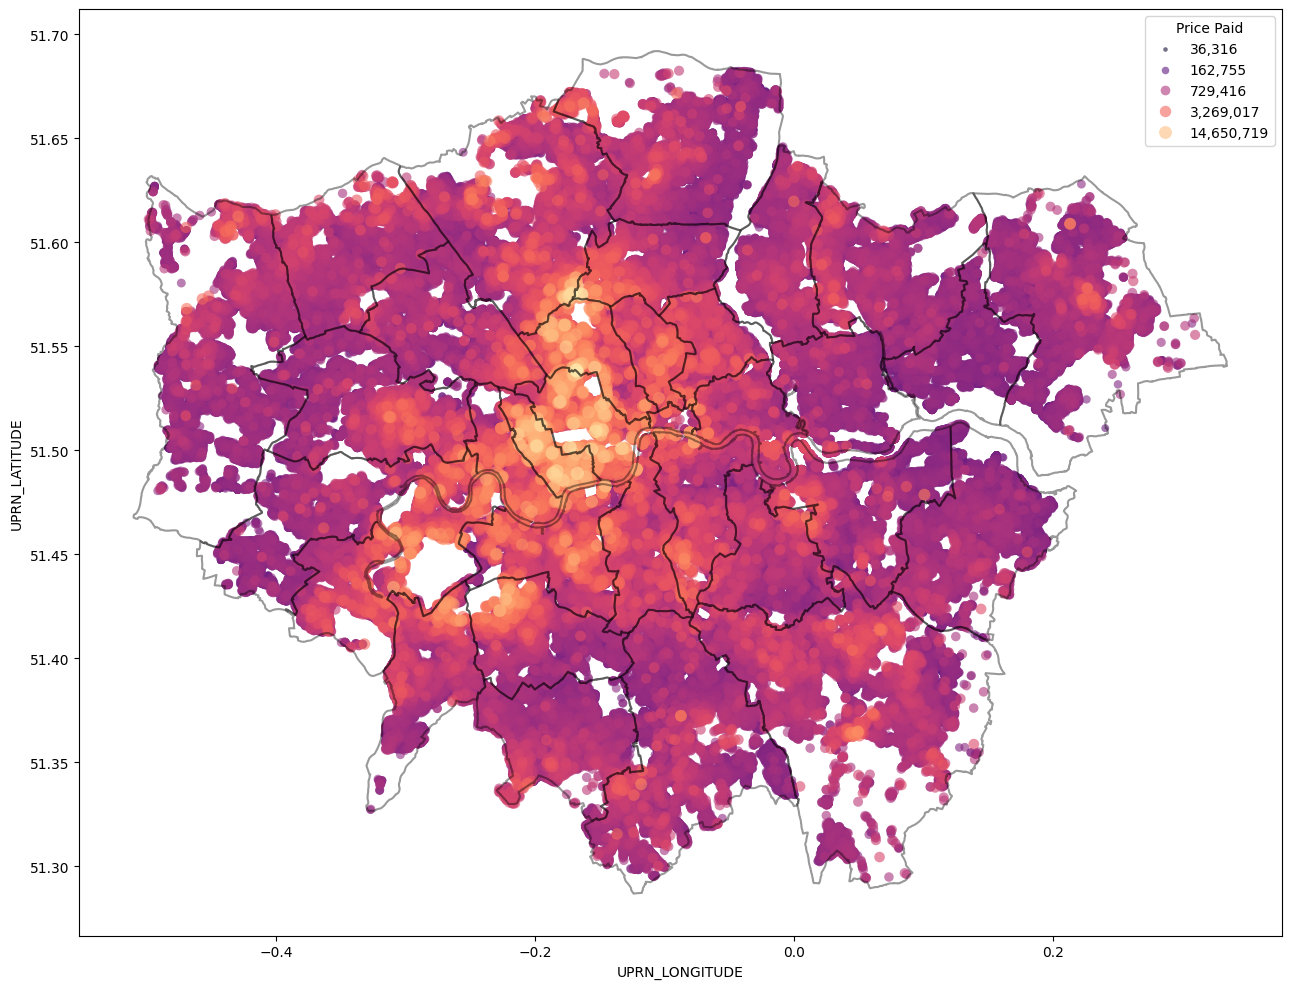

In [35]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

chart_df = prepared_df[['PPD_Price', 'UPRN_LONGITUDE', 'UPRN_LATITUDE']].copy()
chart_df['PPD_Price_Log'] = np.log1p(chart_df['PPD_Price'])

# Load the shapefile, set the CRS, and convert the British National Grid to the Geodetic System (WGS84)
london = gpd.read_file('./data/map/London_Borough_Excluding_MHW.shp').set_crs('EPSG:27700').to_crs('EPSG:4326')
london['edgecolor'] = 'black'

fig, ax = plt.subplots(figsize=(15, 10))
scatter = sns.scatterplot(ax=ax, x='UPRN_LONGITUDE', y='UPRN_LATITUDE', data=chart_df.sort_values('PPD_Price_Log'), 
                          size='PPD_Price_Log', hue='PPD_Price_Log', linewidth=0, alpha=0.6, palette='magma', sizes=(1, 100))
london.boundary.plot(ax=ax, color=None, edgecolor=london['edgecolor'], alpha=0.4)

legend = ax.legend_
legend.set_title("Price Paid")

for t in legend.texts:
    original_price = np.exp(float(t.get_text()))
    t.set_text(f'{round(original_price):,}')

plt.tight_layout()
plt.show()

In [36]:
prepared_df = selected_df[selected_df['EPC_TOTAL_FLOOR_AREA'] != 0].copy()
prepared_df = remove_outliers_by_lambda(prepared_df, lambda row: row['PPD_Price'] / row['EPC_TOTAL_FLOOR_AREA'])
prepared_df['EPC_FLOOR_LEVEL'] = prepared_df['EPC_FLOOR_LEVEL'].apply(bucket_floor_levels)

# Selected columns
ppd_duration_col = ['PPD_Duration']
epc_rating_col = ['EPC_CURRENT_ENERGY_RATING']
eff_cols = [col for col in prepared_df.columns if col.endswith('_EFF')]

high_cardinality_cols = get_high_cardinality_features(prepared_df, cardinality_threshold=33)
object_cols = prepared_df.select_dtypes(include=['object']).columns.drop(ppd_duration_col + epc_rating_col + eff_cols + high_cardinality_cols)
numeric_cols = prepared_df.select_dtypes(include=['int64', 'float64']).columns.drop('PPD_Price')
boolean_cols = prepared_df.select_dtypes(include=['bool']).columns
datetime_cols = prepared_df.select_dtypes(include=['datetime64']).columns

X = prepared_df.drop('PPD_Price', axis=1)
y = prepared_df['PPD_Price']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=prepared_df['PPD_District'], random_state=seed)

# Create custom imputers
customised_imputers = SequentialImputer(
    imputers=[
        ('epc1', CategoryKNNImputer(columns=['EPC_CURRENT_ENERGY_RATING', 'EPC_CO2_EMISSIONS_CURRENT', 'EPC_ENERGY_CONSUMPTION_CURRENT'])),
        ('epc2', CategoryKNNImputer(columns=['EPC_WINDOWS_ENERGY_EFF', 'EPC_CURRENT_ENERGY_RATING', 'EPC_CO2_EMISSIONS_CURRENT', 'EPC_ENERGY_CONSUMPTION_CURRENT'])),
        ('epc3', CategoryKNNImputer(columns=['EPC_WALLS_ENERGY_EFF', 'EPC_CURRENT_ENERGY_RATING', 'EPC_CO2_EMISSIONS_CURRENT', 'EPC_ENERGY_CONSUMPTION_CURRENT'])),
        ('epc4', CategoryKNNImputer(columns=['EPC_MAINHEAT_ENERGY_EFF', 'EPC_CURRENT_ENERGY_RATING', 'EPC_CO2_EMISSIONS_CURRENT', 'EPC_ENERGY_CONSUMPTION_CURRENT'])),
        ('epc5', CategoryKNNImputer(columns=['EPC_LIGHTING_ENERGY_EFF', 'EPC_CURRENT_ENERGY_RATING', 'EPC_CO2_EMISSIONS_CURRENT', 'EPC_ENERGY_CONSUMPTION_CURRENT'])),
        ('epc6', CategoryKNNImputer(columns=['EPC_ROOF_ENERGY_EFF', 'EPC_CURRENT_ENERGY_RATING', 'EPC_CO2_EMISSIONS_CURRENT', 'EPC_ENERGY_CONSUMPTION_CURRENT'])),
        ('epc7', NumericKNNImputer(columns=['EPC_NUMBER_HABITABLE_ROOMS', 'EPC_TOTAL_FLOOR_AREA'], round=True)),
        ('epc8', CategoryKNNImputer(columns=['EPC_BUILT_FORM', 'EPC_PROPERTY_TYPE', 'EPC_TOTAL_FLOOR_AREA', 'EPC_NUMBER_HABITABLE_ROOMS'])),
        ('epc9', CategoryKNNImputer(columns=['EPC_TENURE', 'EPC_PROPERTY_TYPE', 'EPC_BUILT_FORM'])),

        ('zoo1', NumericKNNImputer(columns=['zoo_num_bed_min', 'EPC_PROPERTY_TYPE', 'EPC_BUILT_FORM', 'EPC_NUMBER_HABITABLE_ROOMS', 'EPC_TOTAL_FLOOR_AREA'], round=True)),
        ('zoo2', NumericKNNImputer(columns=['zoo_num_bath_min', 'EPC_PROPERTY_TYPE', 'EPC_BUILT_FORM', 'EPC_NUMBER_HABITABLE_ROOMS', 'EPC_TOTAL_FLOOR_AREA'], round=True)),
        ('zoo3', NumericKNNImputer(columns=['zoo_num_reception_min', 'EPC_PROPERTY_TYPE', 'EPC_BUILT_FORM', 'EPC_NUMBER_HABITABLE_ROOMS', 'EPC_TOTAL_FLOOR_AREA'], round=True)),
        ('zoo4', NumericKNNImputer(columns=['zoo_num_floors_min', 'EPC_PROPERTY_TYPE', 'EPC_BUILT_FORM', 'EPC_NUMBER_HABITABLE_ROOMS', 'EPC_TOTAL_FLOOR_AREA'], round=True)),

        ('green1', NumericKNNImputer(columns=['PGN_HouseTotalPOS', 'UPRN_LATITUDE', 'UPRN_LONGITUDE', 'EPC_PROPERTY_TYPE', 'EPC_BUILT_FORM'])),
        ('green2', NumericKNNImputer(columns=['PGN_HouseWithPOS', 'UPRN_LATITUDE', 'UPRN_LONGITUDE', 'EPC_PROPERTY_TYPE', 'EPC_BUILT_FORM'])),
        ('green3', NumericKNNImputer(columns=['PGN_FlatTotalPOS', 'UPRN_LATITUDE', 'UPRN_LONGITUDE', 'EPC_PROPERTY_TYPE', 'EPC_BUILT_FORM'])),
        ('green4', NumericKNNImputer(columns=['PGN_FlatWithPOS', 'UPRN_LATITUDE', 'UPRN_LONGITUDE', 'EPC_PROPERTY_TYPE', 'EPC_BUILT_FORM'])),
        ('green5', NumericKNNImputer(columns=['PGN_NearestParkSizeAvg', 'UPRN_LATITUDE', 'UPRN_LONGITUDE'])),
        ('green6', NumericKNNImputer(columns=['PGN_1kParkSizeAvg', 'UPRN_LATITUDE', 'UPRN_LONGITUDE'])),
        ('green7', NumericKNNImputer(columns=['PGN_1kParkCountAvg', 'UPRN_LATITUDE', 'UPRN_LONGITUDE'])),

        ('imd1', NumericKNNImputer(columns=['IMD_EduDecile', 'UPRN_LATITUDE', 'UPRN_LONGITUDE'], round=True)),
        ('imd2', NumericKNNImputer(columns=['IMD_IncDecile', 'UPRN_LATITUDE', 'UPRN_LONGITUDE'], round=True)),
        ('imd3', NumericKNNImputer(columns=['IMD_EmpDecile', 'UPRN_LATITUDE', 'UPRN_LONGITUDE'], round=True)),
        ('imd4', NumericKNNImputer(columns=['IMD_CrmDecile', 'UPRN_LATITUDE', 'UPRN_LONGITUDE'], round=True)),
        ('imd5', NumericKNNImputer(columns=['IMD_HouseBarDecile', 'UPRN_LATITUDE', 'UPRN_LONGITUDE'], round=True)),
        ('imd6', NumericKNNImputer(columns=['IMD_EnvDecile', 'UPRN_LATITUDE', 'UPRN_LONGITUDE'], round=True)),
    ]
)

# Impute training and test data
X_train = pd.DataFrame(customised_imputers.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(customised_imputers.transform(X_test), columns=X_train.columns)

# Add custom features
X_train = add_custom_features(X_train)
X_test = add_custom_features(X_test)

main_transformers = make_column_transformer(
    (make_pipeline(SimpleImputer(strategy='median'), RobustScaler()), numeric_cols),
    (OrdinalEncoder(), ppd_duration_col),
    (OrdinalEncoder(categories=[['G', 'F', 'E', 'D', 'C', 'B', 'A']]), epc_rating_col),
    (OrdinalEncoder(categories=[['VERY POOR', 'POOR', 'AVERAGE', 'GOOD', 'VERY GOOD']] * len(eff_cols)), eff_cols),
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), high_cardinality_cols),
    (OneHotEncoder(handle_unknown='infrequent_if_exist'), object_cols),
    (BooleanToInteger(), boolean_cols),
    (DateTimeExtractor(), datetime_cols),
)

pipeline = make_pipeline(
    InvalidValueCleaner(),
    StringCleaner(),
    main_transformers,
)

# Creating pipelines
lr_pipeline = make_pipeline(pipeline, LinearRegression(n_jobs=-1))
rf_pipeline = make_pipeline(pipeline, RandomForestRegressor(n_jobs=-1, random_state=seed))

models = {
    'linear': lr_pipeline,
    'randomForest': rf_pipeline,
}

# Fit models
for model in models.values():
    model.fit(X_train, y_train)

# Evaluate models
for name, model in models.items():
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"{name} (r2: {r2:.6f}, mae: {mae:.2f}, rmse: {rmse:.2f})")

linear (r2: 0.748603, mae: 132369.18, rmse: 230633.72)
randomForest (r2: 0.887794, mae: 71974.96, rmse: 154081.76)


# Regularisation and multicollinearity: identify and remove highly correlated features

In [249]:
selected_df = df[[
  'PPD_Price',
  'PPD_TransferDate',
  'PPD_PropertyType',
  'PPD_OldNew',
  'PPD_Duration',
  'PPD_District',
#   'PPD_TownCity',

  'EPC_CURRENT_ENERGY_RATING',
  'EPC_PROPERTY_TYPE',
  'EPC_BUILT_FORM',
  'EPC_ENERGY_CONSUMPTION_CURRENT',
  'EPC_CO2_EMISSIONS_CURRENT',
  'EPC_TOTAL_FLOOR_AREA',
  'EPC_FLOOR_LEVEL',
  'EPC_NUMBER_HABITABLE_ROOMS',
  'EPC_WINDOWS_ENERGY_EFF',
  'EPC_WALLS_ENERGY_EFF',
  'EPC_ROOF_ENERGY_EFF',
  'EPC_MAINHEAT_ENERGY_EFF',
  'EPC_LIGHTING_ENERGY_EFF',
  'EPC_CONSTRUCTION_AGE',
  # 'EPC_TENURE',#

  'zoo_num_bed_min',
  # 'zoo_num_floors_min',#
  'zoo_num_bath_min',
  'zoo_num_reception_min',
  'zoo_duration',
  'zoo_auction',
  'zoo_garage',
#   'zoo_shared_ownership',
  # 'zoo_started_not_ended',#

  'NPT_NearbyBusStops',
  'NPT_NearbyTramMetroStops',
  'NPT_NearbyRailStops',
  # 'NPT_NearbyStops',#

  'SCH_ACAD',
  'SCH_IND',
  'SCH_NURSERY',
  'SCH_OUTSTANDING',
  'SCH_GOOD',
  # 'SCH_ALL',#

  'PGN_HouseWithPOS',
  'PGN_HouseTotalPOS',
  'PGN_FlatWithPOS',
  'PGN_FlatTotalPOS',
  'PGN_FlatPOSCount',
  'PGN_FlatPOSShare',
  # 'PGN_NearestParkDistanceAvg',#
  # 'PGN_NearestParkSizeAvg',#
  'PGN_1kParkCountAvg',
  'PGN_1kParkSizeAvg',

  'IMD_IncDecile',
  'IMD_EmpDecile',
  'IMD_EduDecile',
  'IMD_CrmDecile',
  # 'IMD_HouseBarDecile',#
  'IMD_EnvDecile',

  'RATE_2Y_75BTL',

  # 'ONSUD_BOROUGH',
  # 'ONSUD_WARD',
  # 'ONSUD_MSOA',
  'UPRN_LATITUDE',
  'UPRN_LONGITUDE',
]]

prepared_df = selected_df[selected_df['EPC_TOTAL_FLOOR_AREA'] != 0].copy()
prepared_df = remove_outliers_by_lambda(prepared_df, lambda row: row['PPD_Price'] / row['EPC_TOTAL_FLOOR_AREA'])
prepared_df['EPC_FLOOR_LEVEL'] = prepared_df['EPC_FLOOR_LEVEL'].apply(bucket_floor_levels)

# Selected columns
ppd_duration_col = ['PPD_Duration']
epc_rating_col = ['EPC_CURRENT_ENERGY_RATING']
eff_cols = [col for col in prepared_df.columns if col.endswith('_EFF')]

high_cardinality_cols = get_high_cardinality_features(prepared_df, cardinality_threshold=33)
object_cols = prepared_df.select_dtypes(include=['object']).columns.drop(ppd_duration_col + epc_rating_col + eff_cols + high_cardinality_cols)
numeric_cols = prepared_df.select_dtypes(include=['int64', 'float64']).columns.drop('PPD_Price')
boolean_cols = prepared_df.select_dtypes(include=['bool']).columns
datetime_cols = prepared_df.select_dtypes(include=['datetime64']).columns

X = prepared_df.drop('PPD_Price', axis=1)
y = prepared_df['PPD_Price']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=prepared_df['PPD_District'], random_state=seed)

# Create custom imputers
customised_imputers = SequentialImputer(
    imputers=[
        ('epc1', CategoryKNNImputer(columns=['EPC_CURRENT_ENERGY_RATING', 'EPC_CO2_EMISSIONS_CURRENT', 'EPC_ENERGY_CONSUMPTION_CURRENT'])),
        ('epc2', CategoryKNNImputer(columns=['EPC_WINDOWS_ENERGY_EFF', 'EPC_CURRENT_ENERGY_RATING', 'EPC_CO2_EMISSIONS_CURRENT', 'EPC_ENERGY_CONSUMPTION_CURRENT'])),
        ('epc3', CategoryKNNImputer(columns=['EPC_WALLS_ENERGY_EFF', 'EPC_CURRENT_ENERGY_RATING', 'EPC_CO2_EMISSIONS_CURRENT', 'EPC_ENERGY_CONSUMPTION_CURRENT'])),
        ('epc4', CategoryKNNImputer(columns=['EPC_MAINHEAT_ENERGY_EFF', 'EPC_CURRENT_ENERGY_RATING', 'EPC_CO2_EMISSIONS_CURRENT', 'EPC_ENERGY_CONSUMPTION_CURRENT'])),
        ('epc5', CategoryKNNImputer(columns=['EPC_LIGHTING_ENERGY_EFF', 'EPC_CURRENT_ENERGY_RATING', 'EPC_CO2_EMISSIONS_CURRENT', 'EPC_ENERGY_CONSUMPTION_CURRENT'])),
        ('epc6', CategoryKNNImputer(columns=['EPC_ROOF_ENERGY_EFF', 'EPC_CURRENT_ENERGY_RATING', 'EPC_CO2_EMISSIONS_CURRENT', 'EPC_ENERGY_CONSUMPTION_CURRENT'])),
        ('epc7', NumericKNNImputer(columns=['EPC_NUMBER_HABITABLE_ROOMS', 'EPC_TOTAL_FLOOR_AREA'], round=True)),
        ('epc8', CategoryKNNImputer(columns=['EPC_BUILT_FORM', 'EPC_PROPERTY_TYPE', 'EPC_TOTAL_FLOOR_AREA', 'EPC_NUMBER_HABITABLE_ROOMS'])),
        # ('epc9', CategoryKNNImputer(columns=['EPC_TENURE', 'EPC_PROPERTY_TYPE', 'EPC_BUILT_FORM'])),

        ('zoo1', NumericKNNImputer(columns=['zoo_num_bed_min', 'EPC_PROPERTY_TYPE', 'EPC_BUILT_FORM', 'EPC_NUMBER_HABITABLE_ROOMS', 'EPC_TOTAL_FLOOR_AREA'], round=True)),
        ('zoo2', NumericKNNImputer(columns=['zoo_num_bath_min', 'EPC_PROPERTY_TYPE', 'EPC_BUILT_FORM', 'EPC_NUMBER_HABITABLE_ROOMS', 'EPC_TOTAL_FLOOR_AREA'], round=True)),
        ('zoo3', NumericKNNImputer(columns=['zoo_num_reception_min', 'EPC_PROPERTY_TYPE', 'EPC_BUILT_FORM', 'EPC_NUMBER_HABITABLE_ROOMS', 'EPC_TOTAL_FLOOR_AREA'], round=True)),
        # ('zoo4', NumericKNNImputer(columns=['zoo_num_floors_min', 'EPC_PROPERTY_TYPE', 'EPC_BUILT_FORM', 'EPC_NUMBER_HABITABLE_ROOMS', 'EPC_TOTAL_FLOOR_AREA'], round=True)),

        ('green1', NumericKNNImputer(columns=['PGN_HouseTotalPOS', 'UPRN_LATITUDE', 'UPRN_LONGITUDE', 'EPC_PROPERTY_TYPE', 'EPC_BUILT_FORM'])),
        ('green2', NumericKNNImputer(columns=['PGN_HouseWithPOS', 'UPRN_LATITUDE', 'UPRN_LONGITUDE', 'EPC_PROPERTY_TYPE', 'EPC_BUILT_FORM'])),
        ('green3', NumericKNNImputer(columns=['PGN_FlatTotalPOS', 'UPRN_LATITUDE', 'UPRN_LONGITUDE', 'EPC_PROPERTY_TYPE', 'EPC_BUILT_FORM'])),
        ('green4', NumericKNNImputer(columns=['PGN_FlatWithPOS', 'UPRN_LATITUDE', 'UPRN_LONGITUDE', 'EPC_PROPERTY_TYPE', 'EPC_BUILT_FORM'])),
        # ('green5', NumericKNNImputer(columns=['PGN_NearestParkDistanceAvg', 'UPRN_LATITUDE', 'UPRN_LONGITUDE'])),
        # ('green6', NumericKNNImputer(columns=['PGN_NearestParkSizeAvg', 'UPRN_LATITUDE', 'UPRN_LONGITUDE'])),
        ('green7', NumericKNNImputer(columns=['PGN_1kParkSizeAvg', 'UPRN_LATITUDE', 'UPRN_LONGITUDE'])),
        ('green8', NumericKNNImputer(columns=['PGN_1kParkCountAvg', 'UPRN_LATITUDE', 'UPRN_LONGITUDE'])),

        ('imd1', NumericKNNImputer(columns=['IMD_EduDecile', 'UPRN_LATITUDE', 'UPRN_LONGITUDE'], round=True)),
        ('imd2', NumericKNNImputer(columns=['IMD_IncDecile', 'UPRN_LATITUDE', 'UPRN_LONGITUDE'], round=True)),
        ('imd3', NumericKNNImputer(columns=['IMD_EmpDecile', 'UPRN_LATITUDE', 'UPRN_LONGITUDE'], round=True)),
        ('imd4', NumericKNNImputer(columns=['IMD_CrmDecile', 'UPRN_LATITUDE', 'UPRN_LONGITUDE'], round=True)),
        # ('imd5', NumericKNNImputer(columns=['IMD_HouseBarDecile', 'UPRN_LATITUDE', 'UPRN_LONGITUDE'], round=True)),
        ('imd6', NumericKNNImputer(columns=['IMD_EnvDecile', 'UPRN_LATITUDE', 'UPRN_LONGITUDE'], round=True)),
    ]
)

# Impute training and test data
X_train = pd.DataFrame(customised_imputers.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(customised_imputers.transform(X_test), columns=X_train.columns)

# Add custom features
X_train = add_custom_features(X_train)
X_test = add_custom_features(X_test)

main_transformers = make_column_transformer(
    (make_pipeline(SimpleImputer(strategy='median'), RobustScaler()), numeric_cols),
    (OrdinalEncoder(), ppd_duration_col),
    (OrdinalEncoder(categories=[['G', 'F', 'E', 'D', 'C', 'B', 'A']]), epc_rating_col),
    (OrdinalEncoder(categories=[['VERY POOR', 'POOR', 'AVERAGE', 'GOOD', 'VERY GOOD']] * len(eff_cols)), eff_cols),
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), high_cardinality_cols),
    (OneHotEncoder(handle_unknown='infrequent_if_exist'), object_cols),
    (BooleanToInteger(), boolean_cols),
    (DateTimeExtractor(), datetime_cols),
)   

pipeline = make_pipeline(
    InvalidValueCleaner(),
    StringCleaner(),
    main_transformers,
)

# Creating pipelines
lr_pipeline = make_pipeline(pipeline, LinearRegression(n_jobs=-1))
rf_pipeline = make_pipeline(pipeline, RandomForestRegressor(n_jobs=-1, random_state=seed))
lasso_pipeline = make_pipeline(pipeline, Lasso(alpha=100, random_state=seed))

models = {
    'linear': lr_pipeline,
    'randomForest': rf_pipeline,
    'lasso': lasso_pipeline,
}

# Fit models
for model in models.values():
    model.fit(X_train, y_train)

# Evaluate models
for name, model in models.items():
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"{name} (r2: {r2:.6f}, mae: {mae:.2f}, rmse: {rmse:.2f})") 

linear (r2: 0.748170, mae: 132520.87, rmse: 230832.01)
randomForest (r2: 0.888316, mae: 71958.66, rmse: 153722.44)
lasso (r2: 0.747659, mae: 132210.87, rmse: 231066.21)


In [240]:
for name, model in models.items():
    utils.save_model(model, name)

Saving model to ./data/saved/linear.joblib...
Saving model to ./data/saved/randomForest.joblib...
Saving model to ./data/saved/lasso.joblib...


```text
linear (r2: 0.662452, mae: 137362.10, rmse: 240020.08)  
randomForest (r2: 0.862655, mae: 76458.16, rmse: 153103.82)  
lasso (r2: 0.661247, mae: 136905.33, rmse: 240447.90)
```

In [241]:
# Extract Lasso coefficients
feature_names = pipeline.get_feature_names_out()

coefficients = models['lasso'].named_steps['lasso'].coef_
selected_features = [feature_names[i] for i, coef in enumerate(coefficients) if coef != 0]
set(feature_names) - set(selected_features)

{'onehotencoder__EPC_BUILT_FORM_MID-TERRACE',
 'onehotencoder__EPC_FLOOR_LEVEL_LOW',
 'onehotencoder__EPC_FLOOR_LEVEL_nan',
 'onehotencoder__PPD_District_BRENT',
 'onehotencoder__PPD_PropertyType_S'}

In [242]:
def identify_highly_correlated(df, threshold=0.8):
    corr_matrix = df.corr(numeric_only=True)

    # Identify highly correlated pairs
    highly_correlated_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname1 = corr_matrix.columns[i]
                colname2 = corr_matrix.columns[j]
                highly_correlated_pairs.append((colname1, colname2, corr_matrix.iloc[i, j]))

    return highly_correlated_pairs

identify_highly_correlated(encode_columns(X), threshold=0.8)

[('EPC_ENERGY_CONSUMPTION_CURRENT',
  'EPC_CURRENT_ENERGY_RATING',
  -0.8376212554104845),
 ('EPC_NUMBER_HABITABLE_ROOMS', 'zoo_num_bed_min', 0.8242760745943665),
 ('EPC_CONSTRUCTION_AGE', 'EPC_WALLS_ENERGY_EFF', -0.9110113822659562),
 ('SCH_NURSERY', 'SCH_GOOD', 0.8475564021204982),
 ('IMD_IncDecile', 'IMD_EmpDecile', 0.9320797515921949),
 ('EPC_FLOOR_LEVEL', 'PPD_Duration', -0.8467627995533128)]

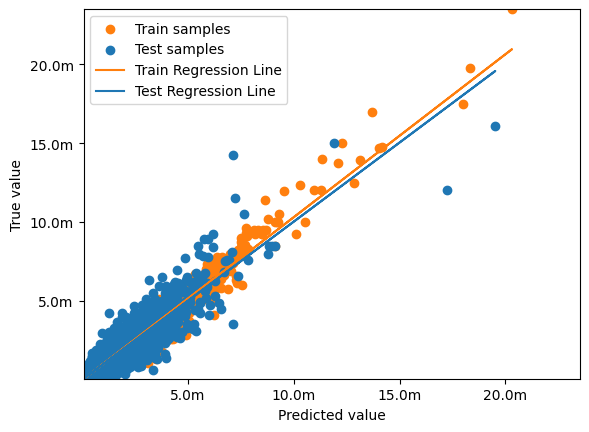

In [267]:
import matplotlib.ticker as ticker

def formatter(x, pos):
    return f'{x * 1e-6}m'

sns.set_palette("tab10")

# Predict on the train & test set
train_predictions = models['randomForest'].predict(X_train)
test_predictions = models['randomForest'].predict(X_test)

train_m, train_b = np.polyfit(train_predictions, y_train, 1)
test_m, test_b = np.polyfit(test_predictions, y_test, 1)

plt.scatter(train_predictions, y_train, label="Train samples", color=sns.color_palette()[1])
plt.scatter(test_predictions, y_test, label="Test samples", color=sns.color_palette()[0])

# Plot regression lines
plt.plot(train_predictions, train_m * train_predictions + train_b, color=sns.color_palette()[1], label="Train Regression Line")
plt.plot(test_predictions, test_m * test_predictions + test_b, color=sns.color_palette()[0], label="Test Regression Line")

all_values = np.concatenate([train_predictions, test_predictions, y_train, y_test])
min_val, max_val = np.min(all_values), np.max(all_values)

axes = plt.gca()
axes.set(xlim=(min_val, max_val), ylim=(min_val, max_val))
axes.xaxis.set_major_formatter(ticker.FuncFormatter(formatter))
axes.yaxis.set_major_formatter(ticker.FuncFormatter(formatter))

plt.xlabel("Predicted value")
plt.ylabel("True value")
plt.legend()
plt.show()

# Advanced regression models

In [33]:
selected_df = df[[
  'PPD_Price',
  'PPD_TransferDate',
  'PPD_PropertyType',
  'PPD_OldNew',
  'PPD_Duration',
  'PPD_District',
#   'PPD_TownCity',

  'EPC_CURRENT_ENERGY_RATING',
  'EPC_PROPERTY_TYPE',
  'EPC_BUILT_FORM',
  'EPC_ENERGY_CONSUMPTION_CURRENT',
  'EPC_CO2_EMISSIONS_CURRENT',
  'EPC_TOTAL_FLOOR_AREA',
  'EPC_FLOOR_LEVEL',
  'EPC_NUMBER_HABITABLE_ROOMS',
  'EPC_WINDOWS_ENERGY_EFF',
  'EPC_WALLS_ENERGY_EFF',
  'EPC_ROOF_ENERGY_EFF',
  'EPC_MAINHEAT_ENERGY_EFF',
  'EPC_LIGHTING_ENERGY_EFF',
  'EPC_CONSTRUCTION_AGE',
  # 'EPC_TENURE',

  'zoo_num_bed_min',
  # 'zoo_num_floors_min',
  'zoo_num_bath_min',
  'zoo_num_reception_min',
  'zoo_duration',
  'zoo_auction',
  'zoo_garage',
  'zoo_shared_ownership',
  # 'zoo_started_not_ended',

  'NPT_NearbyBusStops',
  'NPT_NearbyTramMetroStops',
  'NPT_NearbyRailStops',
  # 'NPT_NearbyStops',

  'SCH_ACAD',
  'SCH_IND',
  'SCH_NURSERY',
  'SCH_OUTSTANDING',
  'SCH_GOOD',
  # 'SCH_ALL',

  'PGN_HouseWithPOS',
  'PGN_HouseTotalPOS',
  'PGN_FlatWithPOS',
  'PGN_FlatTotalPOS',
  'PGN_FlatPOSCount',
  'PGN_FlatPOSShare',
  # 'PGN_NearestParkDistanceAvg',
  # 'PGN_NearestParkSizeAvg',
  'PGN_1kParkCountAvg',
  'PGN_1kParkSizeAvg',

  'IMD_IncDecile',
  'IMD_EmpDecile',
  'IMD_EduDecile',
  'IMD_CrmDecile',
  # 'IMD_HouseBarDecile',
  'IMD_EnvDecile',

  'RATE_2Y_75BTL',

  # 'ONSUD_BOROUGH',
  # 'ONSUD_WARD',
  # 'ONSUD_MSOA',
  'UPRN_LATITUDE',
  'UPRN_LONGITUDE',
]]

prepared_df = selected_df[selected_df['EPC_TOTAL_FLOOR_AREA'] != 0].copy()
prepared_df = remove_outliers_by_lambda(prepared_df, lambda row: row['PPD_Price'] / row['EPC_TOTAL_FLOOR_AREA'])
prepared_df['EPC_FLOOR_LEVEL'] = prepared_df['EPC_FLOOR_LEVEL'].apply(bucket_floor_levels)

# Selected columns
ppd_duration_col = ['PPD_Duration']
epc_rating_col = ['EPC_CURRENT_ENERGY_RATING']
eff_cols = [col for col in prepared_df.columns if col.endswith('_EFF')]

high_cardinality_cols = get_high_cardinality_features(prepared_df, cardinality_threshold=33)
object_cols = prepared_df.select_dtypes(include=['object']).columns.drop(ppd_duration_col + epc_rating_col + eff_cols + high_cardinality_cols)
numeric_cols = prepared_df.select_dtypes(include=['int64', 'float64']).columns.drop('PPD_Price')
boolean_cols = prepared_df.select_dtypes(include=['bool']).columns
datetime_cols = prepared_df.select_dtypes(include=['datetime64']).columns

X = prepared_df.drop('PPD_Price', axis=1)
y = prepared_df['PPD_Price']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=prepared_df['PPD_District'], random_state=seed)

# Create custom imputers
customised_imputers = SequentialImputer(
    imputers=[
        ('epc1', CategoryKNNImputer(columns=['EPC_CURRENT_ENERGY_RATING', 'EPC_CO2_EMISSIONS_CURRENT', 'EPC_ENERGY_CONSUMPTION_CURRENT'])),
        ('epc2', CategoryKNNImputer(columns=['EPC_WINDOWS_ENERGY_EFF', 'EPC_CURRENT_ENERGY_RATING', 'EPC_CO2_EMISSIONS_CURRENT', 'EPC_ENERGY_CONSUMPTION_CURRENT'])),
        ('epc3', CategoryKNNImputer(columns=['EPC_WALLS_ENERGY_EFF', 'EPC_CURRENT_ENERGY_RATING', 'EPC_CO2_EMISSIONS_CURRENT', 'EPC_ENERGY_CONSUMPTION_CURRENT'])),
        ('epc4', CategoryKNNImputer(columns=['EPC_MAINHEAT_ENERGY_EFF', 'EPC_CURRENT_ENERGY_RATING', 'EPC_CO2_EMISSIONS_CURRENT', 'EPC_ENERGY_CONSUMPTION_CURRENT'])),
        ('epc5', CategoryKNNImputer(columns=['EPC_LIGHTING_ENERGY_EFF', 'EPC_CURRENT_ENERGY_RATING', 'EPC_CO2_EMISSIONS_CURRENT', 'EPC_ENERGY_CONSUMPTION_CURRENT'])),
        ('epc6', CategoryKNNImputer(columns=['EPC_ROOF_ENERGY_EFF', 'EPC_CURRENT_ENERGY_RATING', 'EPC_CO2_EMISSIONS_CURRENT', 'EPC_ENERGY_CONSUMPTION_CURRENT'])),
        ('epc7', NumericKNNImputer(columns=['EPC_NUMBER_HABITABLE_ROOMS', 'EPC_TOTAL_FLOOR_AREA'], round=True)),
        ('epc8', CategoryKNNImputer(columns=['EPC_BUILT_FORM', 'EPC_PROPERTY_TYPE', 'EPC_TOTAL_FLOOR_AREA', 'EPC_NUMBER_HABITABLE_ROOMS'])),
        # ('epc9', CategoryKNNImputer(columns=['EPC_TENURE', 'EPC_PROPERTY_TYPE', 'EPC_BUILT_FORM'])),

        ('zoo1', NumericKNNImputer(columns=['zoo_num_bed_min', 'EPC_PROPERTY_TYPE', 'EPC_BUILT_FORM', 'EPC_NUMBER_HABITABLE_ROOMS', 'EPC_TOTAL_FLOOR_AREA'], round=True)),
        ('zoo2', NumericKNNImputer(columns=['zoo_num_bath_min', 'EPC_PROPERTY_TYPE', 'EPC_BUILT_FORM', 'EPC_NUMBER_HABITABLE_ROOMS', 'EPC_TOTAL_FLOOR_AREA'], round=True)),
        ('zoo3', NumericKNNImputer(columns=['zoo_num_reception_min', 'EPC_PROPERTY_TYPE', 'EPC_BUILT_FORM', 'EPC_NUMBER_HABITABLE_ROOMS', 'EPC_TOTAL_FLOOR_AREA'], round=True)),
        # ('zoo4', NumericKNNImputer(columns=['zoo_num_floors_min', 'EPC_PROPERTY_TYPE', 'EPC_BUILT_FORM', 'EPC_NUMBER_HABITABLE_ROOMS', 'EPC_TOTAL_FLOOR_AREA'], round=True)),

        ('green1', NumericKNNImputer(columns=['PGN_HouseTotalPOS', 'UPRN_LATITUDE', 'UPRN_LONGITUDE', 'EPC_PROPERTY_TYPE', 'EPC_BUILT_FORM'])),
        ('green2', NumericKNNImputer(columns=['PGN_HouseWithPOS', 'UPRN_LATITUDE', 'UPRN_LONGITUDE', 'EPC_PROPERTY_TYPE', 'EPC_BUILT_FORM'])),
        ('green3', NumericKNNImputer(columns=['PGN_FlatTotalPOS', 'UPRN_LATITUDE', 'UPRN_LONGITUDE', 'EPC_PROPERTY_TYPE', 'EPC_BUILT_FORM'])),
        ('green4', NumericKNNImputer(columns=['PGN_FlatWithPOS', 'UPRN_LATITUDE', 'UPRN_LONGITUDE', 'EPC_PROPERTY_TYPE', 'EPC_BUILT_FORM'])),
        # ('green5', NumericKNNImputer(columns=['PGN_NearestParkDistanceAvg', 'UPRN_LATITUDE', 'UPRN_LONGITUDE'])),
        # ('green6', NumericKNNImputer(columns=['PGN_NearestParkSizeAvg', 'UPRN_LATITUDE', 'UPRN_LONGITUDE'])),
        ('green7', NumericKNNImputer(columns=['PGN_1kParkSizeAvg', 'UPRN_LATITUDE', 'UPRN_LONGITUDE'])),
        ('green8', NumericKNNImputer(columns=['PGN_1kParkCountAvg', 'UPRN_LATITUDE', 'UPRN_LONGITUDE'])),

        ('imd1', NumericKNNImputer(columns=['IMD_EduDecile', 'UPRN_LATITUDE', 'UPRN_LONGITUDE'], round=True)),
        ('imd2', NumericKNNImputer(columns=['IMD_IncDecile', 'UPRN_LATITUDE', 'UPRN_LONGITUDE'], round=True)),
        ('imd3', NumericKNNImputer(columns=['IMD_EmpDecile', 'UPRN_LATITUDE', 'UPRN_LONGITUDE'], round=True)),
        ('imd4', NumericKNNImputer(columns=['IMD_CrmDecile', 'UPRN_LATITUDE', 'UPRN_LONGITUDE'], round=True)),
        # ('imd5', NumericKNNImputer(columns=['IMD_HouseBarDecile', 'UPRN_LATITUDE', 'UPRN_LONGITUDE'], round=True)),
        ('imd6', NumericKNNImputer(columns=['IMD_EnvDecile', 'UPRN_LATITUDE', 'UPRN_LONGITUDE'], round=True)),
    ]
)

# Impute training and test data
X_train = pd.DataFrame(customised_imputers.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(customised_imputers.transform(X_test), columns=X_train.columns)

# Add custom features
X_train = add_custom_features(X_train)
X_test = add_custom_features(X_test)

main_transformers = make_column_transformer(
    (make_pipeline(SimpleImputer(strategy='median'), RobustScaler()), numeric_cols),
    (OrdinalEncoder(), ppd_duration_col),
    (OrdinalEncoder(categories=[['G', 'F', 'E', 'D', 'C', 'B', 'A']]), epc_rating_col),
    (OrdinalEncoder(categories=[['VERY POOR', 'POOR', 'AVERAGE', 'GOOD', 'VERY GOOD']] * len(eff_cols)), eff_cols),
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), high_cardinality_cols),
    (OneHotEncoder(handle_unknown='infrequent_if_exist'), object_cols),
    (BooleanToInteger(), boolean_cols),
    (DateTimeExtractor(), datetime_cols),
)

pipeline = make_pipeline(
    InvalidValueCleaner(),
    StringCleaner(),
    main_transformers,
)

# Creating pipelines
lr_pipeline = make_pipeline(pipeline, LinearRegression(n_jobs=-1))
rf_pipeline = make_pipeline(pipeline, RandomForestRegressor(n_jobs=-1, random_state=seed))
svr_pipeline =  make_pipeline(pipeline, SVR(kernel='linear', C=100))
lasso_pipeline = make_pipeline(pipeline, Lasso(alpha=100, random_state=seed))
ridge_pipeline = make_pipeline(pipeline, Ridge(alpha=100, random_state=seed))
extra_pipeline = make_pipeline(pipeline, ExtraTreesRegressor(n_jobs=-1, random_state = seed))
decision_pipeline = make_pipeline(pipeline, DecisionTreeRegressor(random_state = seed))
gradient_pipeline = make_pipeline(pipeline,  GradientBoostingRegressor(random_state = seed))
xgb_pipeline = make_pipeline(pipeline, XGBRegressor(n_jobs=-1, random_state = seed))
lgbm_pipeline = make_pipeline(pipeline, LGBMRegressor(force_col_wise=True, n_jobs=-1, random_state = seed))

models = {
    'linear': lr_pipeline,
    'randomForest': rf_pipeline,
    'svr': svr_pipeline,
    'lasso': lasso_pipeline,
    'ridge': ridge_pipeline,
    'extra': extra_pipeline,
    'decision': decision_pipeline,
    'gradient': gradient_pipeline,
    'xgb': xgb_pipeline,
    'lgbm': lgbm_pipeline,
}

# Fit models 102m 4.9s
for model in models.values():
    model.fit(X_train, y_train)

# Evaluate models
for name, model in models.items():
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"{name} (r2: {r2:.6f}, mae: {mae:.2f}, rmse: {rmse:.2f})") 

/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[LightGBM] [Info] Total Bins 4014
[LightGBM] [Info] Number of data points in the train set: 261813, number of used features: 100
[LightGBM] [Info] Start training from score 583216.487436
linear (r2: 0.747353, mae: 133044.32, rmse: 231206.26)
randomForest (r2: 0.887394, mae: 71823.51, rmse: 154355.98)
svr (r2: 0.668168, mae: 123120.91, rmse: 264972.91)
lasso (r2: 0.746902, mae: 132716.68, rmse: 231412.75)
ridge (r2: 0.747191, mae: 132840.63, rmse: 231280.59)
extra (r2: 0.891523, mae: 69417.87, rmse: 151499.51)
decision (r2: 0.773409, mae: 103622.90, rmse: 218959.58)
gradient (r2: 0.831907, mae: 103923.83, rmse: 188589.52)
xgb (r2: 0.873465, mae: 81587.31, rmse: 163624.66)
lgbm (r2: 0.867606, mae: 87262.32, rmse: 167369.59)


In [34]:
for name, model in models.items():
  utils.save_model(model, name)

Saving model to ./data/saved/linear.joblib...
Saving model to ./data/saved/randomForest.joblib...
Saving model to ./data/saved/svr.joblib...
Saving model to ./data/saved/lasso.joblib...
Saving model to ./data/saved/ridge.joblib...
Saving model to ./data/saved/extra.joblib...
Saving model to ./data/saved/decision.joblib...
Saving model to ./data/saved/gradient.joblib...
Saving model to ./data/saved/xgb.joblib...
Saving model to ./data/saved/lgbm.joblib...


```text
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4710
[LightGBM] [Info] Number of data points in the train set: 261866, number of used features: 169
[LightGBM] [Info] Start training from score 583951.659937
linear (r2: 0.753004, mae: 129487.25, rmse: 224277.43)
randomForest (r2: 0.890314, mae: 71299.12, rmse: 149457.32)
svr (r2: 0.701852, mae: 118515.77, rmse: 246409.17)
lasso (r2: 0.742196, mae: 132397.87, rmse: 229131.65)
ridge (r2: 0.750004, mae: 129707.81, rmse: 225635.20)
extra (r2: 0.892282, mae: 69779.06, rmse: 148110.14)
decision (r2: 0.769573, mae: 103449.41, rmse: 216624.28)
ada (r2: 0.177744, mae: 355594.87, rmse: 409208.19)
gradient (r2: 0.835994, mae: 101735.45, rmse: 182755.68)
xgb (r2: 0.883419, mae: 80549.72, rmse: 154082.65)
lgbm (r2: 0.874175, mae: 85963.72, rmse: 160075.52)
```

# Hyperparameter tuning, grid search and cross-validation

In [39]:
import modules.utils as utils

selected_df = df[[
  'PPD_Price',
  'PPD_TransferDate',
  'PPD_PropertyType',
  'PPD_OldNew',
  'PPD_Duration',
  'PPD_District',
#   'PPD_TownCity',

  'EPC_CURRENT_ENERGY_RATING',
  'EPC_PROPERTY_TYPE',
  'EPC_BUILT_FORM',
  'EPC_ENERGY_CONSUMPTION_CURRENT',
  'EPC_CO2_EMISSIONS_CURRENT',
  'EPC_TOTAL_FLOOR_AREA',
  'EPC_FLOOR_LEVEL',
  'EPC_NUMBER_HABITABLE_ROOMS',
  'EPC_WINDOWS_ENERGY_EFF',
  'EPC_WALLS_ENERGY_EFF',
  'EPC_ROOF_ENERGY_EFF',
  'EPC_MAINHEAT_ENERGY_EFF',
  'EPC_LIGHTING_ENERGY_EFF',
  'EPC_CONSTRUCTION_AGE',
  # 'EPC_TENURE',

  'zoo_num_bed_min',
  # 'zoo_num_floors_min',
  'zoo_num_bath_min',
  'zoo_num_reception_min',
  'zoo_duration',
  'zoo_auction',
  'zoo_garage',
  'zoo_shared_ownership',
  # 'zoo_started_not_ended',

  'NPT_NearbyBusStops',
  'NPT_NearbyTramMetroStops',
  'NPT_NearbyRailStops',
  # 'NPT_NearbyStops',

  'SCH_ACAD',
  'SCH_IND',
  'SCH_NURSERY',
  'SCH_OUTSTANDING',
  'SCH_GOOD',
  # 'SCH_ALL',

  'PGN_HouseWithPOS',
  'PGN_HouseTotalPOS',
  'PGN_FlatWithPOS',
  'PGN_FlatTotalPOS',
  'PGN_FlatPOSCount',
  'PGN_FlatPOSShare',
  # 'PGN_NearestParkDistanceAvg',
  # 'PGN_NearestParkSizeAvg',
  'PGN_1kParkCountAvg',
  'PGN_1kParkSizeAvg',

  'IMD_IncDecile',
  'IMD_EmpDecile',
  'IMD_EduDecile',
  'IMD_CrmDecile',
  # 'IMD_HouseBarDecile',
  'IMD_EnvDecile',

  # 'ONSUD_BOROUGH',
  # 'ONSUD_WARD',
  # 'ONSUD_MSOA',
  'UPRN_LATITUDE',
  'UPRN_LONGITUDE',
]]

prepared_df = selected_df[selected_df['EPC_TOTAL_FLOOR_AREA'] != 0].copy()
prepared_df = remove_outliers_by_lambda(prepared_df, lambda row: row['PPD_Price'] / row['EPC_TOTAL_FLOOR_AREA'])
prepared_df['EPC_FLOOR_LEVEL'] = prepared_df['EPC_FLOOR_LEVEL'].apply(bucket_floor_levels)

# Stratified sample only 10%
prepared_df = prepared_df.groupby('PPD_District', group_keys=False).apply(lambda x: x.sample(frac=0.1, random_state=seed))

# Selected columns
ppd_duration_col = ['PPD_Duration']
epc_rating_col = ['EPC_CURRENT_ENERGY_RATING']
eff_cols = [col for col in prepared_df.columns if col.endswith('_EFF')]

high_cardinality_cols = get_high_cardinality_features(prepared_df, cardinality_threshold=33)
object_cols = prepared_df.select_dtypes(include=['object']).columns.drop(ppd_duration_col + epc_rating_col + eff_cols + high_cardinality_cols)
numeric_cols = prepared_df.select_dtypes(include=['int64', 'float64']).columns.drop('PPD_Price')
boolean_cols = prepared_df.select_dtypes(include=['bool']).columns
datetime_cols = prepared_df.select_dtypes(include=['datetime64']).columns

X = prepared_df.drop('PPD_Price', axis=1)
y = prepared_df['PPD_Price']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=prepared_df['PPD_District'], random_state=seed)

# Create custom imputers
customised_imputers = SequentialImputer(
    imputers=[
        ('epc1', CategoryKNNImputer(columns=['EPC_CURRENT_ENERGY_RATING', 'EPC_CO2_EMISSIONS_CURRENT', 'EPC_ENERGY_CONSUMPTION_CURRENT'])),
        ('epc2', CategoryKNNImputer(columns=['EPC_WINDOWS_ENERGY_EFF', 'EPC_CURRENT_ENERGY_RATING', 'EPC_CO2_EMISSIONS_CURRENT', 'EPC_ENERGY_CONSUMPTION_CURRENT'])),
        ('epc3', CategoryKNNImputer(columns=['EPC_WALLS_ENERGY_EFF', 'EPC_CURRENT_ENERGY_RATING', 'EPC_CO2_EMISSIONS_CURRENT', 'EPC_ENERGY_CONSUMPTION_CURRENT'])),
        ('epc4', CategoryKNNImputer(columns=['EPC_MAINHEAT_ENERGY_EFF', 'EPC_CURRENT_ENERGY_RATING', 'EPC_CO2_EMISSIONS_CURRENT', 'EPC_ENERGY_CONSUMPTION_CURRENT'])),
        ('epc5', CategoryKNNImputer(columns=['EPC_LIGHTING_ENERGY_EFF', 'EPC_CURRENT_ENERGY_RATING', 'EPC_CO2_EMISSIONS_CURRENT', 'EPC_ENERGY_CONSUMPTION_CURRENT'])),
        ('epc6', CategoryKNNImputer(columns=['EPC_ROOF_ENERGY_EFF', 'EPC_CURRENT_ENERGY_RATING', 'EPC_CO2_EMISSIONS_CURRENT', 'EPC_ENERGY_CONSUMPTION_CURRENT'])),
        ('epc7', NumericKNNImputer(columns=['EPC_NUMBER_HABITABLE_ROOMS', 'EPC_TOTAL_FLOOR_AREA'], round=True)),
        ('epc8', CategoryKNNImputer(columns=['EPC_BUILT_FORM', 'EPC_PROPERTY_TYPE', 'EPC_TOTAL_FLOOR_AREA', 'EPC_NUMBER_HABITABLE_ROOMS'])),
        # ('epc9', CategoryKNNImputer(columns=['EPC_TENURE', 'EPC_PROPERTY_TYPE', 'EPC_BUILT_FORM'])),

        ('zoo1', NumericKNNImputer(columns=['zoo_num_bed_min', 'EPC_PROPERTY_TYPE', 'EPC_BUILT_FORM', 'EPC_NUMBER_HABITABLE_ROOMS', 'EPC_TOTAL_FLOOR_AREA'], round=True)),
        ('zoo2', NumericKNNImputer(columns=['zoo_num_bath_min', 'EPC_PROPERTY_TYPE', 'EPC_BUILT_FORM', 'EPC_NUMBER_HABITABLE_ROOMS', 'EPC_TOTAL_FLOOR_AREA'], round=True)),
        ('zoo3', NumericKNNImputer(columns=['zoo_num_reception_min', 'EPC_PROPERTY_TYPE', 'EPC_BUILT_FORM', 'EPC_NUMBER_HABITABLE_ROOMS', 'EPC_TOTAL_FLOOR_AREA'], round=True)),
        # ('zoo4', NumericKNNImputer(columns=['zoo_num_floors_min', 'EPC_PROPERTY_TYPE', 'EPC_BUILT_FORM', 'EPC_NUMBER_HABITABLE_ROOMS', 'EPC_TOTAL_FLOOR_AREA'], round=True)),

        ('green1', NumericKNNImputer(columns=['PGN_HouseTotalPOS', 'UPRN_LATITUDE', 'UPRN_LONGITUDE', 'EPC_PROPERTY_TYPE', 'EPC_BUILT_FORM'])),
        ('green2', NumericKNNImputer(columns=['PGN_HouseWithPOS', 'UPRN_LATITUDE', 'UPRN_LONGITUDE', 'EPC_PROPERTY_TYPE', 'EPC_BUILT_FORM'])),
        ('green3', NumericKNNImputer(columns=['PGN_FlatTotalPOS', 'UPRN_LATITUDE', 'UPRN_LONGITUDE', 'EPC_PROPERTY_TYPE', 'EPC_BUILT_FORM'])),
        ('green4', NumericKNNImputer(columns=['PGN_FlatWithPOS', 'UPRN_LATITUDE', 'UPRN_LONGITUDE', 'EPC_PROPERTY_TYPE', 'EPC_BUILT_FORM'])),
        # ('green5', NumericKNNImputer(columns=['PGN_NearestParkDistanceAvg', 'UPRN_LATITUDE', 'UPRN_LONGITUDE'])),
        # ('green6', NumericKNNImputer(columns=['PGN_NearestParkSizeAvg', 'UPRN_LATITUDE', 'UPRN_LONGITUDE'])),
        ('green7', NumericKNNImputer(columns=['PGN_1kParkSizeAvg', 'UPRN_LATITUDE', 'UPRN_LONGITUDE'])),
        ('green8', NumericKNNImputer(columns=['PGN_1kParkCountAvg', 'UPRN_LATITUDE', 'UPRN_LONGITUDE'])),

        ('imd1', NumericKNNImputer(columns=['IMD_EduDecile', 'UPRN_LATITUDE', 'UPRN_LONGITUDE'], round=True)),
        ('imd2', NumericKNNImputer(columns=['IMD_IncDecile', 'UPRN_LATITUDE', 'UPRN_LONGITUDE'], round=True)),
        ('imd3', NumericKNNImputer(columns=['IMD_EmpDecile', 'UPRN_LATITUDE', 'UPRN_LONGITUDE'], round=True)),
        ('imd4', NumericKNNImputer(columns=['IMD_CrmDecile', 'UPRN_LATITUDE', 'UPRN_LONGITUDE'], round=True)),
        # ('imd5', NumericKNNImputer(columns=['IMD_HouseBarDecile', 'UPRN_LATITUDE', 'UPRN_LONGITUDE'], round=True)),
        ('imd6', NumericKNNImputer(columns=['IMD_EnvDecile', 'UPRN_LATITUDE', 'UPRN_LONGITUDE'], round=True)),
    ]
)

# # Impute training and test data
# X_train = pd.DataFrame(customised_imputers.fit_transform(X_train), columns=X_train.columns)
# X_test = pd.DataFrame(customised_imputers.transform(X_test), columns=X_train.columns)

# # Add custom features
# X_train = add_custom_features(X_train)
# X_test = add_custom_features(X_test)

# main_transformers = make_column_transformer(
#     (make_pipeline(SimpleImputer(strategy='median'), RobustScaler()), numeric_cols),
#     (OrdinalEncoder(), ppd_duration_col),
#     (OrdinalEncoder(categories=[['G', 'F', 'E', 'D', 'C', 'B', 'A']]), epc_rating_col),
#     (OrdinalEncoder(categories=[['VERY POOR', 'POOR', 'AVERAGE', 'GOOD', 'VERY GOOD']] * len(eff_cols)), eff_cols),
#     (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), high_cardinality_cols),
#     (OneHotEncoder(handle_unknown='infrequent_if_exist'), object_cols),
#     (BooleanToInteger(), boolean_cols),
#     (DateTimeExtractor(), datetime_cols),
#     remainder='passthrough'
# )

main_transformers = make_column_transformer(
    (make_pipeline(SimpleImputer(strategy='median'), StandardScaler()), numeric_cols),
    (make_pipeline(SimpleImputer(strategy='most_frequent'), OrdinalEncoder()), ppd_duration_col),
    (make_pipeline(SimpleImputer(strategy='most_frequent'), OrdinalEncoder(categories=[['G', 'F', 'E', 'D', 'C', 'B', 'A']])), epc_rating_col),
    (make_pipeline(SimpleImputer(strategy='most_frequent'), OrdinalEncoder(categories=[['VERY POOR', 'POOR', 'AVERAGE', 'GOOD', 'VERY GOOD']] * len(eff_cols))), eff_cols),
    (make_pipeline(SimpleImputer(strategy='most_frequent'), OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)), high_cardinality_cols),
    (make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='infrequent_if_exist')), object_cols),
    (make_pipeline(BooleanToInteger(), SimpleImputer(strategy='most_frequent')), boolean_cols),
    (DateTimeExtractor(), datetime_cols),
)  

pipeline = make_pipeline(
    InvalidValueCleaner(),
    StringCleaner(),
    main_transformers,
)

# Creating pipelines
lr_pipeline = make_pipeline(pipeline, LinearRegression())
rf_pipeline = make_pipeline(pipeline, RandomForestRegressor(random_state=seed))
svr_pipeline =  make_pipeline(pipeline, SVR())
lasso_pipeline = make_pipeline(pipeline, Lasso(random_state=seed))
ridge_pipeline = make_pipeline(pipeline, Ridge(random_state=seed))
extra_pipeline = make_pipeline(pipeline, ExtraTreesRegressor(random_state=seed))
gradient_pipeline = make_pipeline(pipeline,  GradientBoostingRegressor(random_state=seed))
xgb_pipeline = make_pipeline(pipeline, XGBRegressor(random_state=seed))
lgbm_pipeline = make_pipeline(pipeline, LGBMRegressor(random_state=seed))

models = {
    'linear': lr_pipeline,
    'randomForest': rf_pipeline,
    'svr': svr_pipeline,
    'lasso': lasso_pipeline,
    'ridge': ridge_pipeline,
    'extra': extra_pipeline,
    'gradient': gradient_pipeline,
    'xgb': xgb_pipeline,
    'lgbm': lgbm_pipeline,
}

# Hyperparameters to tune
param_grids = {
    'linear': {},

    'randomForest': {
        'randomforestregressor__max_features': [None, 'sqrt', 'log2'],
        'randomforestregressor__n_estimators': [10, 50, 100, 200],
        'randomforestregressor__max_depth': [10, 20, 30],
        'randomforestregressor__min_samples_split': [2, 5, 10],
        'randomforestregressor__min_samples_leaf': [1, 2, 4],
    },

    'svr': {
        'svr__C': [1, 10, 100],
        'svr__gamma': ['scale', 0.1, 1, 10],
        'svr__epsilon': [0.01, 0.1, 1, 10]
    },

    'lasso': {
        'lasso__alpha': [ 0.1, 1, 10, 100]
    },

    'ridge': {
        'ridge__alpha': [ 0.1, 1, 10, 100]
    },

    'extra': {
        'extratreesregressor__n_estimators': [10, 50, 100],
        'extratreesregressor__max_depth': [10, 20, 30],
        'extratreesregressor__min_samples_split': [2, 5, 10],
        'extratreesregressor__min_samples_leaf': [1, 2, 4],
    },

    'gradient': {
        'gradientboostingregressor__min_samples_split': [2, 5, 10],
        'gradientboostingregressor__min_samples_leaf': [1, 2, 4],
        'gradientboostingregressor__n_estimators': [10, 50, 100, 200],
        'gradientboostingregressor__learning_rate': [0.001, 0.01, 0.1],
        'gradientboostingregressor__subsample': [0.8, 0.9, 1.0],
        'gradientboostingregressor__max_depth': [3, 5, 7, 9]
    },

    'xgb': {
        'xgbregressor__n_estimators': [10, 50, 100, 200],
        'xgbregressor__learning_rate': [0.001, 0.01, 0.1],
        'xgbregressor__colsample_bytree': [0.6, 0.8, 1.0],
        'xgbregressor__max_depth': [3, 5, 7, 9],
        'xgbregressor__subsample': [0.5, 0.7, 1]
    },

    'lgbm': {
        'lgbmregressor__boosting_type': ['gbdt', 'dart', 'goss'],
        'lgbmregressor__n_estimators': [50, 100, 200, 300],
        'lgbmregressor__learning_rate': [0.001, 0.01, 0.1],
        'lgbmregressor__max_depth': [-1, 10, 20, 30],
        'lgbmregressor__num_leaves': [31, 50, 100, 150]
    }
}    

# Run grid search for each model
results = {}
with utils.Timer() as t:
    for name, model in models.items():
        t.log(f"Grid searching {name}...")
        # Use 5-fold cross validation and negative mean absolute error as the scoring metric, which equates to MAE
        # grid_search = GridSearchCV(estimator=model, param_grid=param_grids[name], scoring='neg_mean_absolute_error', cv=5, n_jobs=-1, verbose=2)
        grid_search = RandomizedSearchCV(estimator=model, param_distributions=param_grids[name], n_iter=100, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1, verbose=2)
        grid_search.fit(X_train, y_train)
        
        results[name] = {
            'best_params': grid_search.best_params_,
            'best_model': grid_search.best_estimator_
        }

# Evaluate each best model 781.5m
with utils.Timer() as t:
    for name, model_results in results.items():
        y_pred = model_results['best_model'].predict(X_test)

        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))

        t.log(f"Best Parameters: {model_results['best_params']}")
        print(f"{name} (r2: {r2:.6f}, mae: {mae:.2f}, rmse: {rmse:.2f})")

=== Grid searching linear... (0.0000s) ===
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END .................................................... total time=   1.0s
[CV] END .................................................... total time=   0.9s
[CV] END .................................................... total time=   0.9s
[CV] END .................................................... total time=   0.9s
[CV] END .................................................... total time=   0.9s
=== Grid searching randomForest... (3.2215s) ===
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END randomforestregressor__max_depth=20, randomforestregressor__max_features=sqrt, randomforestregressor__min_samples_leaf=2, randomforestregressor__min_samples_split=10, randomforestregressor__n_estimators=50; total time=   3.5s
[CV] END randomforestregressor__max_depth=20, randomforestregressor__max_features=sqrt, randomforestregressor__min_samples_leaf=2, randomforestregressor__min_samples_split=10, randomforestregressor__n_estimators=50; total time=   3.4s
[CV] END rand

/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END randomforestregressor__max_depth=30, randomforestregressor__max_features=log2, randomforestregressor__min_samples_leaf=4, randomforestregressor__min_samples_split=2, randomforestregressor__n_estimators=10; total time=   1.2s
[CV] END randomforestregressor__max_depth=30, randomforestregressor__max_features=log2, randomforestregressor__min_samples_leaf=4, randomforestregressor__min_samples_split=2, randomforestregressor__n_estimators=10; total time=   1.2s
[CV] END randomforestregressor__max_depth=30, randomforestregressor__max_features=None, randomforestregressor__min_samples_leaf=1, randomforestregressor__min_samples_split=2, randomforestregressor__n_estimators=200; total time= 2.2min
[CV] END randomforestregressor__max_depth=30, randomforestregressor__max_features=log2, randomforestregressor__min_samples_leaf=4, randomforestregressor__min_samples_split=2, randomforestregressor__n_estimators=10; total time=   1.2s
[CV] END randomforestregressor__max_depth=30, randomforestregre

/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 48 is smaller than n_iter=100. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END ........svr__C=1, svr__epsilon=0.01, svr__gamma=0.1; total time= 1.7min
[CV] END ........svr__C=1, svr__epsilon=0.01, svr__gamma=0.1; total time= 1.8min
[CV] END ......svr__C=1, svr__epsilon=0.01, svr__gamma=scale; total time= 1.8min
[CV] END ......svr__C=1, svr__epsilon=0.01, svr__gamma=scale; total time= 1.8min
[CV] END ........svr__C=1, svr__epsilon=0.01, svr__gamma=0.1; total time= 1.8min
[CV] END ......svr__C=1, svr__epsilon=0.01, svr__gamma=scale; total time= 1.8min
[CV] END ......svr__C=1, svr__epsilon=0.01, svr__gamma=scale; total time= 1.8min
[CV] END ......svr__C=1, svr__epsilon=0.01, svr__gamma=scale; total time= 1.9min
[CV] END ........svr__C=1, svr__epsilon=0.01, svr__gamma=0.1; total time= 1.6min
[CV] END ........svr__C=1, svr__epsilon=0.01, svr__gamma=0.1; total time= 1.6min
[CV] END ..........svr__C=1, svr__epsilon=0.01, svr__gamma=1; total time= 1.8min
[CV] END ..........svr__C=1, svr__epsilon=0.01, svr__gamma=1; total time= 1.8min
[CV] END ..........svr__C=1,

/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 4 is smaller than n_iter=100. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.327e+12, tolerance: 3.816e+11
  model = cd_fast.enet_coordinate_descent(
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.067e+13, tolerance: 3.549e+11
  model = cd_fast.enet_coordi

[CV] END ...................................lasso__alpha=0.1; total time=   7.0s
[CV] END ...................................lasso__alpha=0.1; total time=   7.0s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.658e+13, tolerance: 3.792e+11
  model = cd_fast.enet_coordinate_descent(
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.068e+12, tolerance: 3.801e+11
  model = cd_fast.enet_coordinate_descent(


[CV] END ...................................lasso__alpha=0.1; total time=   7.0s
[CV] END ...................................lasso__alpha=0.1; total time=   7.3s
[CV] END ...................................lasso__alpha=0.1; total time=   7.1s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.383e+12, tolerance: 3.623e+11
  model = cd_fast.enet_coordinate_descent(
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.336e+12, tolerance: 3.816e+11
  model = cd_fast.enet_coordinate_descent(
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

[CV] END .....................................lasso__alpha=1; total time=   7.6s
[CV] END .....................................lasso__alpha=1; total time=   7.7s
[CV] END .....................................lasso__alpha=1; total time=   7.6s
[CV] END ....................................lasso__alpha=10; total time=   2.8s
[CV] END ...................................lasso__alpha=100; total time=   1.8s
[CV] END ....................................lasso__alpha=10; total time=   2.4s
[CV] END ....................................lasso__alpha=10; total time=   3.2s
[CV] END ....................................lasso__alpha=10; total time=   3.1s
[CV] END ....................................lasso__alpha=10; total time=   2.7s
[CV] END ...................................lasso__alpha=100; total time=   1.4s
[CV] END ...................................lasso__alpha=100; total time=   1.4s
[CV] END ...................................lasso__alpha=100; total time=   1.5s
[CV] END ...................

/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.397e+12, tolerance: 3.623e+11
  model = cd_fast.enet_coordinate_descent(


[CV] END .....................................lasso__alpha=1; total time=   5.6s
=== Grid searching ridge... (4143.8397s) ===
Fitting 5 folds for each of 4 candidates, totalling 20 fits


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 4 is smaller than n_iter=100. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END ...................................ridge__alpha=0.1; total time=   0.6s
[CV] END ...................................ridge__alpha=0.1; total time=   0.7s
[CV] END ...................................ridge__alpha=0.1; total time=   0.8s
[CV] END ...................................ridge__alpha=0.1; total time=   0.8s
[CV] END ...................................ridge__alpha=0.1; total time=   0.8s
[CV] END .....................................ridge__alpha=1; total time=   0.8s
[CV] END .....................................ridge__alpha=1; total time=   0.9s
[CV] END .....................................ridge__alpha=1; total time=   0.9s
[CV] END .....................................ridge__alpha=1; total time=   0.8s
[CV] END .....................................ridge__alpha=1; total time=   0.9s
[CV] END ....................................ridge__alpha=10; total time=   0.9s
[CV] END ....................................ridge__alpha=10; total time=   0.9s
[CV] END ...................

/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 81 is smaller than n_iter=100. Running 81 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END extratreesregressor__max_depth=10, extratreesregressor__min_samples_leaf=1, extratreesregressor__min_samples_split=2, extratreesregressor__n_estimators=10; total time=   3.2s
[CV] END extratreesregressor__max_depth=10, extratreesregressor__min_samples_leaf=1, extratreesregressor__min_samples_split=2, extratreesregressor__n_estimators=10; total time=   3.2s
[CV] END extratreesregressor__max_depth=10, extratreesregressor__min_samples_leaf=1, extratreesregressor__min_samples_split=2, extratreesregressor__n_estimators=10; total time=   3.3s
[CV] END extratreesregressor__max_depth=10, extratreesregressor__min_samples_leaf=1, extratreesregressor__min_samples_split=2, extratreesregressor__n_estimators=10; total time=   3.3s
[CV] END extratreesregressor__max_depth=10, extratreesregressor__min_samples_leaf=1, extratreesregressor__min_samples_split=2, extratreesregressor__n_estimators=10; total time=   3.6s
[CV] END extratreesregressor__max_depth=10, extratreesregressor__min_samples_lea

/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-stu

[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=5, xgbregressor__n_estimators=50, xgbregressor__subsample=0.5; total time=   2.1s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=5, xgbregressor__n_estimators=50, xgbregressor__subsample=0.5; total time=   2.1s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=5, xgbregressor__n_estimators=50, xgbregressor__subsample=0.5; total time=   2.1s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=5, xgbregressor__n_estimators=50, xgbregressor__subsample=0.5; total time=   2.0s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=5, xgbregressor__n_estimators=50, xgbregressor__subsample=0.5; total time=   1.9s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-stu

[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=7, xgbregressor__n_estimators=100, xgbregressor__subsample=0.7; total time=   3.8s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=7, xgbregressor__n_estimators=100, xgbregressor__subsample=0.7; total time=   4.0s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=7, xgbregressor__n_estimators=100, xgbregressor__subsample=0.7; total time=   3.9s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=7, xgbregressor__n_estimators=100, xgbregressor__subsample=0.7; total time=   3.9s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=7, xgbregressor__n_estimators=100, xgbregressor__subsample=0.7; total time=   3.8s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=9, xgbregressor__n_estimators=100, xgbregressor__subsample=0.5; total time=   5.6s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=9, xgbregressor__n_estimators=100, xgbregressor__subsample=0.5; total time=   5.6s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=9, xgbregressor__n_estimators=100, xgbregressor__subsample=0.5; total time=   5.6s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=9, xgbregressor__n_estimators=200, xgbregressor__subsample=0.7; total time=  11.3s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=9, xgbregressor__n_estimators=200, xgbregressor__subsample=0.7; total time=  11.6s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=9, xgbregressor__n_estimators=200, xgbregressor__subsample=0.7; total time=  12.1s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=9, xgbregressor__n_estimators=200, xgbregressor__subsample=0.7; total time=  11.8s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=9, xgbregressor__n_estimators=100, xgbregressor__subsample=0.5; total time=   6.3s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=9, xgbregressor__n_estimators=200, xgbregressor__subsample=0.7; total time=  12.5s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=9, xgbregressor__n_estimators=100, xgbregressor__subsample=0.5; total time=   6.1s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=9, xgbregressor__n_estimators=100, xgbregressor__subsample=0.5; total time=   6.2s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=9, xgbregressor__n_estimators=10, xgbregressor__subsample=0.5; total time=   1.7s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=9, xgbregressor__n_estimators=10, xgbregressor__subsample=0.5; total time=   1.7s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=9, xgbregressor__n_estimators=10, xgbregressor__subsample=0.5; total time=   1.6s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=9, xgbregressor__n_estimators=10, xgbregressor__subsample=0.5; total time=   1.7s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=9, xgbregressor__n_estimators=10, xgbregressor__subsample=0.5; total time=   1.6s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=9, xgbregressor__n_estimators=100, xgbregressor__subsample=0.5; total time=   6.7s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=9, xgbregressor__n_estimators=100, xgbregressor__subsample=0.5; total time=   7.0s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=9, xgbregressor__n_estimators=100, xgbregressor__subsample=0.5; total time=   6.6s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=9, xgbregressor__n_estimators=100, xgbregressor__subsample=0.5; total time=   6.6s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=9, xgbregressor__n_estimators=50, xgbregressor__subsample=0.7; total time=   4.5s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=9, xgbregressor__n_estimators=50, xgbregressor__subsample=0.7; total time=   4.0s

/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):



[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=9, xgbregressor__n_estimators=50, xgbregressor__subsample=0.7; total time=   4.1s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=9, xgbregressor__n_estimators=50, xgbregressor__subsample=0.7; total time=   4.0s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=0.5; total time=   3.2s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=9, xgbregressor__n_estimators=50, xgbregressor__subsample=0.7; total time=   4.1s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=0.5; total time=   3.2s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=3, xgbregressor__n_estimators=10, xgbregressor__subsample=1; total time=   1.2s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=3, xgbregressor__n_estimators=10, xgbregressor__subsample=1; total time=   1.2s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=3, xgbregressor__n_estimators=10, xgbregressor__subsample=1; total time=   1.2s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=3, xgbregressor__n_estimators=10, xgbregressor__subsample=1; total time=   1.3s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=3, xgbregressor__n_estimators=10, xgbregressor__subsample=1; total time=   1.4s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=0.5; total time=   3.4s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=0.5; total time=   3.6s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=0.5; total time=   3.5s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=0.5; total time=   3.2s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=0.5; total time=   3.3s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=0.5; total time=   3.2s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=200, xgbregressor__subsample=1; total time=   5.7s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=200, xgbregressor__subsample=1; total time=   5.6s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=200, xgbregressor__subsample=1; total time=   5.7s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=200, xgbregressor__subsample=1; total time=   5.6s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=200, xgbregressor__subsample=1; total time=   5.8s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=0.5; total time=   3.3s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=0.7; total time=   2.5s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=0.7; total time=   2.3s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=0.7; total time=   2.1s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=0.7; total time=   2.2s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=0.5; total time=   3.5s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=0.7; total time=   2.3s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=9, xgbregressor__n_estimators=10, xgbregressor__subsample=0.7; total time=   1.6s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=9, xgbregressor__n_estimators=10, xgbregressor__subsample=0.7; total time=   1.8s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=9, xgbregressor__n_estimators=10, xgbregressor__subsample=0.7; total time=   1.5s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=9, xgbregressor__n_estimators=50, xgbregressor__subsample=0.7; total time=   4.2s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=9, xgbregressor__n_estimators=50, xgbregressor__subsample=0.7; total time=   4.2s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=9, xgbregressor__n_estimators=10, xgbregressor__subsample=0.7; total time=   1.5s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=9, xgbregressor__n_estimators=10, xgbregressor__subsample=0.7; total time=   1.6s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=9, xgbregressor__n_estimators=50, xgbregressor__subsample=0.7; total time=   4.4s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=9, xgbregressor__n_estimators=50, xgbregressor__subsample=0.7; total time=   4.3s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_ra

/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=9, xgbregressor__n_estimators=50, xgbregressor__subsample=0.7; total time=   4.5s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-stu

[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=0.5; total time=   1.8s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=0.5; total time=   1.7s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=0.5; total time=   1.9s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=0.7; total time=   3.5s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=0.7; total time=   3.3s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=0.7; total time=   3.4s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=0.7; total time=   3.5s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=0.7; total time=   3.4s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=9, xgbregressor__n_estimators=200, xgbregressor__subsample=0.5; total time=  11.4s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=9, xgbregressor__n_estimators=200, xgbregressor__subsample=0.5; total time=  11.2s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=9, xgbregressor__n_estimators=200, xgbregressor__subsample=0.5; total time=  11.6s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=9, xgbregressor__n_estimators=200, xgbregressor__subsample=0.5; total time=  11.9s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=7, xgbregressor__n_estimators=200, xgbregressor__subsample=1; total time=   7.0s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=9, xgbregressor__n_estimators=200, xgbregressor__subsample=0.5; total time=  11.9s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=7, xgbregressor__n_estimators=200, xgbregressor__subsample=1; total time=   7.5s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=7, xgbregressor__n_estimators=200, xgbregressor__subsample=1; total time=   7.7s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=9, xgbregressor__n_estimators=10, xgbregressor__subsample=0.5; total time=   1.6s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=7, xgbregressor__n_estimators=200, xgbregressor__subsample=1; total time=   7.6s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=7, xgbregressor__n_estimators=200, xgbregressor__subsample=1; total time=   7.8s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=9, xgbregressor__n_estimators=10, xgbregressor__subsample=0.5; total time=   1.7s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=9, xgbregressor__n_estimators=200, xgbregressor__subsample=1; total time=   8.3s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=9, xgbregressor__n_estimators=200, xgbregressor__subsample=1; total time=   8.8s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=9, xgbregressor__n_estimators=10, xgbregressor__subsample=0.5; total time=   1.6s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=9, xgbregressor__n_estimators=10, xgbregressor__subsample=0.5; total time=   1.7s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=9, xgbregressor__n_estimators=200, xgbregressor__subsample=1; total time=   8.8s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.001,

/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=9, xgbregressor__n_estimators=200, xgbregressor__subsample=1; total time=   8.8s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-stu

[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=0.5; total time=   2.6s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=0.5; total time=   3.4s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=0.5; total time=   3.2s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=0.5; total time=   3.7s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=9, xgbregressor__n_estimators=200, xgbregressor__subsample=1; total time=   8.3s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.1,

/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=0.5; total time=   3.6s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-stu

[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=0.5; total time=   2.2s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=0.5; total time=   2.1s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=0.5; total time=   2.2s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=9, xgbregressor__n_estimators=50, xgbregressor__subsample=0.7; total time=   3.6s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=9, xgbregressor__n_estimators=50, xgbregressor__subsample=0.7; total time=   3.8s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=9, xgbregressor__n_estimators=50, xgbregressor__subsample=0.7; total time=   3.7s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=9, xgbregressor__n_estimators=50, xgbregressor__subsample=0.7; total time=   4.1s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=9, xgbregressor__n_estimators=50, xgbregressor__subsample=0.7; total time=   4.1s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=0.5; total time=   3.3s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=0.5; total time=   3.6s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=0.5; total time=   3.5s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=0.7; total time=   2.1s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=0.7; total time=   2.2s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=0.7; total time=   2.2s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=10, xgbregressor__subsample=1; total time=   1.3s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=0.5; total time=   3.3s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=0.5; total time=   3.5s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=10, xgbregressor__subsample=1; total time=   1.2s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=0.7; total time=   2.2s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=0.7; total time=   2.3s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=10, xgbregressor__subsample=1; total time=   1.3s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-stu

[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=10, xgbregressor__subsample=1; total time=   1.6s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=10, xgbregressor__subsample=1; total time=   1.5s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-stu

[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=5, xgbregressor__n_estimators=100, xgbregressor__subsample=1; total time=   3.3s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=5, xgbregressor__n_estimators=100, xgbregressor__subsample=1; total time=   3.3s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=5, xgbregressor__n_estimators=100, xgbregressor__subsample=1; total time=   3.3s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=5, xgbregressor__n_estimators=100, xgbregressor__subsample=1; total time=   3.1s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=5, xgbregressor__n_estimators=100, xgbregressor__subsample=1; total time=   3.0s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=9, xgbregressor__n_estimators=200, xgbregressor__subsample=0.7; total time=  11.5s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=9, xgbregressor__n_estimators=200, xgbregressor__subsample=0.7; total time=  11.7s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=9, xgbregressor__n_estimators=200, xgbregressor__subsample=0.7; total time=  12.0s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=9, xgbregressor__n_estimators=200, xgbregressor__subsample=0.7; total time=  12.4s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=9, xgbregressor__n_estimators=200, xgbregressor__subsample=0.7; total time=  12.8s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=1; total time=   3.4s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=1; total time=   3.6s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=1; total time=   3.7s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=9, xgbregressor__n_estimators=200, xgbregressor__subsample=1; total time=  13.3s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=1; total time=   3.4s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=9, xgbregressor__n_estimators=200, xgbregressor__subsample=1; total time=  12.7s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=9, xgbregressor__n_estimators=200, xgbregressor__subsample=1; total time=  13.1s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=1; total time=   3.8s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=0.7; total time=   2.2s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=9, xgbregressor__n_estimators=200, xgbregressor__subsample=1; total time=  12.7s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=9, xgbregressor__n_estimators=200, xgbregressor__subsample=1; total time=  13.1s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=0.7; total time=   2.3s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=0.7; total time=   2.6s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=0.7; total time=   2.4s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=0.7; total time=   2.3s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=9, xgbregressor__n_estimators=200, xgbregressor__subsample=0.5; total time=  10.6s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=5, xgbregressor__n_estimators=10, xgbregressor__subsample=1; total time=   1.4s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=5, xgbregressor__n_estimators=10, xgbregressor__subsample=1; total time=   1.3s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=9, xgbregressor__n_estimators=200, xgbregressor__subsample=0.5; total time=  10.8s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=5, xgbregressor__n_estimators=10, xgbregressor__subsample=1; total time=   1.4s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=5, xgbregressor__n_estimators=10, xgbregressor__subsample=1; total time=   1.3s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=9, xgbregressor__n_estimators=200, xgbregressor__subsample=0.5; total time=  10.7s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=5, xgbregressor__n_estimators=10, xgbregressor__subsample=1; total time=   1.5s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=9, xgbregressor__n_estimators=200, xgbregressor__subsample=0.5; total time=  10.8s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=50, xgbregressor__subsample=1; total time=   2.6s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=9, xgbregressor__n_estimators=200, xgbregressor__subsample=0.5; total time=  10.9s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=50, xgbregressor__subsample=1; total time=   2.5s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=50, xgbregressor__subsample=1; total time=   2.6s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=50, xgbregressor__subsample=1; total time=   2.6s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=50, xgbregressor__subsample=1; total time=   2.7s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=7, xgbregressor__n_estimators=50, xgbregressor__subsample=1; total time=   2.8s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=10, xgbregressor__subsample=1; total time=   1.4s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=10, xgbregressor__subsample=1; total time=   1.6s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=7, xgbregressor__n_estimators=50, xgbregressor__subsample=1; total time=   2.8s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=10, xgbregressor__subsample=1; total time=   1.4s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=7, xgbregressor__n_estimators=50, xgbregressor__subsample=1; total time=   3.0s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=7, xgbregressor__n_estimators=50, xgbregressor__subsample=1; total time=   3.1s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=7, xgbregressor__n_estimators=50, xgbregressor__subsample=1; total time=   2.9s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=10, xgbregressor__subsample=1; total time=   1.5s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=10, xgbregressor__subsample=1; total time=   1.5s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-stu

[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=200, xgbregressor__subsample=0.7; total time=   5.7s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=200, xgbregressor__subsample=0.7; total time=   5.6s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=5, xgbregressor__n_estimators=200, xgbregressor__subsample=0.5; total time=   5.0s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=200, xgbregressor__subsample=0.7; total time=   5.9s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=5, xgbregressor__n_estimators=200, xgbregressor__subsample=0.5; total time=   5.0s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rat

/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=200, xgbregressor__subsample=0.7; total time=   5.8s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=5, xgbregressor__n_estimators=200, xgbregressor__subsample=0.5; total time=   5.1s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-stu

[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=10, xgbregressor__subsample=0.5; total time=   1.3s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=10, xgbregressor__subsample=0.5; total time=   1.3s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=10, xgbregressor__subsample=0.5; total time=   1.3s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=10, xgbregressor__subsample=0.5; total time=   1.2s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=10, xgbregressor__subsample=0.5; total time=   1.4s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1; total time=   1.7s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1; total time=   1.8s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1; total time=   1.8s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1; total time=   1.7s

/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):



[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1; total time=   1.8s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=5, xgbregressor__n_estimators=200, xgbregressor__subsample=0.5; total time=   5.2s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=5, xgbregressor__n_estimators=200, xgbregressor__subsample=0.5; total time=   5.4s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=7, xgbregressor__n_estimators=10, xgbregressor__subsample=0.7; total time=   1.5s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=9, xgbregressor__n_estimators=50, xgbregressor__subsample=0.5; total time=   3.3s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=9, xgbregressor__n_estimators=50, xgbregressor__subsample=0.5; total time=   3.4s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=7, xgbregressor__n_estimators=10, xgbregressor__subsample=0.7; total time=   1.4s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=7, xgbregressor__n_estimators=10, xgbregressor__subsample=0.7; total time=   1.3s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=7, xgbregressor__n_estimators=10, xgbregressor__subsample=0.7; total time=   1.4s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=9, xgbregressor__n_estimators=50, xgbregressor__subsample=0.5; total time=   3.6s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=7, xgbregressor__n_estimators=10, xgbregressor__subsample=0.7; total time=   1.5s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=9, xgbregressor__n_estimators=50, xgbregressor__subsample=0.5; total time=   3.6s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=9, xgbregressor__n_estimators=50, xgbregressor__subsample=0.5; total time=   3.8s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-stu

[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=3, xgbregressor__n_estimators=10, xgbregressor__subsample=0.7; total time=   1.2s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=3, xgbregressor__n_estimators=10, xgbregressor__subsample=0.7; total time=   1.3s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=3, xgbregressor__n_estimators=10, xgbregressor__subsample=0.7; total time=   1.2s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=3, xgbregressor__n_estimators=10, xgbregressor__subsample=0.7; total time=   1.4s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=9, xgbregressor__n_estimators=50, xgbregressor__subsample=0.5; total time=   4.1s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=9, xgbregressor__n_estimators=50, xgbregressor__subsample=0.5; total time=   3.9s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=3, xgbregressor__n_estimators=10, xgbregressor__subsample=0.7; total time=   1.4s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=9, xgbregressor__n_estimators=50, xgbregressor__subsample=0.5; total time=   4.1s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=9, xgbregressor__n_estimators=50, xgbregressor__subsample=0.5; total time=   4.3s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=9, xgbregressor__n_estimators=50, xgbregressor__subsample=0.5; total time=   4.4s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=9, xgbregressor__n_estimators=100, xgbregressor__subsample=0.5; total time=   5.9s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=9, xgbregressor__n_estimators=100, xgbregressor__subsample=0.5; total time=   5.7s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=9, xgbregressor__n_estimators=100, xgbregressor__subsample=0.5; total time=   5.9s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=9, xgbregressor__n_estimators=100, xgbregressor__subsample=0.5; total time=   5.7s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=9, xgbregressor__n_estimators=100, xgbregressor__subsample=0.5; total time=   5.7s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=7, xgbregressor__n_estimators=200, xgbregressor__subsample=1; total time=   7.9s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=7, xgbregressor__n_estimators=200, xgbregressor__subsample=1; total time=   7.7s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=7, xgbregressor__n_estimators=200, xgbregressor__subsample=1; total time=   8.0s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=7, xgbregressor__n_estimators=200, xgbregressor__subsample=0.7; total time=   6.5s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=7, xgbregressor__n_estimators=200, xgbregressor__subsample=1; total time=   7.8s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=7, xgbregressor__n_estimators=200, xgbregressor__subsample=0.7; total time=   7.0s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=7, xgbregressor__n_estimators=200, xgbregressor__subsample=1; total time=   7.7s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=7, xgbregressor__n_estimators=200, xgbregressor__subsample=0.7; total time=   7.1s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=7, xgbregressor__n_estimators=200, xgbregressor__subsample=0.7; total time=   6.7s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=7, xgbregressor__n_estimators=200, xgbregressor__subsample=0.7; total time=   7.2s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=1; total time=   2.3s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=1; total time=   2.4s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=1; total time=   2.3s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=1; total time=   2.7s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=1; total time=   2.5s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=9, xgbregressor__n_estimators=200, xgbregressor__subsample=1; total time=  13.2s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=9, xgbregressor__n_estimators=200, xgbregressor__subsample=1; total time=  13.2s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=9, xgbregressor__n_estimators=200, xgbregressor__subsample=1; total time=  13.7s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=9, xgbregressor__n_estimators=200, xgbregressor__subsample=1; total time=  14.6s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=10, xgbregressor__subsample=1; total time=   1.2s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=9, xgbregressor__n_estimators=200, xgbregressor__subsample=0.7; total time=   9.5s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=9, xgbregressor__n_estimators=200, xgbregressor__subsample=0.7; total time=   9.4s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=9, xgbregressor__n_estimators=200, xgbregressor__subsample=1; total time=  14.7s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=10, xgbregressor__subsample=1; total time=   1.2s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=10, xgbregressor__subsample=1; total time=   1.2s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=10, xgbregressor__subsample=1; total time=   1.3s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=10, xgbregressor__subsample=1; total time=   1.5s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=9, xgbregressor__n_estimators=200, xgbregressor__subsample=0.7; total time=   9.8s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=0.5; total time=   2.4s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=0.5; total time=   2.3s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=0.5; total time=   2.3s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=9, xgbregressor__n_estimators=200, xgbregressor__subsample=0.7; total time=   9.2s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=0.5; total time=   2.4s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=0.5; total time=   2.5s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=3, xgbregressor__n_estimators=10, xgbregressor__subsample=1; total time=   1.2s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=3, xgbregressor__n_estimators=10, xgbregressor__subsample=1; total time=   1.3s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=3, xgbregressor__n_estimators=10, xgbregressor__subsample=1; total time=   1.4s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=3, xgbregressor__n_estimators=10, xgbregressor__subsample=1; total time=   1.4s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=9, xgbregressor__n_estimators=200, xgbregressor__subsample=0.7; total time=   9.6s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=3, xgbregressor__n_estimators=10, xgbregressor__subsample=1; total time=   1.5s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1; total time=   1.9s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1; total time=   1.8s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1; total time=   1.8s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1; total time=   1.8s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1; total time=   1.9s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=9, xgbregressor__n_estimators=200, xgbregressor__subsample=0.7; total time=  11.4s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=9, xgbregressor__n_estimators=200, xgbregressor__subsample=0.7; total time=  10.9s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=9, xgbregressor__n_estimators=200, xgbregressor__subsample=0.7; total time=  10.8s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=9, xgbregressor__n_estimators=200, xgbregressor__subsample=0.7; total time=  11.6s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=9, xgbregressor__n_estimators=200, xgbregressor__subsample=0.7; total time=  11.0s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=5, xgbregressor__n_estimators=200, xgbregressor__subsample=0.7; total time=   5.0s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=5, xgbregressor__n_estimators=200, xgbregressor__subsample=0.7; total time=   4.7s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=0.5; total time=   1.9s[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=5, xgbregressor__n_estimators=200, xgbregressor__subsample=0.7; total time=   5.0s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=0.5; total time=   1.6s

[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=0.5; total time=   1.8s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=0.5; total time=   1.8s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-stu

[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=0.5; total time=   2.0s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=5, xgbregressor__n_estimators=50, xgbregressor__subsample=1; total time=   2.0s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=5, xgbregressor__n_estimators=200, xgbregressor__subsample=0.7; total time=   4.6s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=5, xgbregressor__n_estimators=50, xgbregressor__subsample=1; total time=   2.1s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=5, xgbregressor__n_estimators=50, xgbregressor__subsample=1; total time=   2.0s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=5, xgbregressor__n_estimators=200, xgbregressor__subsample=0.7; total time=   4.7s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=5, xgbregressor__n_estimators=50, xgbregressor__subsample=1; total time=   2.1s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=5, xgbregressor__n_estimators=50, xgbregressor__subsample=1; total time=   1.9s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-stu

[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=50, xgbregressor__subsample=0.5; total time=   2.3s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=50, xgbregressor__subsample=0.5; total time=   2.2s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=50, xgbregressor__subsample=0.5; total time=   2.4s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=50, xgbregressor__subsample=0.5; total time=   2.2s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=50, xgbregressor__subsample=0.5; total time=   2.5s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=100, xgbregressor__subsample=0.7; total time=   2.7s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=100, xgbregressor__subsample=0.7; total time=   2.7s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=100, xgbregressor__subsample=0.7; total time=   3.0s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=7, xgbregressor__n_estimators=10, xgbregressor__subsample=0.5; total time=   1.6s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=7, xgbregressor__n_estimators=10, xgbregressor__subsample=0.5; total time=   1.5s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=7, xgbregressor__n_estimators=10, xgbregressor__subsample=0.5; total time=   1.5s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=100, xgbregressor__subsample=0.7; total time=   2.9s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=7, xgbregressor__n_estimators=10, xgbregressor__subsample=0.5; total time=   1.3s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=7, xgbregressor__n_estimators=10, xgbregressor__subsample=0.5; total time=   1.4s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=100, xgbregressor__subsample=0.7; total time=   3.0s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-stu

[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=100, xgbregressor__subsample=1; total time=   3.8s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=100, xgbregressor__subsample=1; total time=   3.7s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=100, xgbregressor__subsample=1; total time=   4.1s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=100, xgbregressor__subsample=1; total time=   4.0s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=100, xgbregressor__subsample=1; total time=   4.0s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=200, xgbregressor__subsample=0.5; total time=   4.0s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=200, xgbregressor__subsample=0.5; total time=   3.9s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=200, xgbregressor__subsample=0.5; total time=   4.5s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=3, xgbregressor__n_estimators=10, xgbregressor__subsample=0.5; total time=   1.2s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=3, xgbregressor__n_estimators=10, xgbregressor__subsample=0.5; total time=   1.4s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=3, xgbregressor__n_estimators=10, xgbregressor__subsample=0.5; total time=   1.2s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=3, xgbregressor__n_estimators=10, xgbregressor__subsample=0.5; total time=   1.2s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=3, xgbregressor__n_estimators=10, xgbregressor__subsample=0.5; total time=   1.3s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=200, xgbregressor__subsample=0.5; total time=   4.4s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=200, xgbregressor__subsample=0.5; total time=   4.7s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=9, xgbregressor__n_estimators=50, xgbregressor__subsample=1; total time=   4.2s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=9, xgbregressor__n_estimators=50, xgbregressor__subsample=1; total time=   4.5s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=0.7; total time=   3.4s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=9, xgbregressor__n_estimators=50, xgbregressor__subsample=1; total time=   4.3s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=9, xgbregressor__n_estimators=50, xgbregressor__subsample=1; total time=   4.3s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001,

/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-stu

[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=0.7; total time=   3.5s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=0.7; total time=   3.4s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=7, xgbregressor__n_estimators=50, xgbregressor__subsample=1; total time=   2.7s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=7, xgbregressor__n_estimators=50, xgbregressor__subsample=1; total time=   2.6s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=0.7; total time=   3.2s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=7, xgbregressor__n_estimators=50, xgbregressor__subsample=1; total time=   2.8s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=7, xgbregressor__n_estimators=50, xgbregressor__subsample=1; total time=   2.6s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=0.7; total time=   3.4s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=7, xgbregressor__n_estimators=50, xgbregressor__subsample=1; total time=   2.6s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-stu

[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=5, xgbregressor__n_estimators=100, xgbregressor__subsample=0.5; total time=   2.8s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=5, xgbregressor__n_estimators=100, xgbregressor__subsample=0.5; total time=   3.0s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=5, xgbregressor__n_estimators=100, xgbregressor__subsample=0.5; total time=   2.8s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=5, xgbregressor__n_estimators=200, xgbregressor__subsample=1; total time=   5.1s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=5, xgbregressor__n_estimators=200, xgbregressor__subsample=1; total time=   5.1s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=5, xgbregressor__n_estimators=200, xgbregressor__subsample=1; total time=   4.9s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=5, xgbregressor__n_estimators=200, xgbregressor__subsample=1; total time=   4.8s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=5, xgbregressor__n_estimators=200, xgbregressor__subsample=1; total time=   5.2s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=5, xgbregressor__n_estimators=100, xgbregressor__subsample=0.5; total time=   3.1s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=5, xgbregressor__n_estimators=100, xgbregressor__subsample=0.5; total time=   3.3s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=200, xgbregressor__subsample=0.7; total time=   4.0s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=200, xgbregressor__subsample=0.7; total time=   4.6s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=200, xgbregressor__subsample=0.7; total time=   4.1s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=200, xgbregressor__subsample=0.7; total time=   4.3s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=200, xgbregressor__subsample=0.7; total time=   4.3s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=100, xgbregressor__subsample=0.5; total time=   3.3s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=7, xgbregressor__n_estimators=200, xgbregressor__subsample=0.5; total time=   7.2s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=100, xgbregressor__subsample=0.5; total time=   3.6s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=100, xgbregressor__subsample=0.5; total time=   3.4s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=7, xgbregressor__n_estimators=200, xgbregressor__subsample=0.5; total time=   7.0s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=7, xgbregressor__n_estimators=200, xgbregressor__subsample=0.5; total time=   7.4s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=7, xgbregressor__n_estimators=200, xgbregressor__subsample=0.5; total time=   7.1s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=100, xgbregressor__subsample=0.5; total time=   3.4s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=7, xgbregressor__n_estimators=200, xgbregressor__subsample=0.5; total time=   7.7s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=100, xgbregressor__subsample=0.5; total time=   3.7s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=9, xgbregressor__n_estimators=50, xgbregressor__subsample=0.7; total time=   3.8s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=9, xgbregressor__n_estimators=50, xgbregressor__subsample=0.7; total time=   4.1s

/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=9, xgbregressor__n_estimators=50, xgbregressor__subsample=0.7; total time=   4.5s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=9, xgbregressor__n_estimators=50, xgbregressor__subsample=0.7; total time=   4.1s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=9, xgbregressor__n_estimators=50, xgbregressor__subsample=0.7; total time=   4.2s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=50, xgbregressor__subsample=1; total time=   2.3s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=50, xgbregressor__subsample=1; total time=   1.9s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=7, xgbregressor__n_estimators=100, xgbregressor__subsample=0.7; total time=   4.8s

/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):



[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=7, xgbregressor__n_estimators=100, xgbregressor__subsample=0.7; total time=   5.0s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=7, xgbregressor__n_estimators=100, xgbregressor__subsample=0.7; total time=   4.9s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=7, xgbregressor__n_estimators=100, xgbregressor__subsample=0.7; total time=   4.5s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=7, xgbregressor__n_estimators=100, xgbregressor__subsample=0.7; total time=   4.2s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=50, xgbregressor__subsample=1; total time=   2.2s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=9, xgbregressor__n_estimators=10, xgbregressor__subsample=0.7; total time=   1.6s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=50, xgbregressor__subsample=1; total time=   2.1s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=50, xgbregressor__subsample=1; total time=   2.4s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=9, xgbregressor__n_estimators=10, xgbregressor__subsample=0.7; total time=   1.7s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=9, xgbregressor__n_estimators=10, xgbregressor__subsample=0.7; total time=   1.6s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=9, xgbregressor__n_estimators=10, xgbregressor__subsample=0.7; total time=   1.8s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=9, xgbregressor__n_estimators=10, xgbregressor__subsample=0.7; total time=   1.8s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=7, xgbregressor__n_estimators=10, xgbregressor__subsample=0.5; total time=   1.5s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=7, xgbregressor__n_estimators=10, xgbregressor__subsample=0.5; total time=   1.4s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=7, xgbregressor__n_estimators=10, xgbregressor__subsample=0.5; total time=   1.3s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=7, xgbregressor__n_estimators=10, xgbregressor__subsample=0.5; total time=   1.5s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=7, xgbregressor__n_estimators=10, xgbregressor__subsample=0.5; total time=   1.5s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=5, xgbregressor__n_estimators=50, xgbregressor__subsample=1; total time=   2.1s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=5, xgbregressor__n_estimators=50, xgbregressor__subsample=1; total time=   2.0s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=5, xgbregressor__n_estimators=50, xgbregressor__subsample=1; total time=   2.2s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=5, xgbregressor__n_estimators=50, xgbregressor__subsample=1; total time=   2.2s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=0.7; total time=   1.8s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=0.7; total time=   2.0s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=5, xgbregressor__n_estimators=50, xgbregressor__subsample=1; total time=   2.4s

/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):



[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=0.7; total time=   1.7s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=0.7; total time=   1.6s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=0.7; total time=   1.8s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=7, xgbregressor__n_estimators=10, xgbregressor__subsample=0.7; total time=   1.5s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=7, xgbregressor__n_estimators=10, xgbregressor__subsample=0.7; total time=   1.4s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=7, xgbregressor__n_estimators=10, xgbregressor__subsample=0.7; total time=   1.4s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=7, xgbregressor__n_estimators=10, xgbregressor__subsample=0.7; total time=   1.5s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=7, xgbregressor__n_estimators=10, xgbregressor__subsample=0.7; total time=   1.7s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=9, xgbregressor__n_estimators=10, xgbregressor__subsample=0.7; total time=   1.7s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=9, xgbregressor__n_estimators=10, xgbregressor__subsample=0.7; total time=   1.7s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=9, xgbregressor__n_estimators=10, xgbregressor__subsample=0.7; total time=   1.9s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=9, xgbregressor__n_estimators=10, xgbregressor__subsample=0.7; total time=   1.7s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=9, xgbregressor__n_estimators=10, xgbregressor__subsample=0.7; total time=   1.8s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1; total time=   1.7s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1; total time=   1.8s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1; total time=   1.6s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1; total time=   1.6s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1; total time=   1.7s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=9, xgbregressor__n_estimators=10, xgbregressor__subsample=0.7; total time=   1.5s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=9, xgbregressor__n_estimators=10, xgbregressor__subsample=0.7; total time=   1.6s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=9, xgbregressor__n_estimators=10, xgbregressor__subsample=0.7; total time=   1.9s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=9, xgbregressor__n_estimators=10, xgbregressor__subsample=0.7; total time=   1.6s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=9, xgbregressor__n_estimators=200, xgbregressor__subsample=0.7; total time=  13.0s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=9, xgbregressor__n_estimators=10, xgbregressor__subsample=0.7; total time=   1.7s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=9, xgbregressor__n_estimators=200, xgbregressor__subsample=0.7; total time=  12.8s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=9, xgbregressor__n_estimators=200, xgbregressor__subsample=0.7; total time=  13.7s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=9, xgbregressor__n_estimators=200, xgbregressor__subsample=0.7; total time=  13.7s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=7, xgbregressor__n_estimators=10, xgbregressor__subsample=0.7; total time=   1.7s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=7, xgbregressor__n_estimators=10, xgbregressor__subsample=0.7; total time=   1.4s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=9, xgbregressor__n_estimators=200, xgbregressor__subsample=0.7; total time=  14.0s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=7, xgbregressor__n_estimators=10, xgbregressor__subsample=0.7; total time=   1.5s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=7, xgbregressor__n_estimators=10, xgbregressor__subsample=0.7; total time=   1.8s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=10, xgbregressor__subsample=0.7; total time=   1.3s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=7, xgbregressor__n_estimators=10, xgbregressor__subsample=0.7; total time=   1.6s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=10, xgbregressor__subsample=0.7; total time=   1.2s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=10, xgbregressor__subsample=0.7; total time=   1.3s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=10, xgbregressor__subsample=0.7; total time=   1.2s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=10, xgbregressor__subsample=0.7; total time=   1.4s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-stu

[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=1; total time=   2.3s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=1; total time=   2.3s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=1; total time=   2.2s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1; total time=   1.7s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1; total time=   1.7s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.001, x

/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-stu

[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1; total time=   1.6s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=10, xgbregressor__subsample=0.7; total time=   1.3s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=10, xgbregressor__subsample=0.7; total time=   1.2s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1; total time=   1.6s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=10, xgbregressor__subsample=0.7; total time=   1.2s[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=10, xgbregressor__subsample=0.7; total time=   1.4s

[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=10, xgbregressor__subsample=0.7; total time=   1.2s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-stu

[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=5, xgbregressor__n_estimators=200, xgbregressor__subsample=0.7; total time=   4.6s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=5, xgbregressor__n_estimators=200, xgbregressor__subsample=0.7; total time=   4.7s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=5, xgbregressor__n_estimators=200, xgbregressor__subsample=0.7; total time=   4.6s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=5, xgbregressor__n_estimators=200, xgbregressor__subsample=0.7; total time=   4.6s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=5, xgbregressor__n_estimators=200, xgbregressor__subsample=0.5; total time=   4.5s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=5, xgbregressor__n_estimators=200, xgbregressor__subsample=0.7; total time=   4.7s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=5, xgbregressor__n_estimators=200, xgbregressor__subsample=0.5; total time=   4.6s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=5, xgbregressor__n_estimators=200, xgbregressor__subsample=0.5; total time=   4.9s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=7, xgbregressor__n_estimators=50, xgbregressor__subsample=1; total time=   2.5s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=5, xgbregressor__n_estimators=200, xgbregressor__subsample=0.5; total time=   4.8s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=5, xgbregressor__n_estimators=200, xgbregressor__subsample=0.5; total time=   4.8s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=9, xgbregressor__n_estimators=100, xgbregressor__subsample=1; total time=   5.9s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=9, xgbregressor__n_estimators=100, xgbregressor__subsample=1; total time=   6.5s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=7, xgbregressor__n_estimators=50, xgbregressor__subsample=1; total time=   2.8s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=9, xgbregressor__n_estimators=100, xgbregressor__subsample=1; total time=   5.9s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=9, xgbregressor__n_estimators=100, xgbregressor__subsample=1; total time=   6.4s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.01

/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=7, xgbregressor__n_estimators=50, xgbregressor__subsample=1; total time=   2.5s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=9, xgbregressor__n_estimators=100, xgbregressor__subsample=1; total time=   6.8s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-stu

[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=7, xgbregressor__n_estimators=50, xgbregressor__subsample=1; total time=   2.6s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=100, xgbregressor__subsample=0.5; total time=   3.2s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=0.5; total time=   2.5s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=100, xgbregressor__subsample=0.5; total time=   3.4s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=0.5; total time=   2.5s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=100, xgbregressor__subsample=0.5; total time=   3.3s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rat

/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=0.5; total time=   2.2s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-stu

[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=0.5; total time=   1.9s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1; total time=   1.5s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1; total time=   1.8s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=0.5; total time=   2.1s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1; total time=   1.5s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0

/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1; total time=   1.8s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-stu

[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=50, xgbregressor__subsample=0.5; total time=   1.8s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=50, xgbregressor__subsample=0.5; total time=   1.9s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=50, xgbregressor__subsample=0.5; total time=   2.1s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=50, xgbregressor__subsample=0.5; total time=   1.8s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=5, xgbregressor__n_estimators=200, xgbregressor__subsample=1; total time=   5.0s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=5, xgbregressor__n_estimators=200, xgbregressor__subsample=1; total time=   4.5s
[CV] END xgbregressor__colsample_bytree=1.0, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=50, xgbregressor__subsample=0.5; total time=   2.1s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=5, xgbregressor__n_estimators=200, xgbregressor__subsample=1; total time=   4.7s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=5, xgbregressor__n_estimators=200, xgbregressor__subsample=1; total time=   5.1s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__max_depth=5, xgbregressor__n_estimators=200, xgbregressor__subsample=1; total time=   5.2s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=0.7; total time=   2.5s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/danielc/anaconda3/envs/avm-stu

[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=10, xgbregressor__subsample=0.7; total time=   1.3s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=10, xgbregressor__subsample=0.7; total time=   1.3s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=0.7; total time=   2.5s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=0.7; total time=   2.4s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=0.7; total time=   2.3s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0

/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=10, xgbregressor__subsample=0.7; total time=   0.8s


/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


=== Grid searching lgbm... (7124.9654s) ===
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss.

KeyboardInterrupt: 

```text
Best Parameters: {'svr__C': 100, 'svr__epsilon': 1, 'svr__gamma': 'scale', 'svr__kernel': 'linear'}
SVR (r2: 0.400621, mae: 187206.27, rmse: 486063.14)
Best Parameters: {'svr__C': 1000, 'svr__epsilon': 1, 'svr__gamma': 'scale', 'svr__kernel': 'linear'}
SVR (r2: 0.542254, mae: 163843.57, rmse: 416509.16)
```

```text
=== Best Parameters: {} (0.3361s) ===
linear (r2: -1744728815438467.750000, mae: 356216762404.91, rmse: 26224416963199.99)
=== Best Parameters: {'randomforestregressor__bootstrap': True, 'randomforestregressor__max_depth': 30, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 200} (2.4710s) ===
randomForest (r2: 0.816500, mae: 105555.69, rmse: 268942.84)
=== Best Parameters: {'svr__C': 1000, 'svr__epsilon': 10, 'svr__gamma': 'scale', 'svr__kernel': 'linear'} (24.3815s) ===
svr (r2: 0.537517, mae: 148251.59, rmse: 426962.56)
=== Best Parameters: {'lasso__alpha': 100} (24.6734s) ===
lasso (r2: 0.676801, mae: 178640.83, rmse: 356924.81)
=== Best Parameters: {'ridge__alpha': 10} (24.9731s) ===
ridge (r2: 0.676374, mae: 178987.46, rmse: 357160.74)
=== Best Parameters: {'extratreesregressor__max_depth': 30, 'extratreesregressor__min_samples_leaf': 1, 'extratreesregressor__min_samples_split': 5, 'extratreesregressor__n_estimators': 100} (25.9153s) ===
extra (r2: 0.832561, mae: 100608.89, rmse: 256903.43)
=== Best Parameters: {'decisiontreeregressor__max_depth': 10, 'decisiontreeregressor__min_samples_leaf': 4, 'decisiontreeregressor__min_samples_split': 10} (26.2140s) ===
decision (r2: 0.704137, mae: 143529.46, rmse: 341497.45)
=== Best Parameters: {'adaboostregressor__learning_rate': 0.1, 'adaboostregressor__loss': 'linear', 'adaboostregressor__n_estimators': 10} (26.4803s) ===
ada (r2: 0.593246, mae: 206300.24, rmse: 400412.68)
=== Best Parameters: {'gradientboostingregressor__learning_rate': 0.1, 'gradientboostingregressor__max_depth': 5, 'gradientboostingregressor__n_estimators': 200} (26.7897s) ===
gradient (r2: 0.835976, mae: 104591.11, rmse: 254270.52)
=== Best Parameters: {'xgbregressor__learning_rate': 0.1, 'xgbregressor__max_depth': 5, 'xgbregressor__n_estimators': 200, 'xgbregressor__subsample': 0.7} (27.0657s) ===
xgb (r2: 0.834833, mae: 107306.08, rmse: 255154.86)
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
=== Best Parameters: {'lgbmregressor__learning_rate': 0.1, 'lgbmregressor__max_depth': 20, 'lgbmregressor__n_estimators': 200, 'lgbmregressor__num_leaves': 31} (27.3758s) ===
lgbm (r2: 0.829774, mae: 103160.77, rmse: 259033.07)
```

```text
=== Best Parameters: {} (0.3263s) ===
linear (r2: 0.683336, mae: 172917.43, rmse: 353298.04)
=== Best Parameters: {'randomforestregressor__bootstrap': True, 'randomforestregressor__max_depth': None, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 200} (12.9761s) ===
randomForest (r2: 0.819976, mae: 104932.54, rmse: 266383.13)
=== Best Parameters: {'svr__C': 1000, 'svr__epsilon': 0.1, 'svr__gamma': 'scale', 'svr__kernel': 'linear'} (27.4782s) ===
svr (r2: 0.539813, mae: 148416.21, rmse: 425901.43)
=== Best Parameters: {'lasso__alpha': 100} (27.6909s) ===
lasso (r2: 0.683438, mae: 172300.58, rmse: 353241.27)
=== Best Parameters: {'ridge__alpha': 10} (27.9766s) ===
ridge (r2: 0.683401, mae: 172497.83, rmse: 353261.96)
=== Best Parameters: {'extratreesregressor__max_depth': 30, 'extratreesregressor__min_samples_leaf': 2, 'extratreesregressor__min_samples_split': 2, 'extratreesregressor__n_estimators': 200} (29.4963s) ===
extra (r2: 0.836350, mae: 99730.53, rmse: 253979.87)
=== Best Parameters: {'decisiontreeregressor__max_depth': 10, 'decisiontreeregressor__min_samples_leaf': 4, 'decisiontreeregressor__min_samples_split': 10} (29.7337s) ===
decision (r2: 0.758366, mae: 143122.06, rmse: 308617.74)
=== Best Parameters: {'adaboostregressor__learning_rate': 0.001, 'adaboostregressor__loss': 'exponential', 'adaboostregressor__n_estimators': 50} (30.7140s) ===
ada (r2: 0.597441, mae: 198182.56, rmse: 398342.36)
=== Best Parameters: {'gradientboostingregressor__learning_rate': 0.1, 'gradientboostingregressor__max_depth': 7, 'gradientboostingregressor__n_estimators': 200} (31.0211s) ===
gradient (r2: 0.832864, mae: 100492.18, rmse: 256671.26)
=== Best Parameters: {'xgbregressor__learning_rate': 0.1, 'xgbregressor__max_depth': 9, 'xgbregressor__n_estimators': 200, 'xgbregressor__subsample': 0.7} (31.2796s) ===
xgb (r2: 0.813637, mae: 99457.31, rmse: 271033.03)
=== Best Parameters: {'lgbmregressor__learning_rate': 0.1, 'lgbmregressor__max_depth': -1, 'lgbmregressor__n_estimators': 200, 'lgbmregressor__num_leaves': 100} (31.5986s) ===
lgbm (r2: 0.828166, mae: 100528.31, rmse: 260253.37)
```

# Advanced models with best parameters

In [36]:
selected_df = df[[
  'PPD_Price',
  'PPD_TransferDate',
  'PPD_PropertyType',
  'PPD_OldNew',
  'PPD_Duration',
  'PPD_District',
#   'PPD_TownCity',

  'EPC_CURRENT_ENERGY_RATING',
  'EPC_PROPERTY_TYPE',
  'EPC_BUILT_FORM',
  'EPC_ENERGY_CONSUMPTION_CURRENT',
  'EPC_CO2_EMISSIONS_CURRENT',
  'EPC_TOTAL_FLOOR_AREA',
  'EPC_FLOOR_LEVEL',
  'EPC_NUMBER_HABITABLE_ROOMS',
  'EPC_WINDOWS_ENERGY_EFF',
  'EPC_WALLS_ENERGY_EFF',
  'EPC_ROOF_ENERGY_EFF',
  'EPC_MAINHEAT_ENERGY_EFF',
  'EPC_LIGHTING_ENERGY_EFF',
  'EPC_CONSTRUCTION_AGE',
  # 'EPC_TENURE',

  'zoo_num_bed_min',
  # 'zoo_num_floors_min',
  'zoo_num_bath_min',
  'zoo_num_reception_min',
  'zoo_duration',
  'zoo_auction',
  'zoo_garage',
  'zoo_shared_ownership',
  # 'zoo_started_not_ended',

  'NPT_NearbyBusStops',
  'NPT_NearbyTramMetroStops',
  'NPT_NearbyRailStops',
  # 'NPT_NearbyStops',

  'SCH_ACAD',
  'SCH_IND',
  'SCH_NURSERY',
  'SCH_OUTSTANDING',
  'SCH_GOOD',
  # 'SCH_ALL',

  'PGN_HouseWithPOS',
  'PGN_HouseTotalPOS',
  'PGN_FlatWithPOS',
  'PGN_FlatTotalPOS',
  'PGN_FlatPOSCount',
  'PGN_FlatPOSShare',
  # 'PGN_NearestParkDistanceAvg',
  # 'PGN_NearestParkSizeAvg',
  'PGN_1kParkCountAvg',
  'PGN_1kParkSizeAvg',

  'IMD_IncDecile',
  'IMD_EmpDecile',
  'IMD_EduDecile',
  'IMD_CrmDecile',
  # 'IMD_HouseBarDecile',
  'IMD_EnvDecile',

  # 'ONSUD_BOROUGH',
  # 'ONSUD_WARD',
  # 'ONSUD_MSOA',
  'UPRN_LATITUDE',
  'UPRN_LONGITUDE',
]]

prepared_df = selected_df[selected_df['EPC_TOTAL_FLOOR_AREA'] != 0].copy()
prepared_df = remove_outliers_by_lambda(prepared_df, lambda row: row['PPD_Price'] / row['EPC_TOTAL_FLOOR_AREA'])
prepared_df['EPC_FLOOR_LEVEL'] = prepared_df['EPC_FLOOR_LEVEL'].apply(bucket_floor_levels)

# Selected columns
ppd_duration_col = ['PPD_Duration']
epc_rating_col = ['EPC_CURRENT_ENERGY_RATING']
eff_cols = [col for col in prepared_df.columns if col.endswith('_EFF')]

high_cardinality_cols = get_high_cardinality_features(prepared_df, cardinality_threshold=33)
object_cols = prepared_df.select_dtypes(include=['object']).columns.drop(ppd_duration_col + epc_rating_col + eff_cols + high_cardinality_cols)
numeric_cols = prepared_df.select_dtypes(include=['int64', 'float64']).columns.drop('PPD_Price')
boolean_cols = prepared_df.select_dtypes(include=['bool']).columns
datetime_cols = prepared_df.select_dtypes(include=['datetime64']).columns

X = prepared_df.drop('PPD_Price', axis=1)
y = prepared_df['PPD_Price']

# Split data, stratify=prepared_df['PPD_District']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=prepared_df['PPD_District'], random_state=seed)

# Create custom imputers
customised_imputers = SequentialImputer(
    imputers=[
        ('epc1', CategoryKNNImputer(columns=['EPC_CURRENT_ENERGY_RATING', 'EPC_CO2_EMISSIONS_CURRENT', 'EPC_ENERGY_CONSUMPTION_CURRENT'])),
        ('epc2', CategoryKNNImputer(columns=['EPC_WINDOWS_ENERGY_EFF', 'EPC_CURRENT_ENERGY_RATING', 'EPC_CO2_EMISSIONS_CURRENT', 'EPC_ENERGY_CONSUMPTION_CURRENT'])),
        ('epc3', CategoryKNNImputer(columns=['EPC_WALLS_ENERGY_EFF', 'EPC_CURRENT_ENERGY_RATING', 'EPC_CO2_EMISSIONS_CURRENT', 'EPC_ENERGY_CONSUMPTION_CURRENT'])),
        ('epc4', CategoryKNNImputer(columns=['EPC_MAINHEAT_ENERGY_EFF', 'EPC_CURRENT_ENERGY_RATING', 'EPC_CO2_EMISSIONS_CURRENT', 'EPC_ENERGY_CONSUMPTION_CURRENT'])),
        ('epc5', CategoryKNNImputer(columns=['EPC_LIGHTING_ENERGY_EFF', 'EPC_CURRENT_ENERGY_RATING', 'EPC_CO2_EMISSIONS_CURRENT', 'EPC_ENERGY_CONSUMPTION_CURRENT'])),
        ('epc6', CategoryKNNImputer(columns=['EPC_ROOF_ENERGY_EFF', 'EPC_CURRENT_ENERGY_RATING', 'EPC_CO2_EMISSIONS_CURRENT', 'EPC_ENERGY_CONSUMPTION_CURRENT'])),
        ('epc7', NumericKNNImputer(columns=['EPC_NUMBER_HABITABLE_ROOMS', 'EPC_TOTAL_FLOOR_AREA'], round=True)),
        ('epc8', CategoryKNNImputer(columns=['EPC_BUILT_FORM', 'EPC_PROPERTY_TYPE', 'EPC_TOTAL_FLOOR_AREA', 'EPC_NUMBER_HABITABLE_ROOMS'])),
        # ('epc9', CategoryKNNImputer(columns=['EPC_TENURE', 'EPC_PROPERTY_TYPE', 'EPC_BUILT_FORM'])),

        ('zoo1', NumericKNNImputer(columns=['zoo_num_bed_min', 'EPC_PROPERTY_TYPE', 'EPC_BUILT_FORM', 'EPC_NUMBER_HABITABLE_ROOMS', 'EPC_TOTAL_FLOOR_AREA'], round=True)),
        ('zoo2', NumericKNNImputer(columns=['zoo_num_bath_min', 'EPC_PROPERTY_TYPE', 'EPC_BUILT_FORM', 'EPC_NUMBER_HABITABLE_ROOMS', 'EPC_TOTAL_FLOOR_AREA'], round=True)),
        ('zoo3', NumericKNNImputer(columns=['zoo_num_reception_min', 'EPC_PROPERTY_TYPE', 'EPC_BUILT_FORM', 'EPC_NUMBER_HABITABLE_ROOMS', 'EPC_TOTAL_FLOOR_AREA'], round=True)),
        # ('zoo4', NumericKNNImputer(columns=['zoo_num_floors_min', 'EPC_PROPERTY_TYPE', 'EPC_BUILT_FORM', 'EPC_NUMBER_HABITABLE_ROOMS', 'EPC_TOTAL_FLOOR_AREA'], round=True)),

        ('green1', NumericKNNImputer(columns=['PGN_HouseTotalPOS', 'UPRN_LATITUDE', 'UPRN_LONGITUDE', 'EPC_PROPERTY_TYPE', 'EPC_BUILT_FORM'])),
        ('green2', NumericKNNImputer(columns=['PGN_HouseWithPOS', 'UPRN_LATITUDE', 'UPRN_LONGITUDE', 'EPC_PROPERTY_TYPE', 'EPC_BUILT_FORM'])),
        ('green3', NumericKNNImputer(columns=['PGN_FlatTotalPOS', 'UPRN_LATITUDE', 'UPRN_LONGITUDE', 'EPC_PROPERTY_TYPE', 'EPC_BUILT_FORM'])),
        ('green4', NumericKNNImputer(columns=['PGN_FlatWithPOS', 'UPRN_LATITUDE', 'UPRN_LONGITUDE', 'EPC_PROPERTY_TYPE', 'EPC_BUILT_FORM'])),
        # ('green5', NumericKNNImputer(columns=['PGN_NearestParkDistanceAvg', 'UPRN_LATITUDE', 'UPRN_LONGITUDE'])),
        # ('green6', NumericKNNImputer(columns=['PGN_NearestParkSizeAvg', 'UPRN_LATITUDE', 'UPRN_LONGITUDE'])),
        ('green7', NumericKNNImputer(columns=['PGN_1kParkSizeAvg', 'UPRN_LATITUDE', 'UPRN_LONGITUDE'])),
        ('green8', NumericKNNImputer(columns=['PGN_1kParkCountAvg', 'UPRN_LATITUDE', 'UPRN_LONGITUDE'])),

        ('imd1', NumericKNNImputer(columns=['IMD_EduDecile', 'UPRN_LATITUDE', 'UPRN_LONGITUDE'], round=True)),
        ('imd2', NumericKNNImputer(columns=['IMD_IncDecile', 'UPRN_LATITUDE', 'UPRN_LONGITUDE'], round=True)),
        ('imd3', NumericKNNImputer(columns=['IMD_EmpDecile', 'UPRN_LATITUDE', 'UPRN_LONGITUDE'], round=True)),
        ('imd4', NumericKNNImputer(columns=['IMD_CrmDecile', 'UPRN_LATITUDE', 'UPRN_LONGITUDE'], round=True)),
        # ('imd5', NumericKNNImputer(columns=['IMD_HouseBarDecile', 'UPRN_LATITUDE', 'UPRN_LONGITUDE'], round=True)),
        ('imd6', NumericKNNImputer(columns=['IMD_EnvDecile', 'UPRN_LATITUDE', 'UPRN_LONGITUDE'], round=True)),
    ]
)

# Impute training and test data
X_train = pd.DataFrame(customised_imputers.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(customised_imputers.transform(X_test), columns=X_train.columns)

# Add custom features
X_train = add_custom_features(X_train)
X_test = add_custom_features(X_test)

main_transformers = make_column_transformer(
    (make_pipeline(SimpleImputer(strategy='median'), RobustScaler()), numeric_cols),
    (OrdinalEncoder(), ppd_duration_col),
    (OrdinalEncoder(categories=[['G', 'F', 'E', 'D', 'C', 'B', 'A']]), epc_rating_col),
    (OrdinalEncoder(categories=[['VERY POOR', 'POOR', 'AVERAGE', 'GOOD', 'VERY GOOD']] * len(eff_cols)), eff_cols),
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), high_cardinality_cols),
    (OneHotEncoder(handle_unknown='infrequent_if_exist'), object_cols),
    (BooleanToInteger(), boolean_cols),
    (DateTimeExtractor(), datetime_cols),
)

pipeline = make_pipeline(
    InvalidValueCleaner(),
    StringCleaner(),
    main_transformers,
)

# Creating pipelines
lr_pipeline = make_pipeline(pipeline, LinearRegression(n_jobs=-1))
rf_pipeline = make_pipeline(pipeline, RandomForestRegressor(bootstrap=True, random_state=seed, max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=200, n_jobs=-1))
svr_pipeline =  make_pipeline(pipeline, SVR(C=100, epsilon=10, gamma='scale', kernel='linear'))
lasso_pipeline = make_pipeline(pipeline, Lasso(alpha=100, random_state=seed))
ridge_pipeline = make_pipeline(pipeline, Ridge(alpha=100, random_state=seed))
extra_pipeline = make_pipeline(pipeline, ExtraTreesRegressor(max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=200, random_state=seed, n_jobs=-1))
decision_pipeline = make_pipeline(pipeline, DecisionTreeRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=10, random_state=seed))
gradient_pipeline = make_pipeline(pipeline,  GradientBoostingRegressor(learning_rate=0.1, max_depth=7, n_estimators=200, random_state=seed))
xgb_pipeline = make_pipeline(pipeline, XGBRegressor(learning_rate=0.1, max_depth=9, n_estimators=200, subsample=0.7, random_state=seed, n_jobs=-1))
lgbm_pipeline = make_pipeline(pipeline, LGBMRegressor(learning_rate=0.1, max_depth=5, n_estimators=200, num_leaves=100, random_state=seed, min_child_samples=20, min_split_gain=0.01, n_jobs=-1))

models = {
    'linear': lr_pipeline,
    'randomForest': rf_pipeline,
    'svr': svr_pipeline,
    'lasso': lasso_pipeline,
    'ridge': ridge_pipeline,
    'extra': extra_pipeline,
    'decision': decision_pipeline,
    'gradient': gradient_pipeline,
    'xgb': xgb_pipeline,
    'lgbm': lgbm_pipeline,
}

# Fit models 123m 18.5s
for model in models.values():
    model.fit(X_train, y_train)

# Evaluate models
for name, model in models.items():
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"{name} (r2: {r2:.6f}, mae: {mae:.2f}, rmse: {rmse:.2f})") 

/home/danielc/anaconda3/envs/avm-study/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3959
[LightGBM] [Info] Number of data points in the train set: 261813, number of used features: 101
[LightGBM] [Info] Start training from score 583216.487436
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

: 

In [ ]:
for name, model in models.items():
  utils.save_model(model, name)

Saving model to ../data/saved/linear.joblib...
Saving model to ../data/saved/randomForest.joblib...
Saving model to ../data/saved/svr.joblib...
Saving model to ../data/saved/lasso.joblib...
Saving model to ../data/saved/ridge.joblib...
Saving model to ../data/saved/extra.joblib...
Saving model to ../data/saved/decision.joblib...
Saving model to ../data/saved/ada.joblib...
Saving model to ../data/saved/gradient.joblib...
Saving model to ../data/saved/xgb.joblib...
Saving model to ../data/saved/lgbm.joblib...
